In [242]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import math
import time
import cv2

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore')

#!pip install -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.model_selection import RandomizedSearchCV #for 
from keras.wrappers.scikit_learn import KerasRegressor

# 1. Funciones

In [357]:
def show_features(features,layer):
    feature_maps = features[layer]
    print('feature_maps shape: ', feature_maps.shape)

# plot all 256 maps in an 16x16 squares
    square = 16
    ix = 1
    plt.figure(figsize=(40, 40))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix - 1], cmap='viridis')
            ix += 1
    # show the figure
    plt.show()

In [426]:
def show_features2(features,layer):
    feature_maps = features[layer] 
    print('feature_maps shape: ', feature_maps.shape)
    for i in range(feature_maps.shape[-1]):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.show()
        print(feature_maps[0, :, :, i])

In [288]:
def show_results(model,X_test,y_test):
    results = model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {}'.format(results[0]))
    print('Test Accuracy: {}'.format(results[1]))
    y_pred = model.predict(X_test)
    y_test_list = []
    if isinstance(y_test, pd.DataFrame):
        for i in range(0,len(y_test)):
            y_test_list.append(y_test.iloc[i]['energia'])
    elif isinstance(y_test, np.ndarray):
        for i in range(0,len(y_test)):
            y_test_list.append(y_test[i][0])
    else:
        for i in range(0,len(y_test)):
            y_test_list.append(y_test.iloc[i])
    try:
        if y_pred.shape[1] == 1: y_pred = np.transpose(y_pred)[0]
    except IndexError:
        pass
    #print(y_test_list,y_pred)
    SSres = sum((y_test_list - y_pred)**2)
    media = np.mean(y_test_list)
    SStot = sum((y_test_list-media)**2)
    R_cuadrado = 1- SSres/SStot
    print('Coeficiente de correlacion: %s'%R_cuadrado)
    plt.plot(y_pred)
    plt.plot(y_test_list)
    plt.show()
    plt.scatter(y_test_list, y_pred)
    plt.xlabel('True Values [Energy(kcal/mol)]')
    plt.ylabel('Predictions [Energy(kcal/mol)]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100], 'r--')
    plt.show()
    error = y_pred - y_test_list
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error [Energy(kcal/mol)]")
    _ = plt.ylabel("Count")

In [231]:
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train loss')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    ax2.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    ax2.grid()
    ax2.legend()

    plt.show()

In [205]:
def PrepareConvInput(X,Y):
    X = X[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']].to_numpy(copy=True).astype(int)
    Xg = keras.utils.to_categorical(X, num_classes=None, dtype='int') #Crea una codificación binaria para cada número en función 
    # del número de clases, es decir, si hay 4 clases el vector [0,3] queda como [[1,0,0,0],[0,0,0,1]]
    Yg = Y.to_numpy(copy=True).astype(float)
    return Xg,Yg

In [117]:
def errors(real, predictions):
    mse = mean_squared_error(real, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, predictions)
    r2 = r2_score(real, predictions)

    print('Mean Squared Error (MSE): ', mse)
    print('Root Mean Squared Error (RMSE): ', rmse)
    print('Mean Absolute Error (MAE): ', mae)
    print('R-squared Score (R^2): ', r2)

In [272]:
def create_images(datos,n_pos,n_sust):

    columns = list(datos.columns.values)
    images = [np.zeros((n_pos,n_sust,1),dtype=np.uint8) for i in range(len(datos))]
    for i,j in enumerate(images):
        for l,k in enumerate(columns):
            j[l,datos.iloc[i][k]] = 1

    return images

In [119]:
def show_samples(images):
    
    W = 2
    L = math.ceil(len(images)/W)
    fig, axes = plt.subplots(L, W, figsize=(32,32))
    axes = axes = axes.ravel()

    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i])
#        title = "{0} {1} {2} {3}".format(images[i][0,0],images[i][1,0],images[i][1,1],images[i][0,1])
#        axes[i].set_title(title)
        axes[i].axis('off')

#    plt.subplots_adjust(wspace=0.5)

In [120]:
def train_test_list(lista_mol):

    print(lista_mol)
    X_train = pd.DataFrame()
    X_test = data[['familia','subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4']]
    y_train = pd.DataFrame()
    y_test = data[['familia','energia']]
    for i in lista_mol:
        X_new = data[data.familia == i][['subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4']]
        X_train = pd.concat([X_train, X_new])
        y_new = data[data.familia == i][['energia']]
        y_train = pd.concat([y_train, y_new])
        X_test = X_test[X_test.familia != i]
        y_test = y_test[y_test.familia != i]
    X_test = X_test.drop(['familia'], axis=1)
    y_test = y_test.drop(['familia'], axis=1)
    return X_train, X_test, y_train, y_test

In [121]:
def train_test_encode(lista_train,lista_test):
    encoder = OneHotEncoder(sparse=False, categories='auto')

    X_train = lista_train.drop(['energia'], axis=1)
    X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
    encoded_train = encoder.fit_transform(X_train)
    encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
    X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
    X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))

    y_test = lista_test['energia']
    y_train = lista_train['energia']
    return X_train, X_test, y_train, y_test

In [262]:
def write_images(images, directory):
    import os
    import cv2

# Directorio donde se guardarán las imágenes -> directory

# Verificar si el directorio existe, y si no, crearlo
    if not os.path.exists(directory):
        os.makedirs(directory)

# Guardar la imagen en el directorio
    name = "Derv_"
    for image in images:
        image_name = name
        for i in image:
            image_name += str(np.argmax(i))
        image_name += ".png"
        file_path = os.path.join(directory, image_name)
        cv2.imwrite(file_path, image)

    print("Imagenes guardadas en:", directory)

# 2. Carga de datos

In [122]:
# cargamos el csv
data = pd.read_csv("ALLDATA2.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']
#first order energies
data1 = pd.read_csv("first_order_energies.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data1.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']
#second order energies
data2 = pd.read_csv("second_order_energies.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data2.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']

In [123]:
data

,familia,indice_fam,subposicion_1,subposicion_2,subposicion_3,subposicion_4,energia
0,1,1,0,0,0,1,1.290121
1,1,2,0,0,1,0,1.290121
2,1,3,1,0,0,0,1.290121
3,1,4,0,1,0,0,1.290121
4,2,1,0,0,0,2,0.060604
...,...,...,...,...,...,...,...
1290,346,1,1,1,1,1,9.626816
1291,347,1,2,2,2,2,0.621384
1292,348,1,3,3,3,3,4.204761
1293,349,1,4,4,4,4,1.304497


In [124]:
data1

,familia,indice_fam,subposicion_1,subposicion_2,subposicion_3,subposicion_4,energia
0,1,1,0,0,0,1,1.290121
1,1,2,0,0,1,0,1.290121
2,1,3,1,0,0,0,1.290121
3,1,4,0,1,0,0,1.290121
4,2,1,0,0,0,2,0.060604
...,...,...,...,...,...,...,...
1290,346,1,1,1,1,1,5.160484
1291,347,1,2,2,2,2,0.242418
1292,348,1,3,3,3,3,4.585988
1293,349,1,4,4,4,4,10.561626


In [125]:
data2

,familia,indice_fam,subposicion_1,subposicion_2,subposicion_3,subposicion_4,energia
0,1,1,0,0,0,1,1.290121
1,1,2,0,0,1,0,1.290121
2,1,3,1,0,0,0,1.290121
3,1,4,0,1,0,0,1.290121
4,2,1,0,0,0,2,0.060604
...,...,...,...,...,...,...,...
1290,346,1,1,1,1,1,9.785242
1291,347,1,2,2,2,2,1.880188
1292,348,1,3,3,3,3,4.004896
1293,349,1,4,4,4,4,10.148582


# 3. Modelización

## 3.1 Selección del data set inicial de forma manual

A la hora de seleccionar los datos de entrenamiento se puede hacer aleatoriamente o de forma manual. En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos un 0, es decir, que tengan al menos una posicion vacia.

In [126]:
lista = []
for i in range(len(data)):
    if data.iloc[i]['subposicion_1']==0 or data.iloc[i]['subposicion_2']==0 or data.iloc[i]['subposicion_3']==0 or data.iloc[i]['subposicion_4']==0:
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 0
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos dos 0, es decir, que tengan al menos dos posiciones vacias.

In [127]:
lista = []
for i in range(len(data)):
    if all(data.iloc[i][['subposicion_1','subposicion_2']].values==[0,0]) or all(data.iloc[i][['subposicion_1','subposicion_3']].values==[0,0]) or all(data.iloc[i][['subposicion_1','subposicion_4']].values==[0,0]) or all(data.iloc[i][['subposicion_2','subposicion_3']].values==[0,0]) or all(data.iloc[i][['subposicion_2','subposicion_4']].values==[0,0]) or all(data.iloc[i][['subposicion_3','subposicion_4']].values==[0,0]):
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos tres 0, es decir, que tengan al menos tres posiciones vacias.

In [38]:
lista = []
for i in range(len(data)):
    if all(data.iloc[i][['subposicion_1','subposicion_2','subposicion_3']].values==[0,0,0]) or all(data.iloc[i][['subposicion_1','subposicion_2','subposicion_4']].values==[0,0,0]) or all(data.iloc[i][['subposicion_1','subposicion_3','subposicion_4']].values==[0,0,0]) or all(data.iloc[i][['subposicion_2','subposicion_3','subposicion_4']].values==[0,0,0]):
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 2
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

Tambien podemos elegir los números de las familias que queremos inculir en el conjunto de entrenamiento

In [16]:
#lista = [34,56,21,67,96,3,6,90,344,234]
#X_train, X_test, y_train, y_test = train_test_list(lista_mol)

In [273]:
X_train, X_test, y_train, y_test = train_test_list(lista)
list(X_train.columns.values)
print(X_train.shape,y_train.shape)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 151.0, 152.0, 153.0, 259.0, 35.0, 36.0, 37.0, 301.0, 302.0, 303.0, 304.0, 305.0, 52.0, 53.0, 316.0, 317.0, 319.0, 66.0, 322.0, 326.0, 331.0, 332.0, 333.0, 334.0, 335.0, 81.0, 82.0, 83.0, 84.0, 211.0, 212.0]
(170, 4) (170, 1)


In [274]:
X_train = create_images(X_train,4,6)
X_test = create_images(X_test,4,6)
print(X_train)

[array([[[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [1],
        [0],
        [0],
        [0],
        [0]]], dtype=uint8), array([[[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [1],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]]], dtype=uint8), array([[[0],
        [1],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]]], dtype=uint8

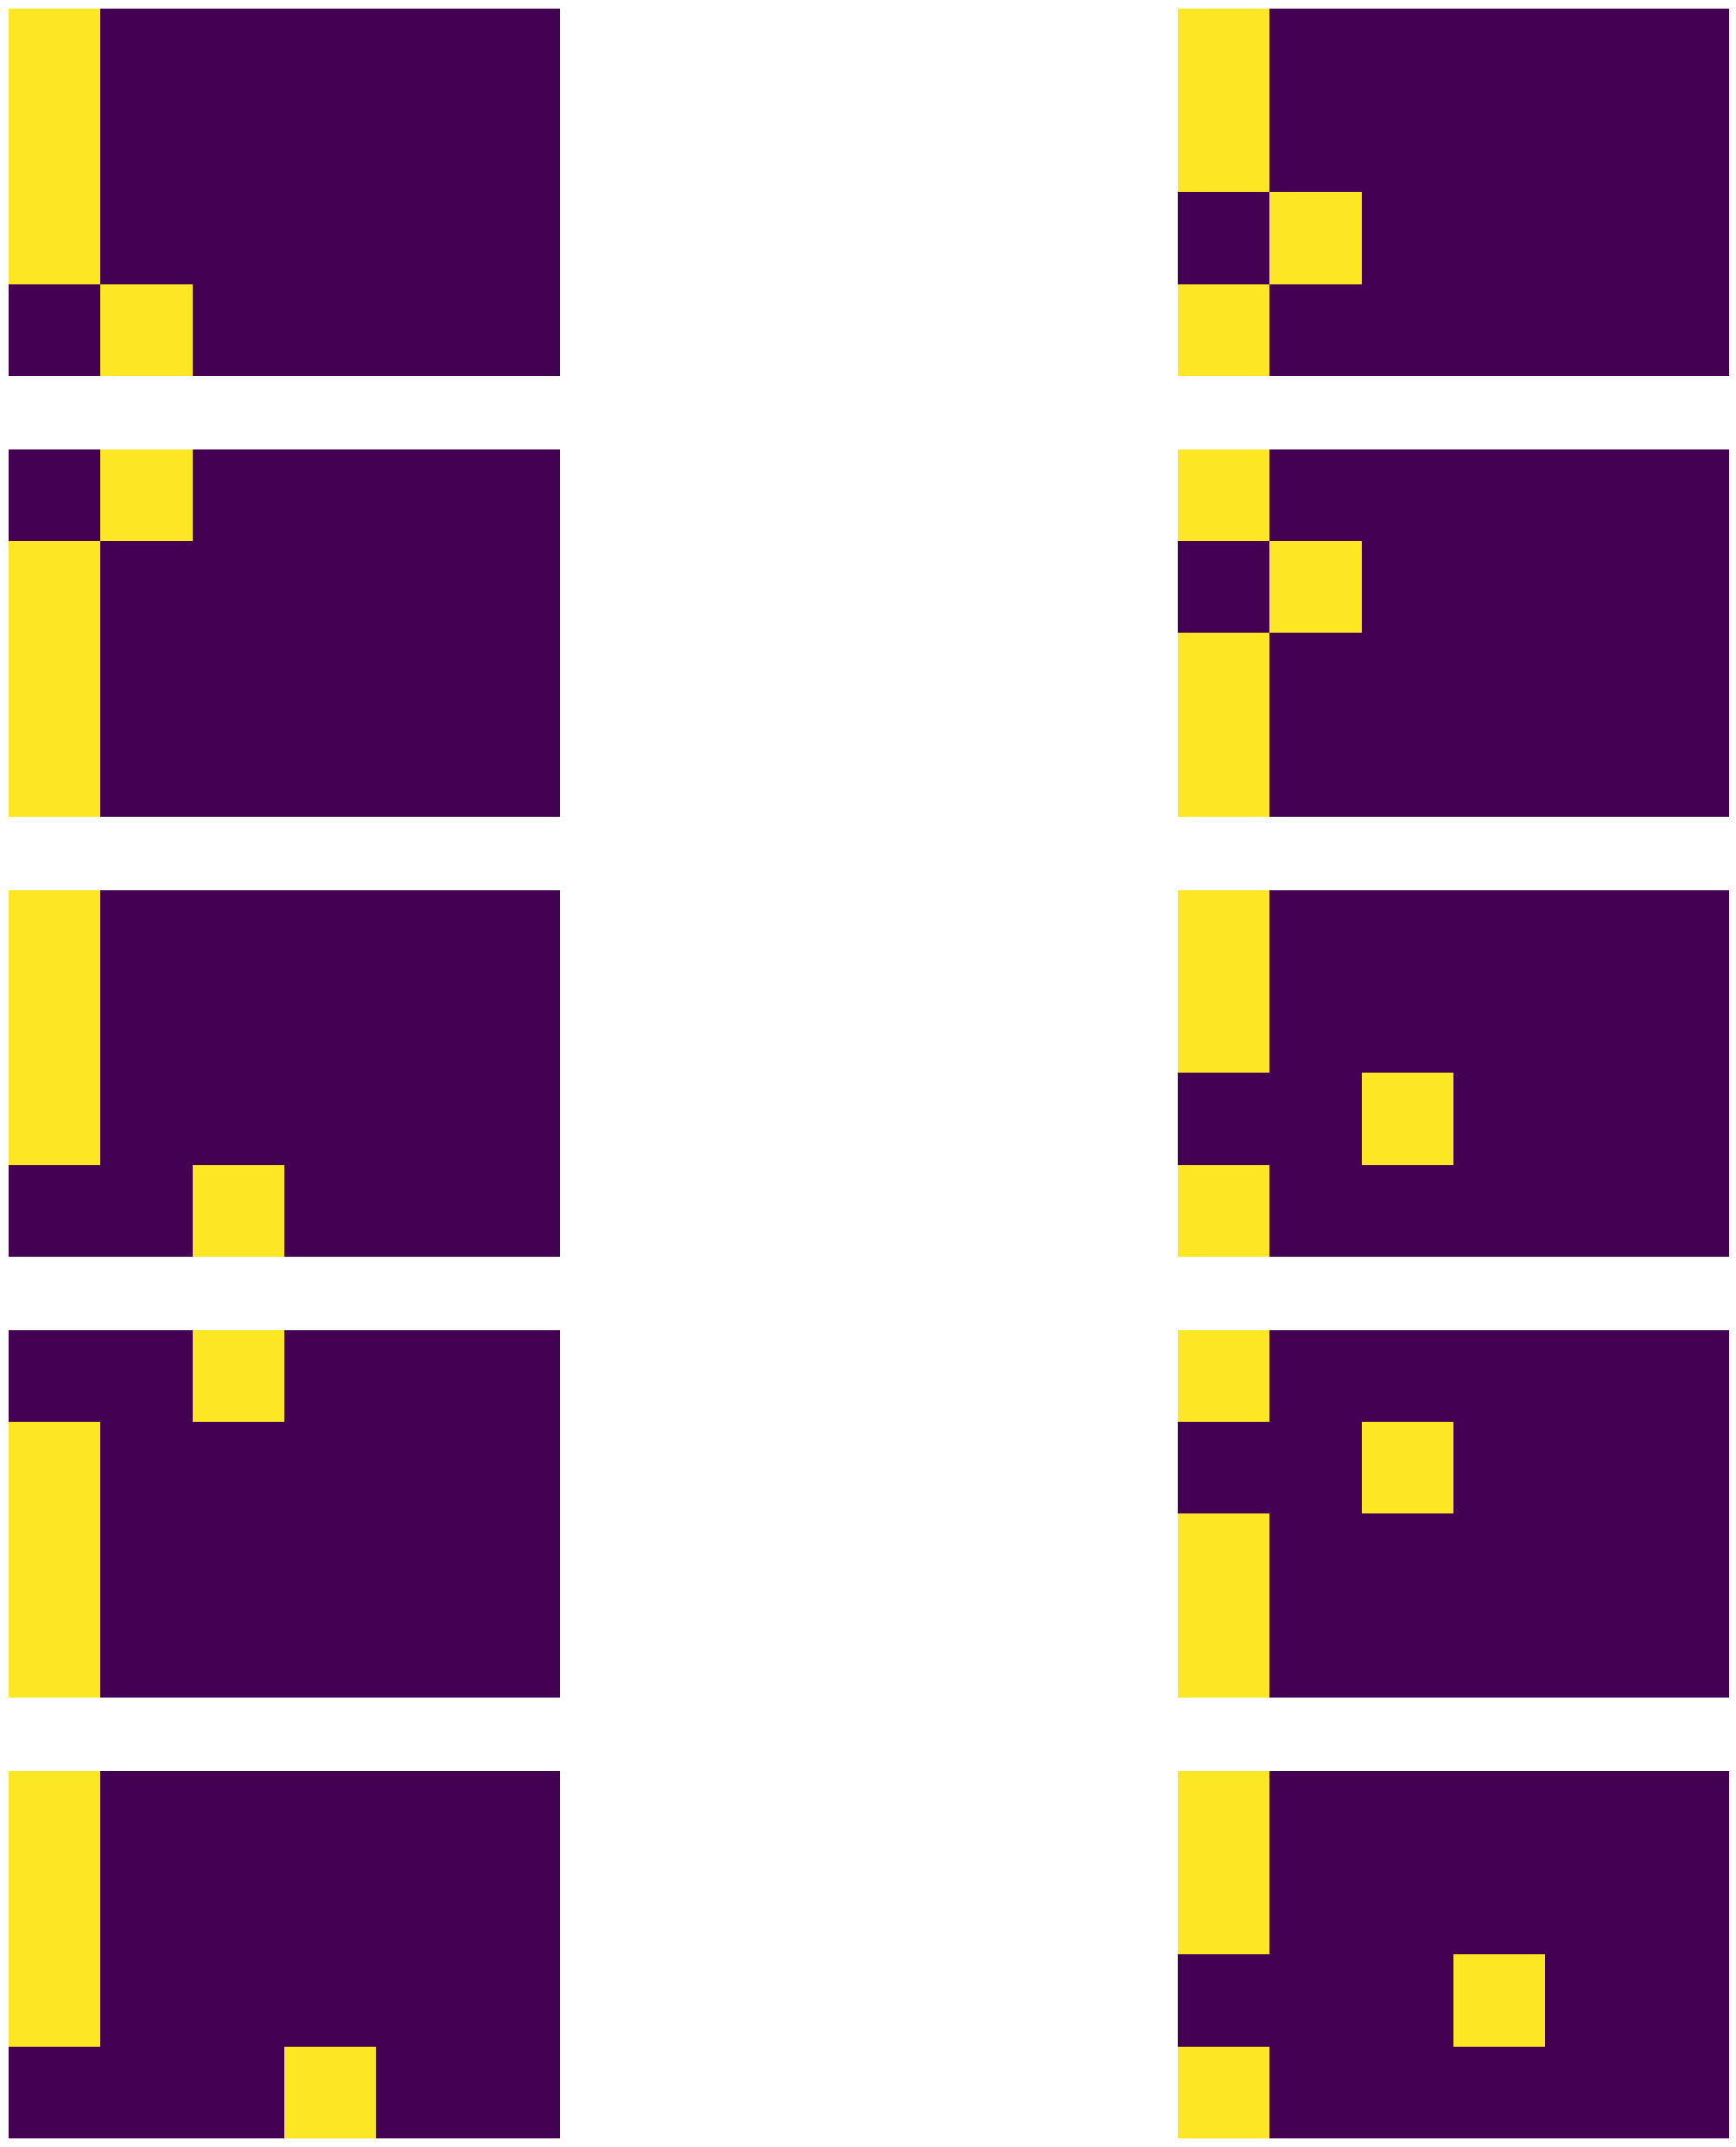

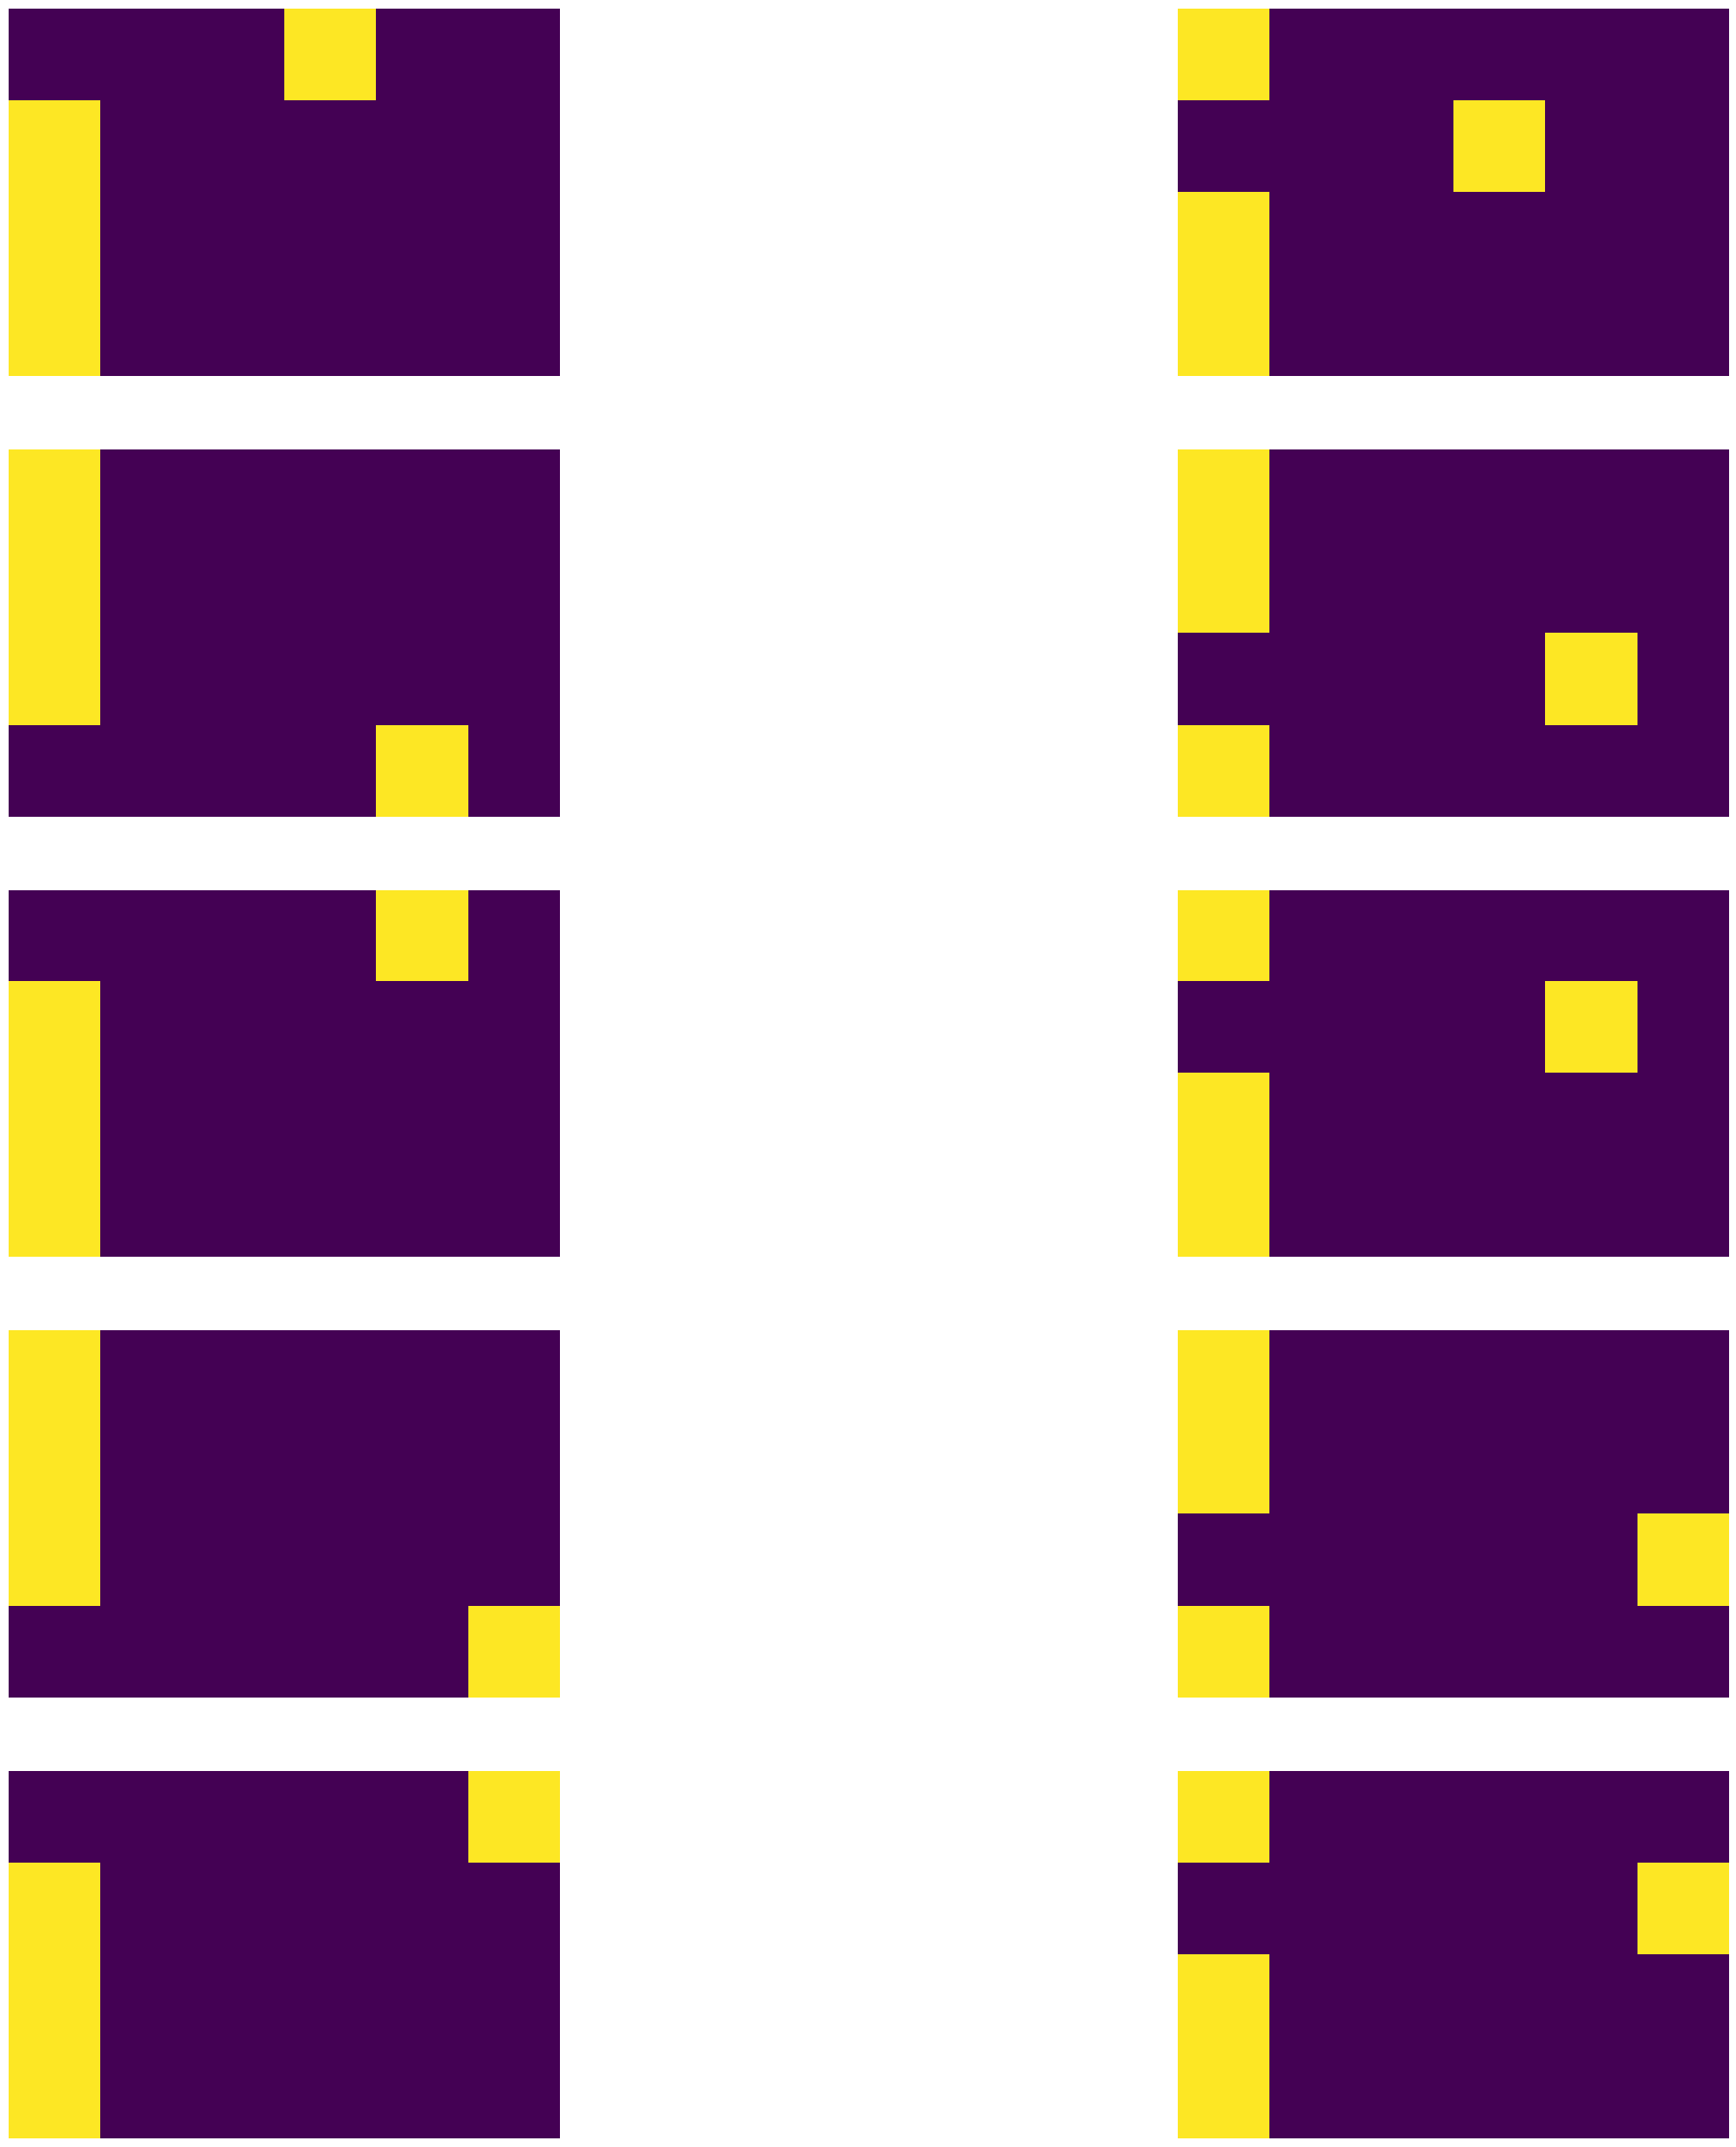

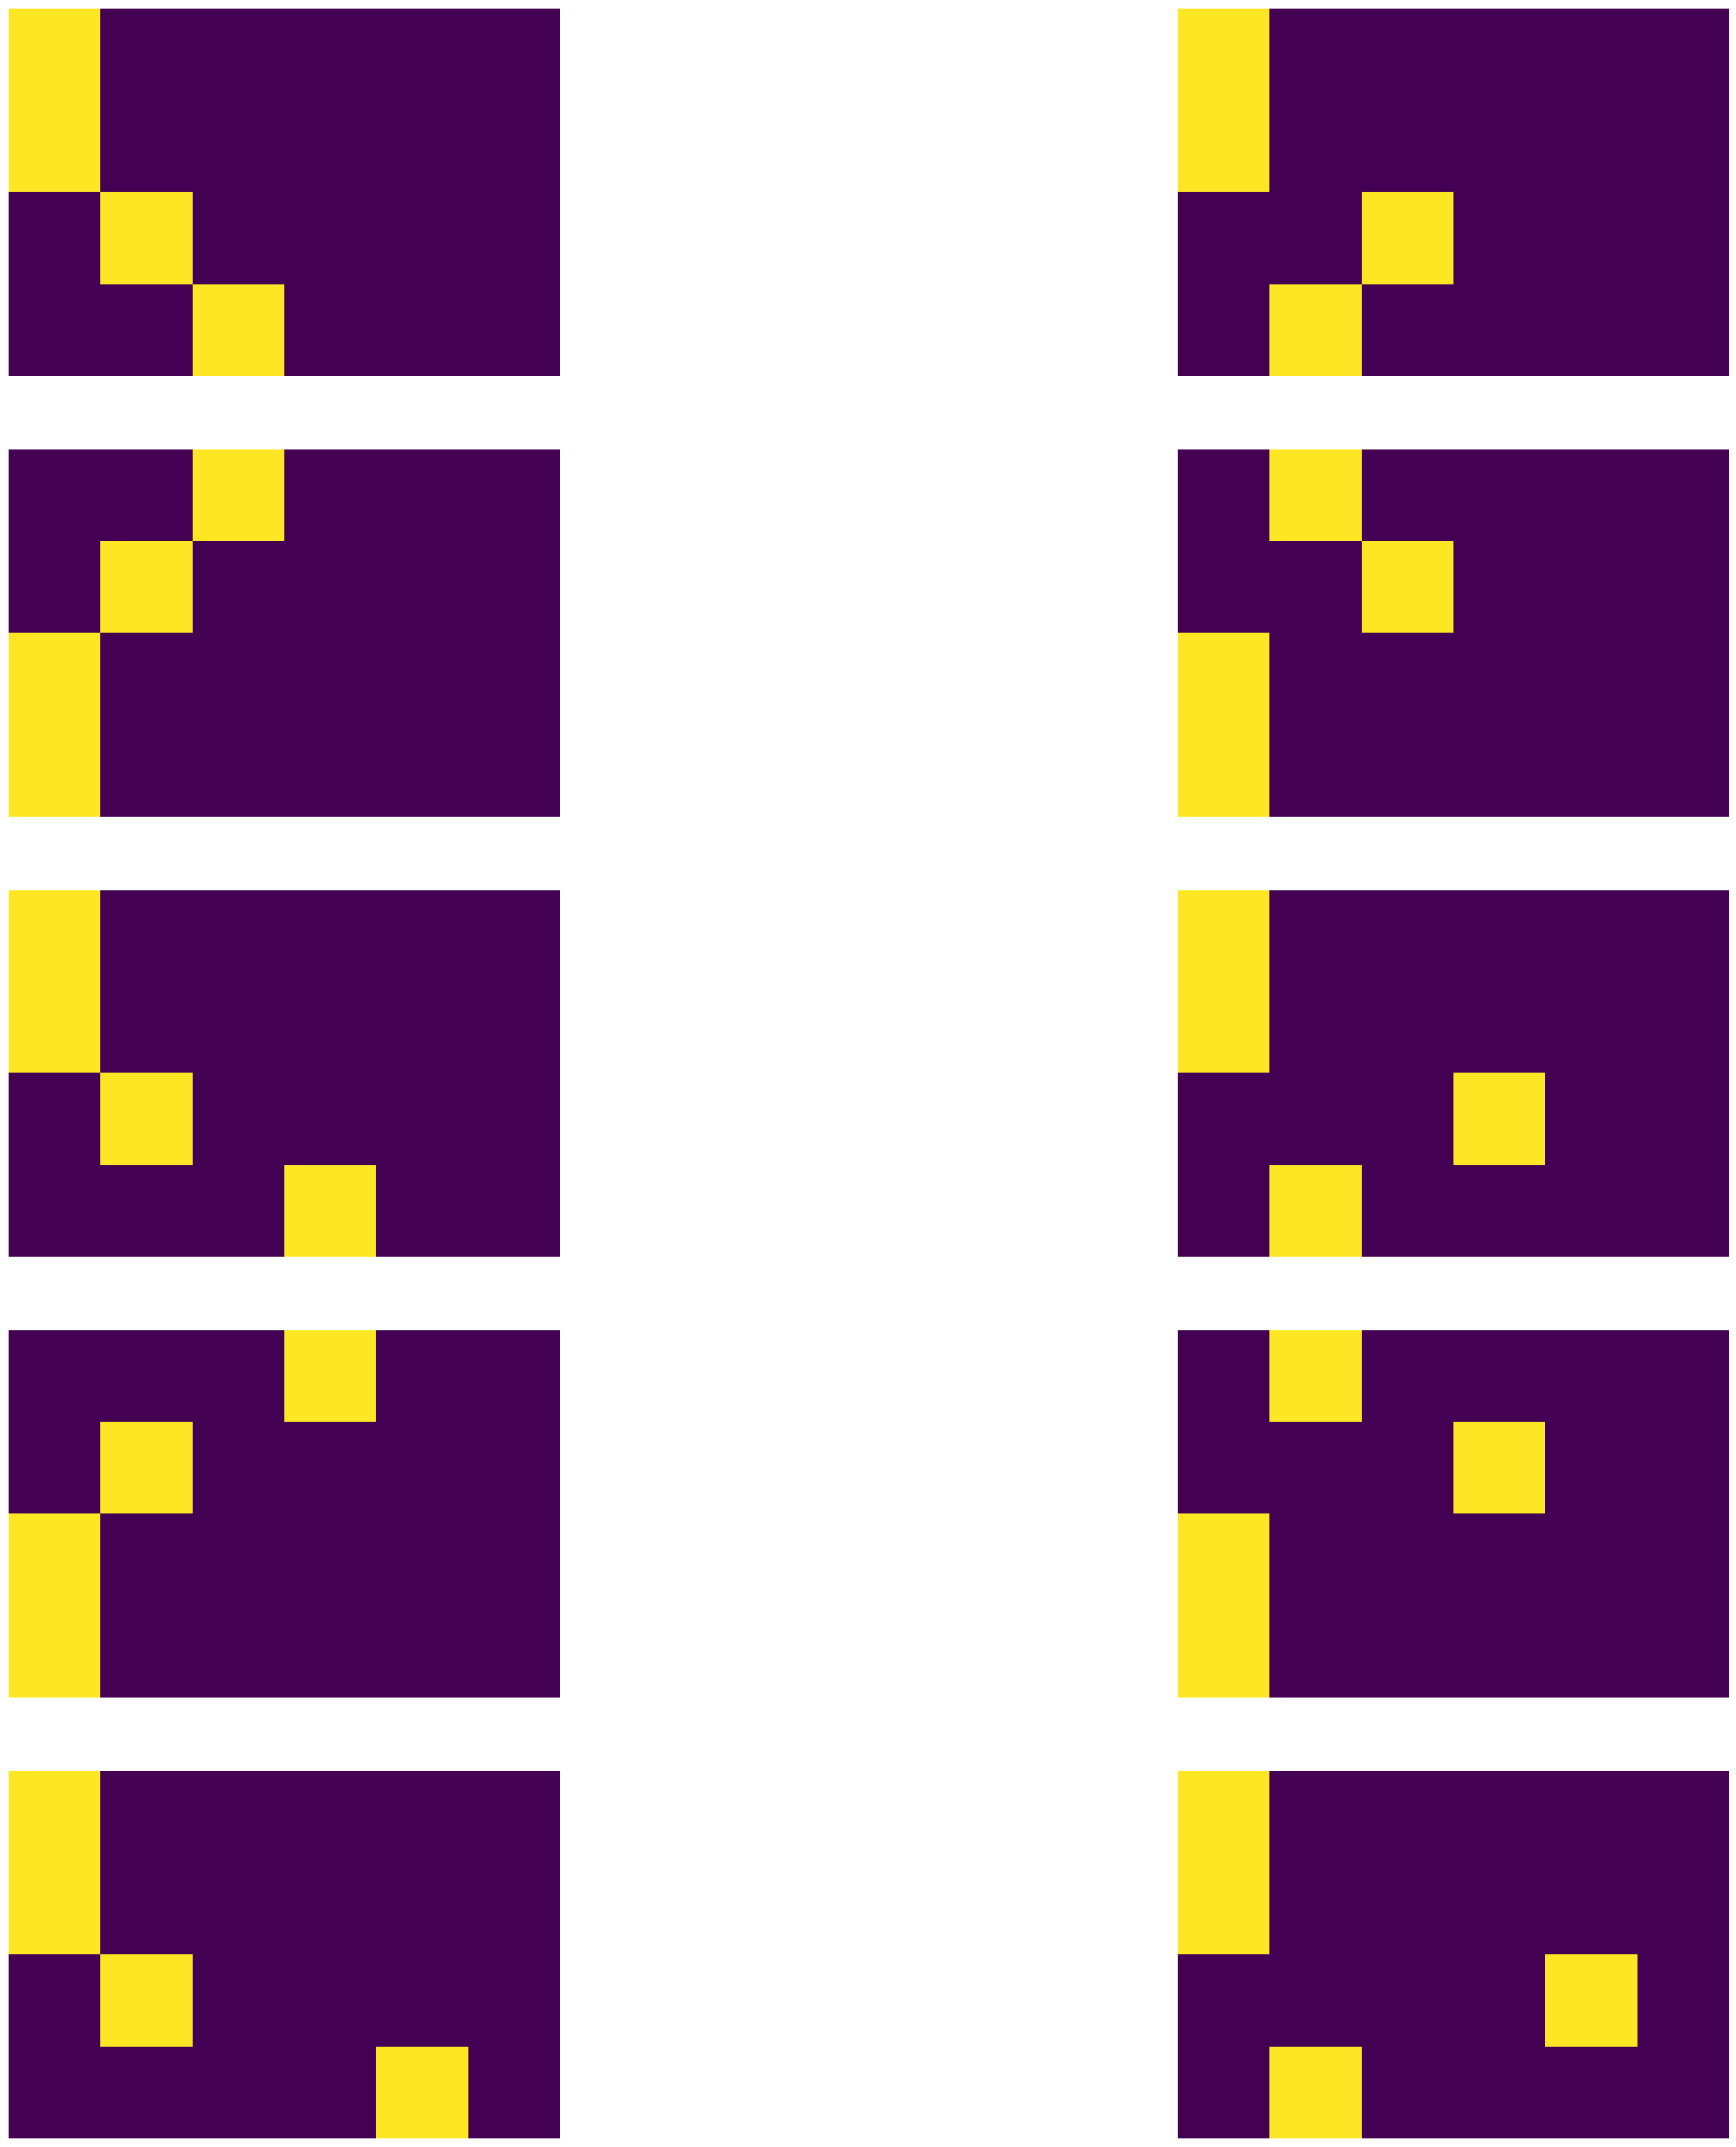

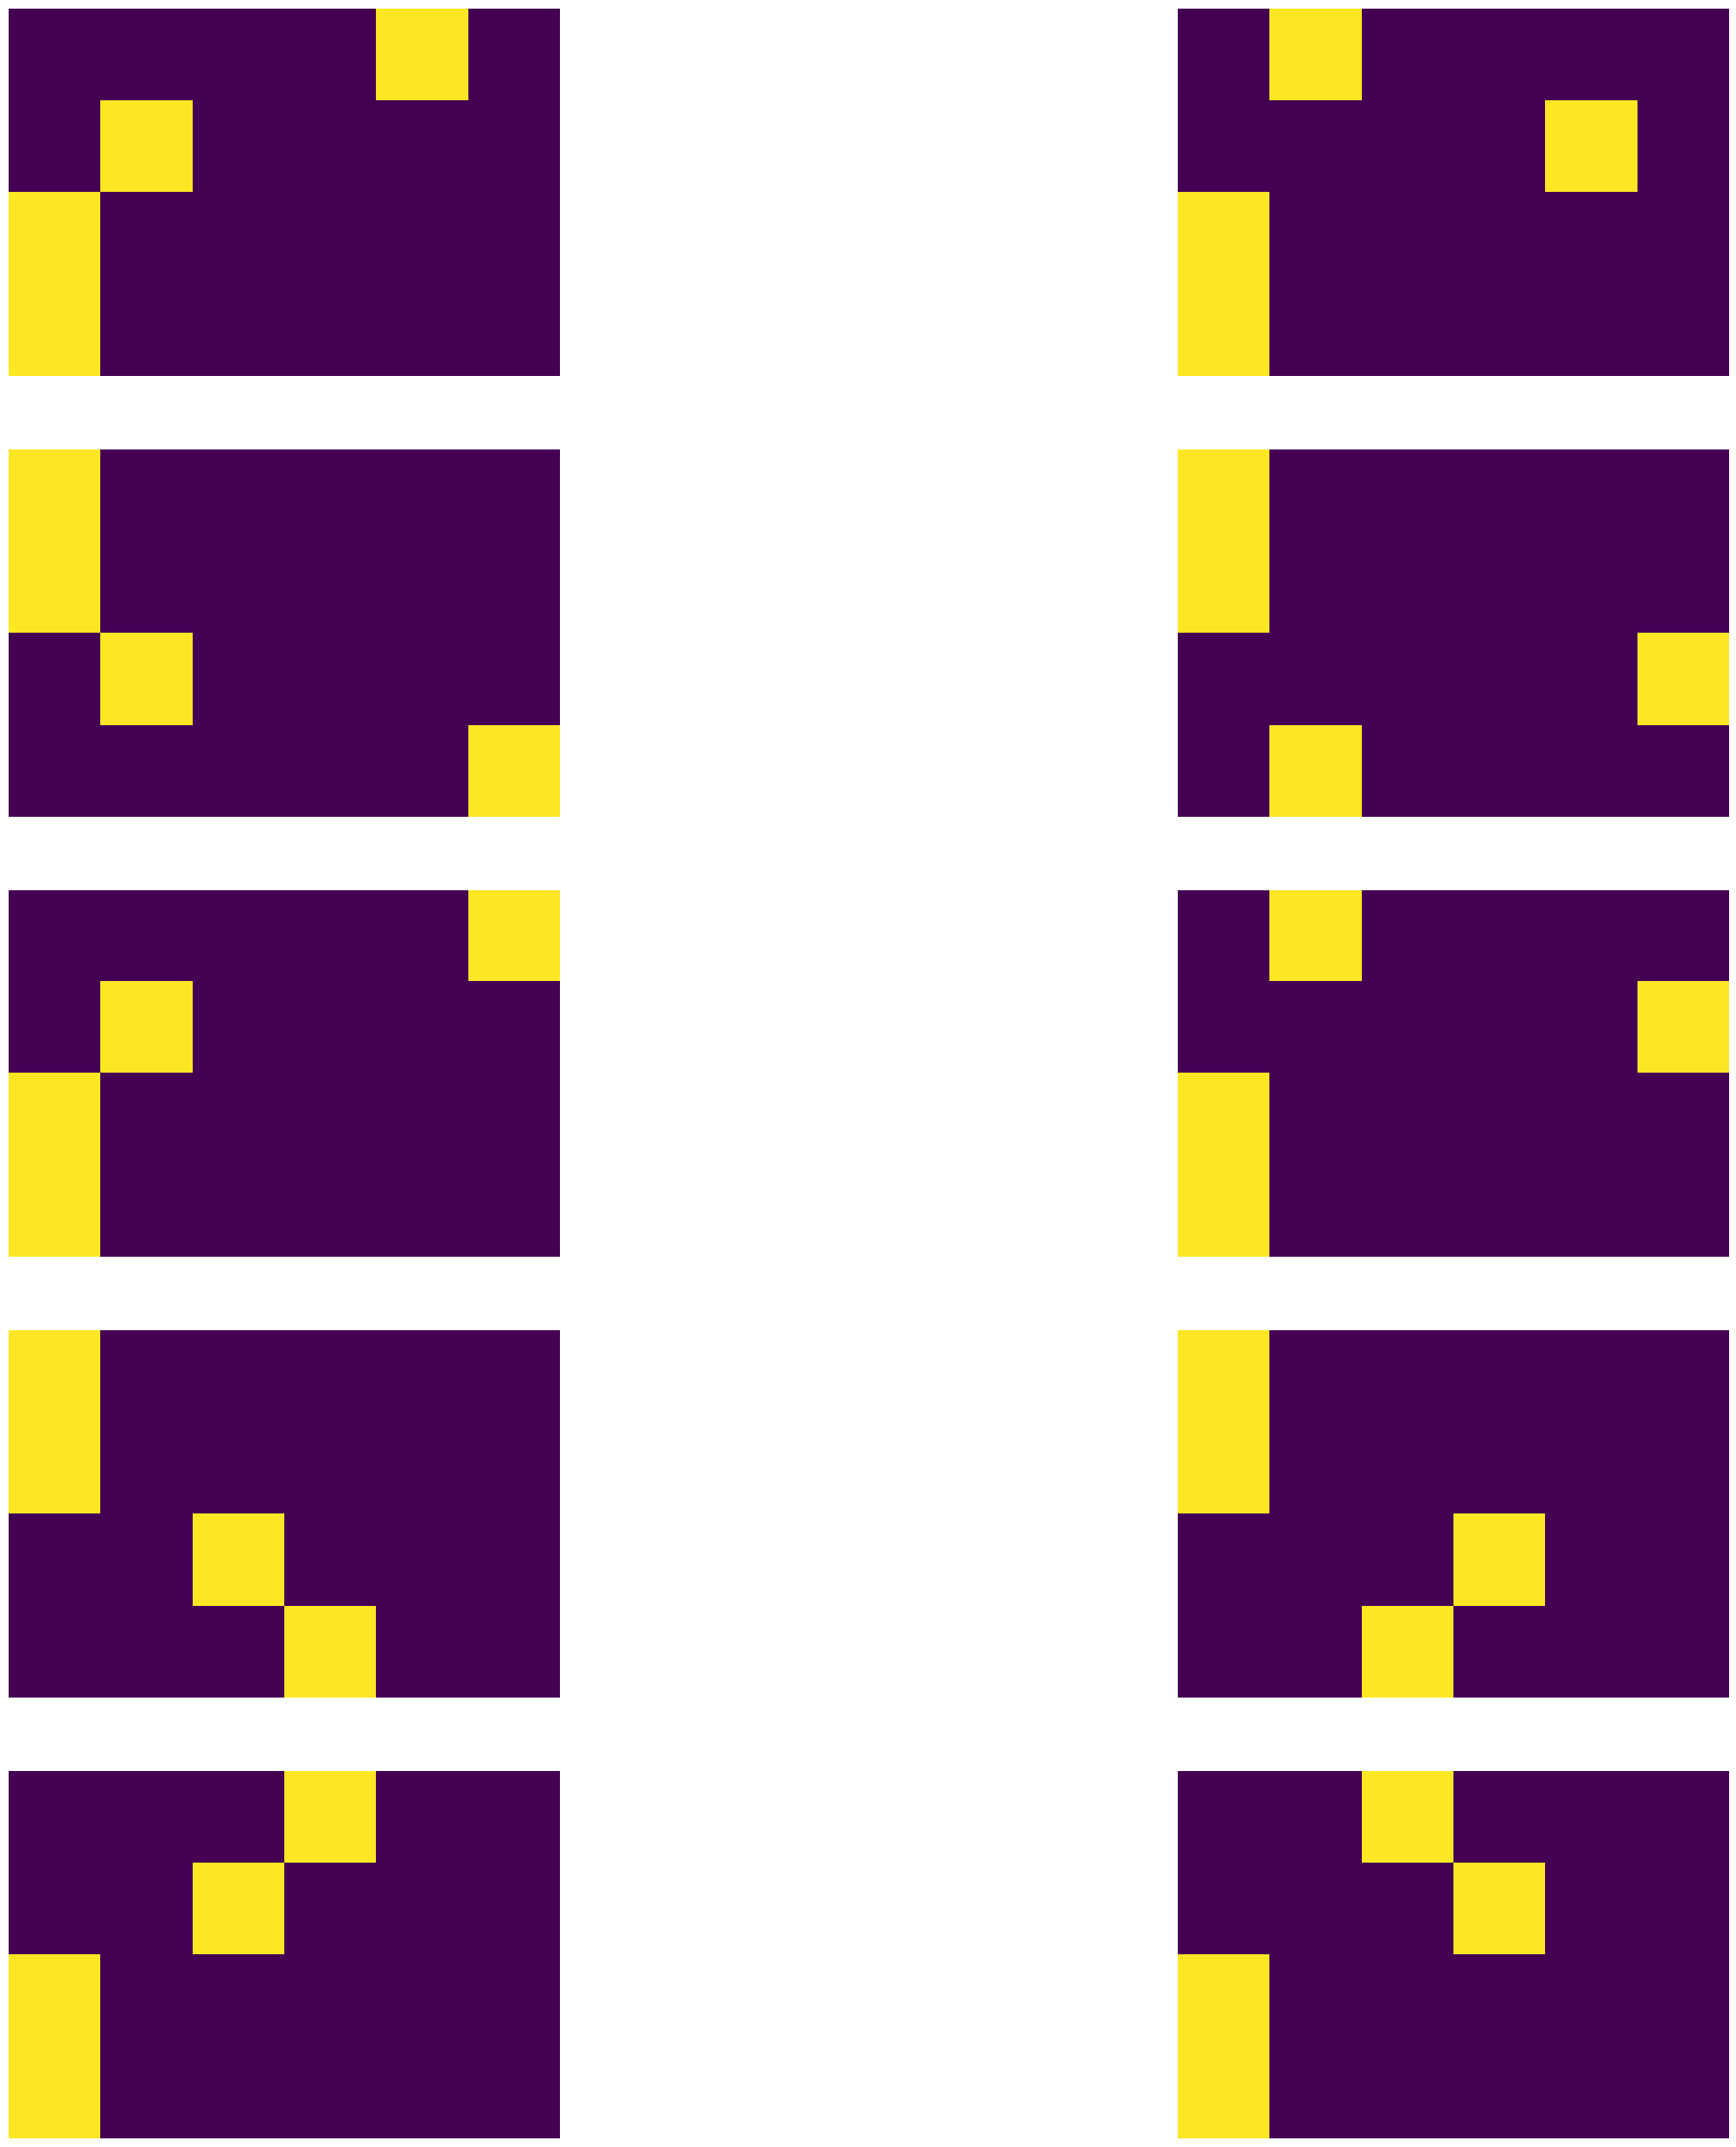

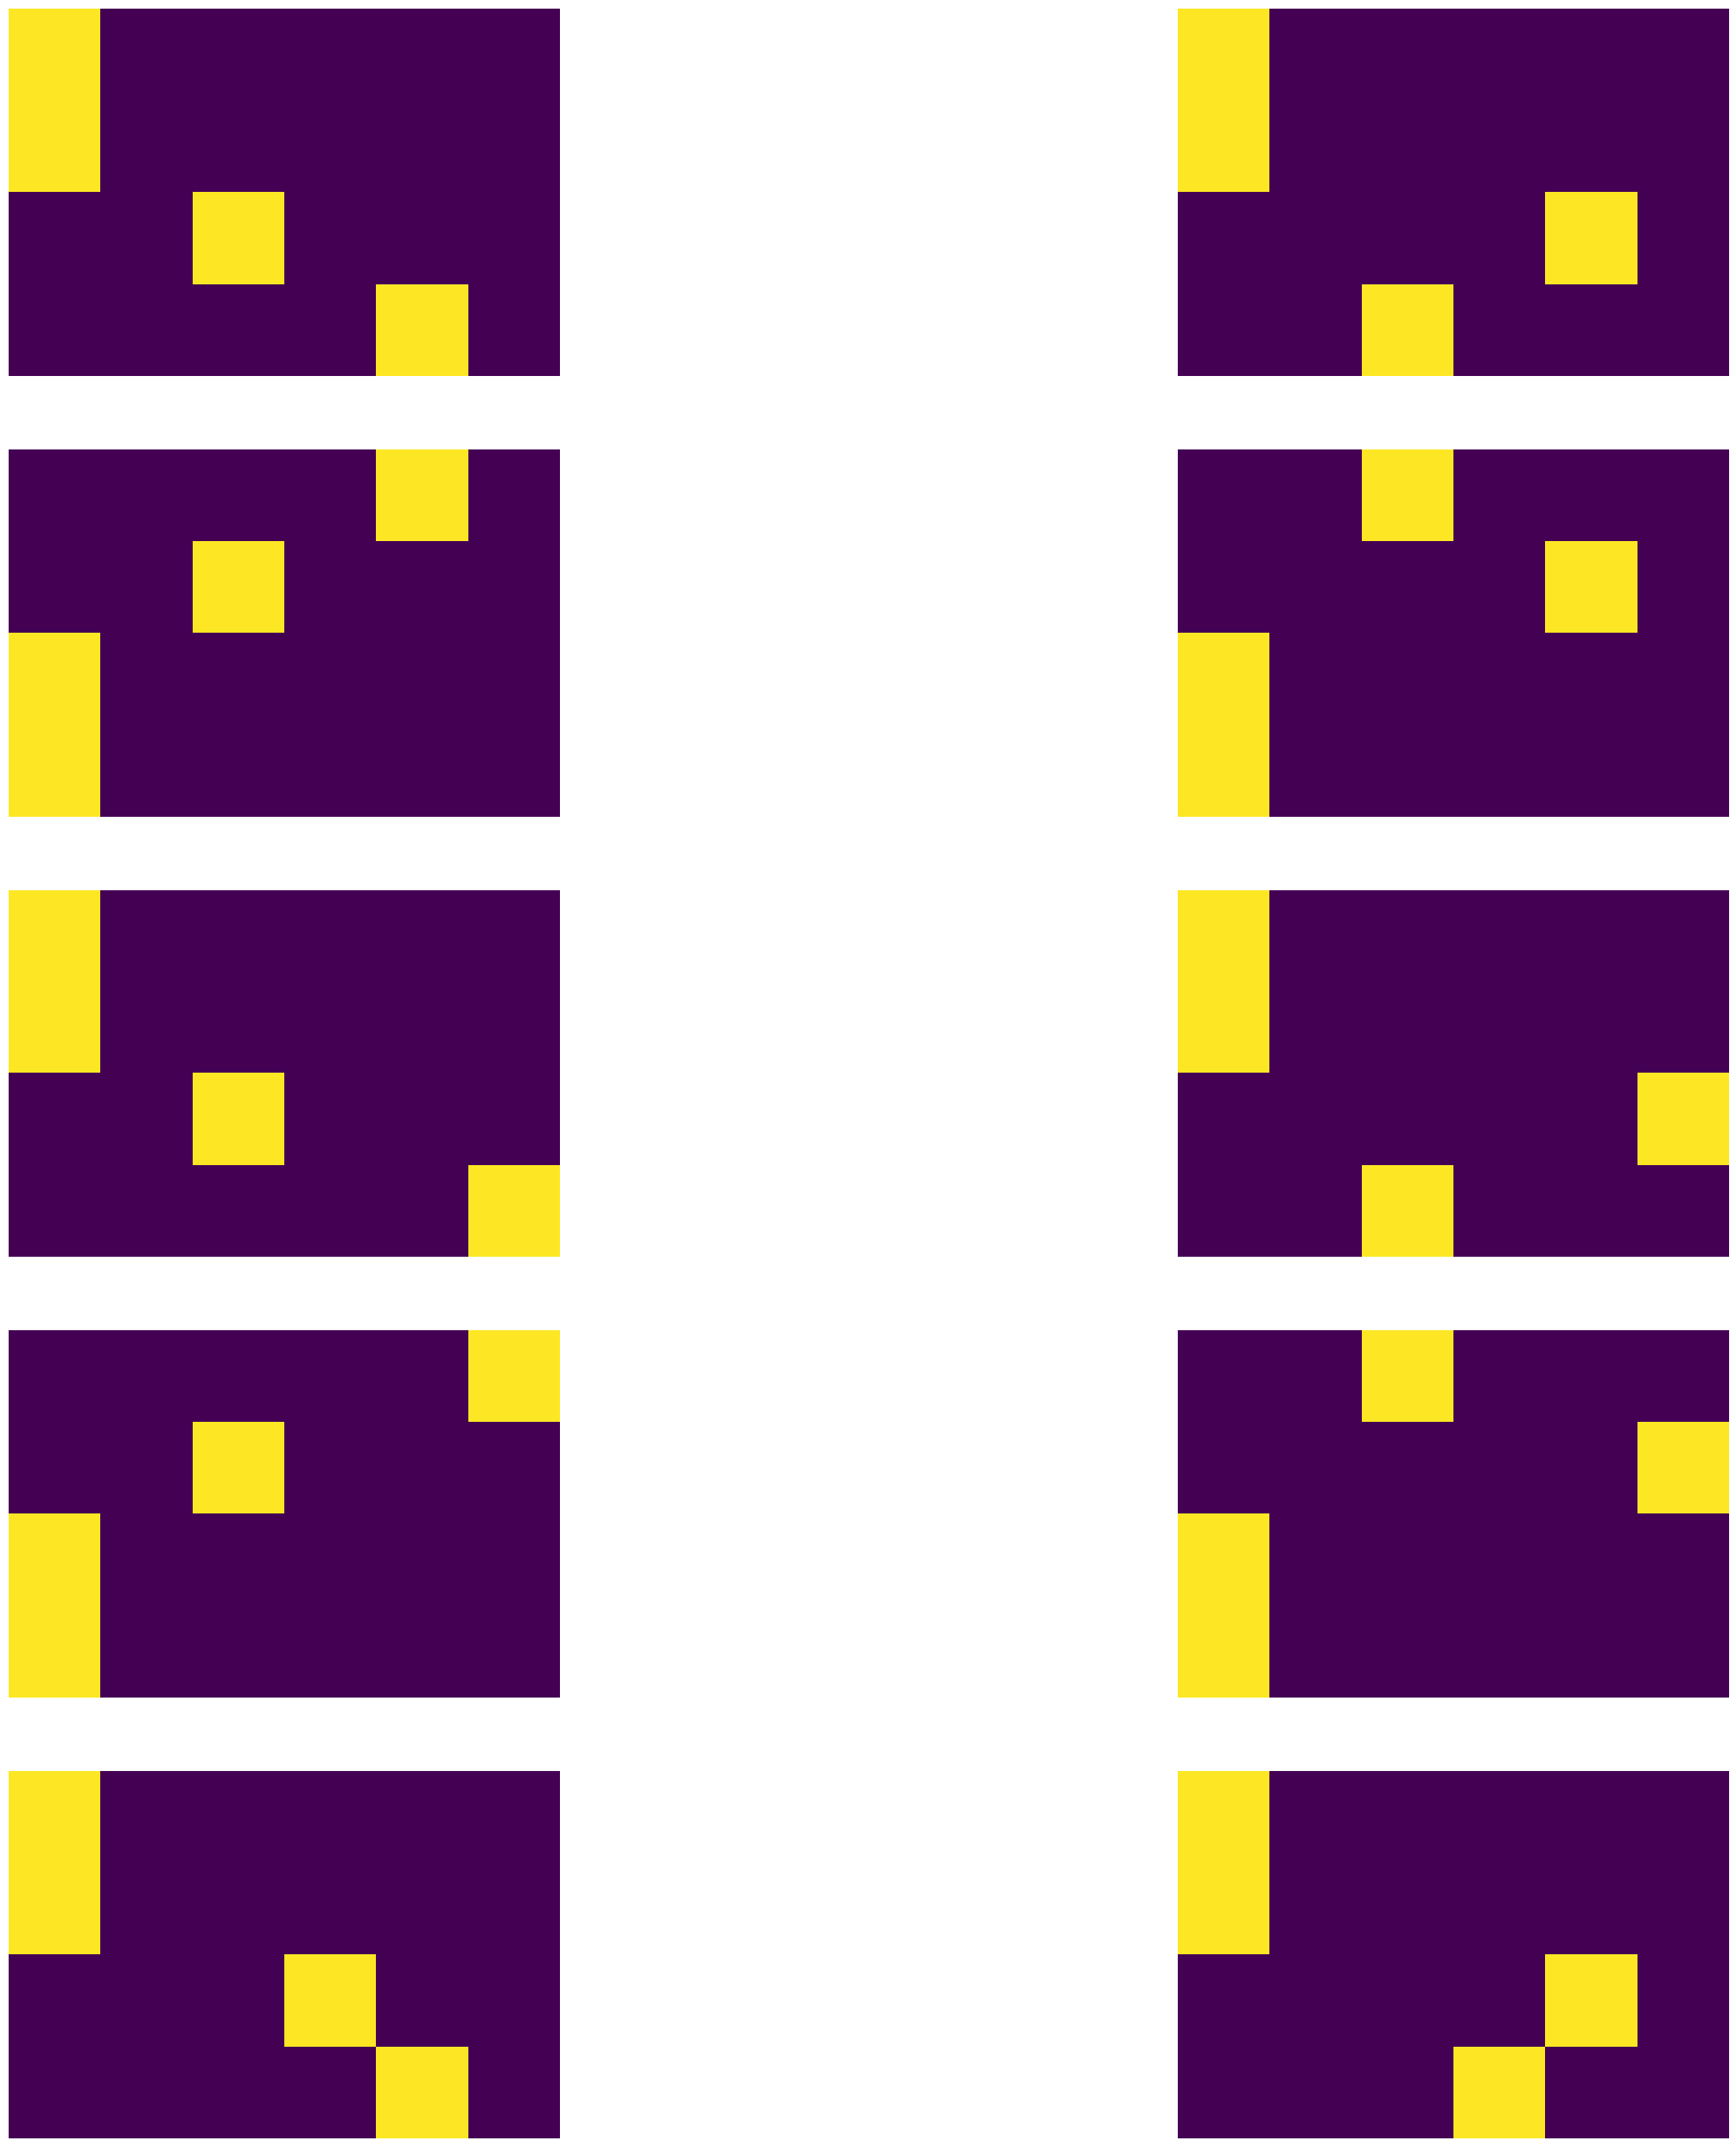

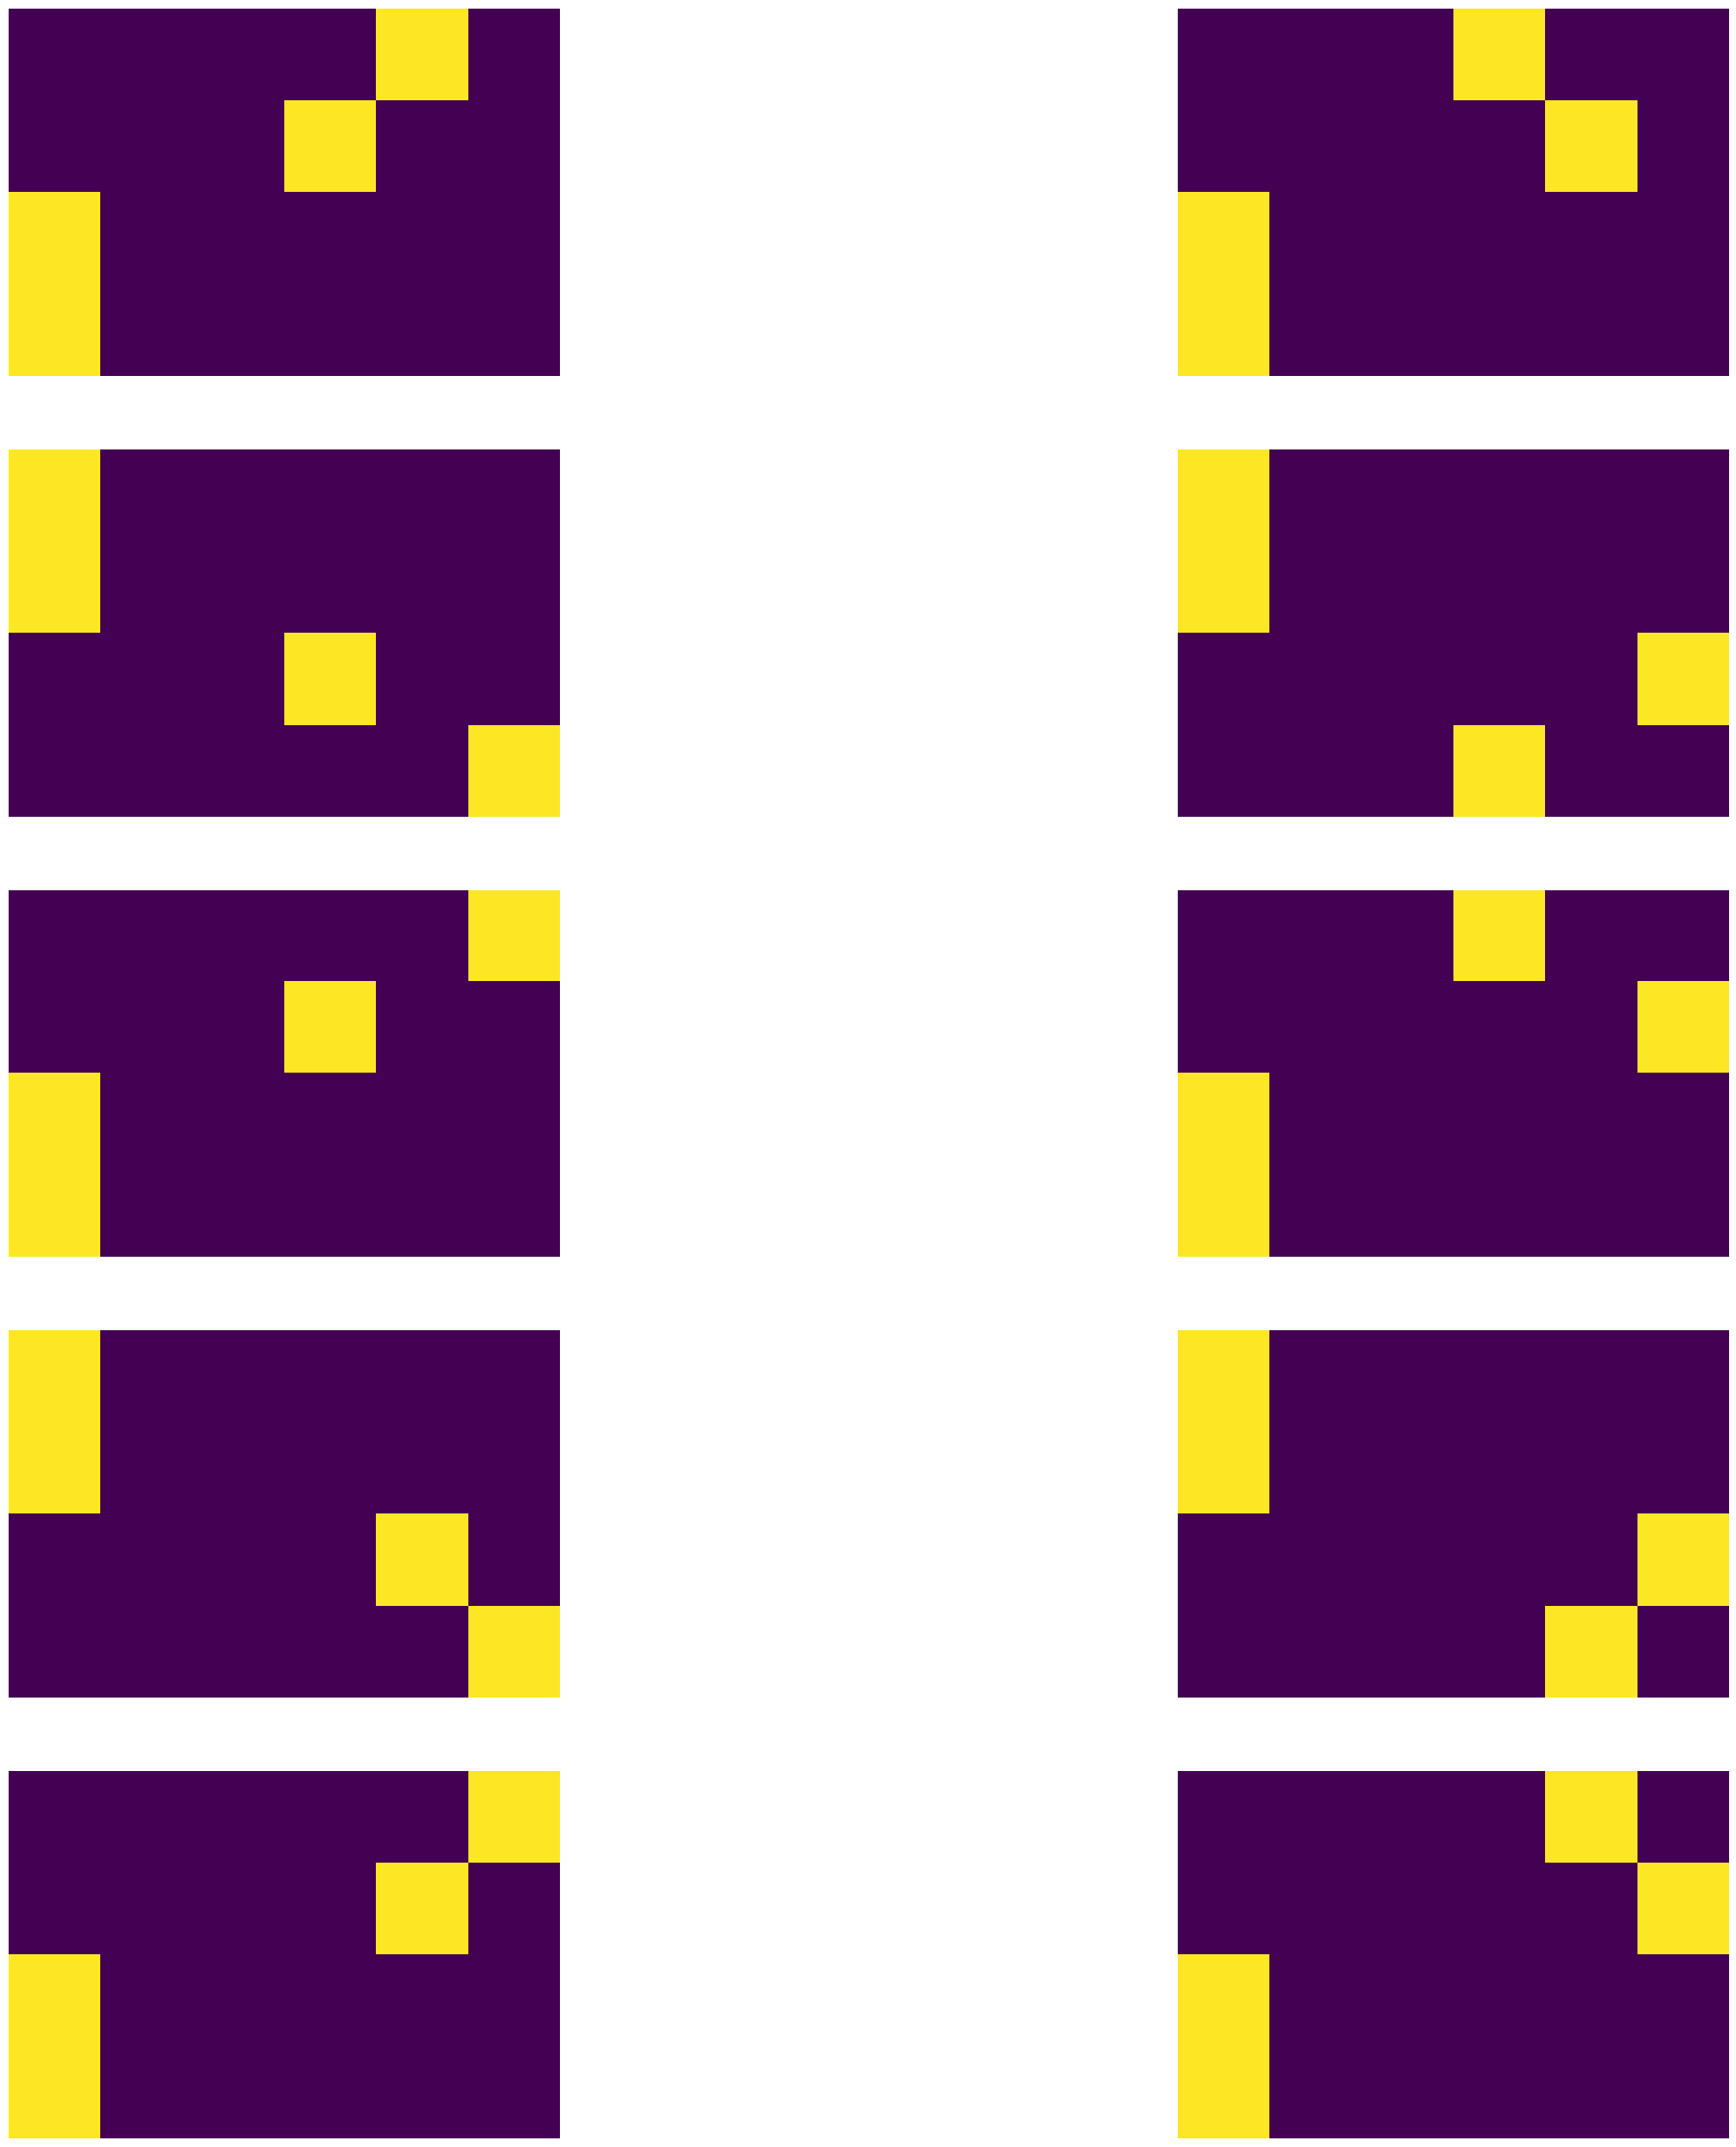

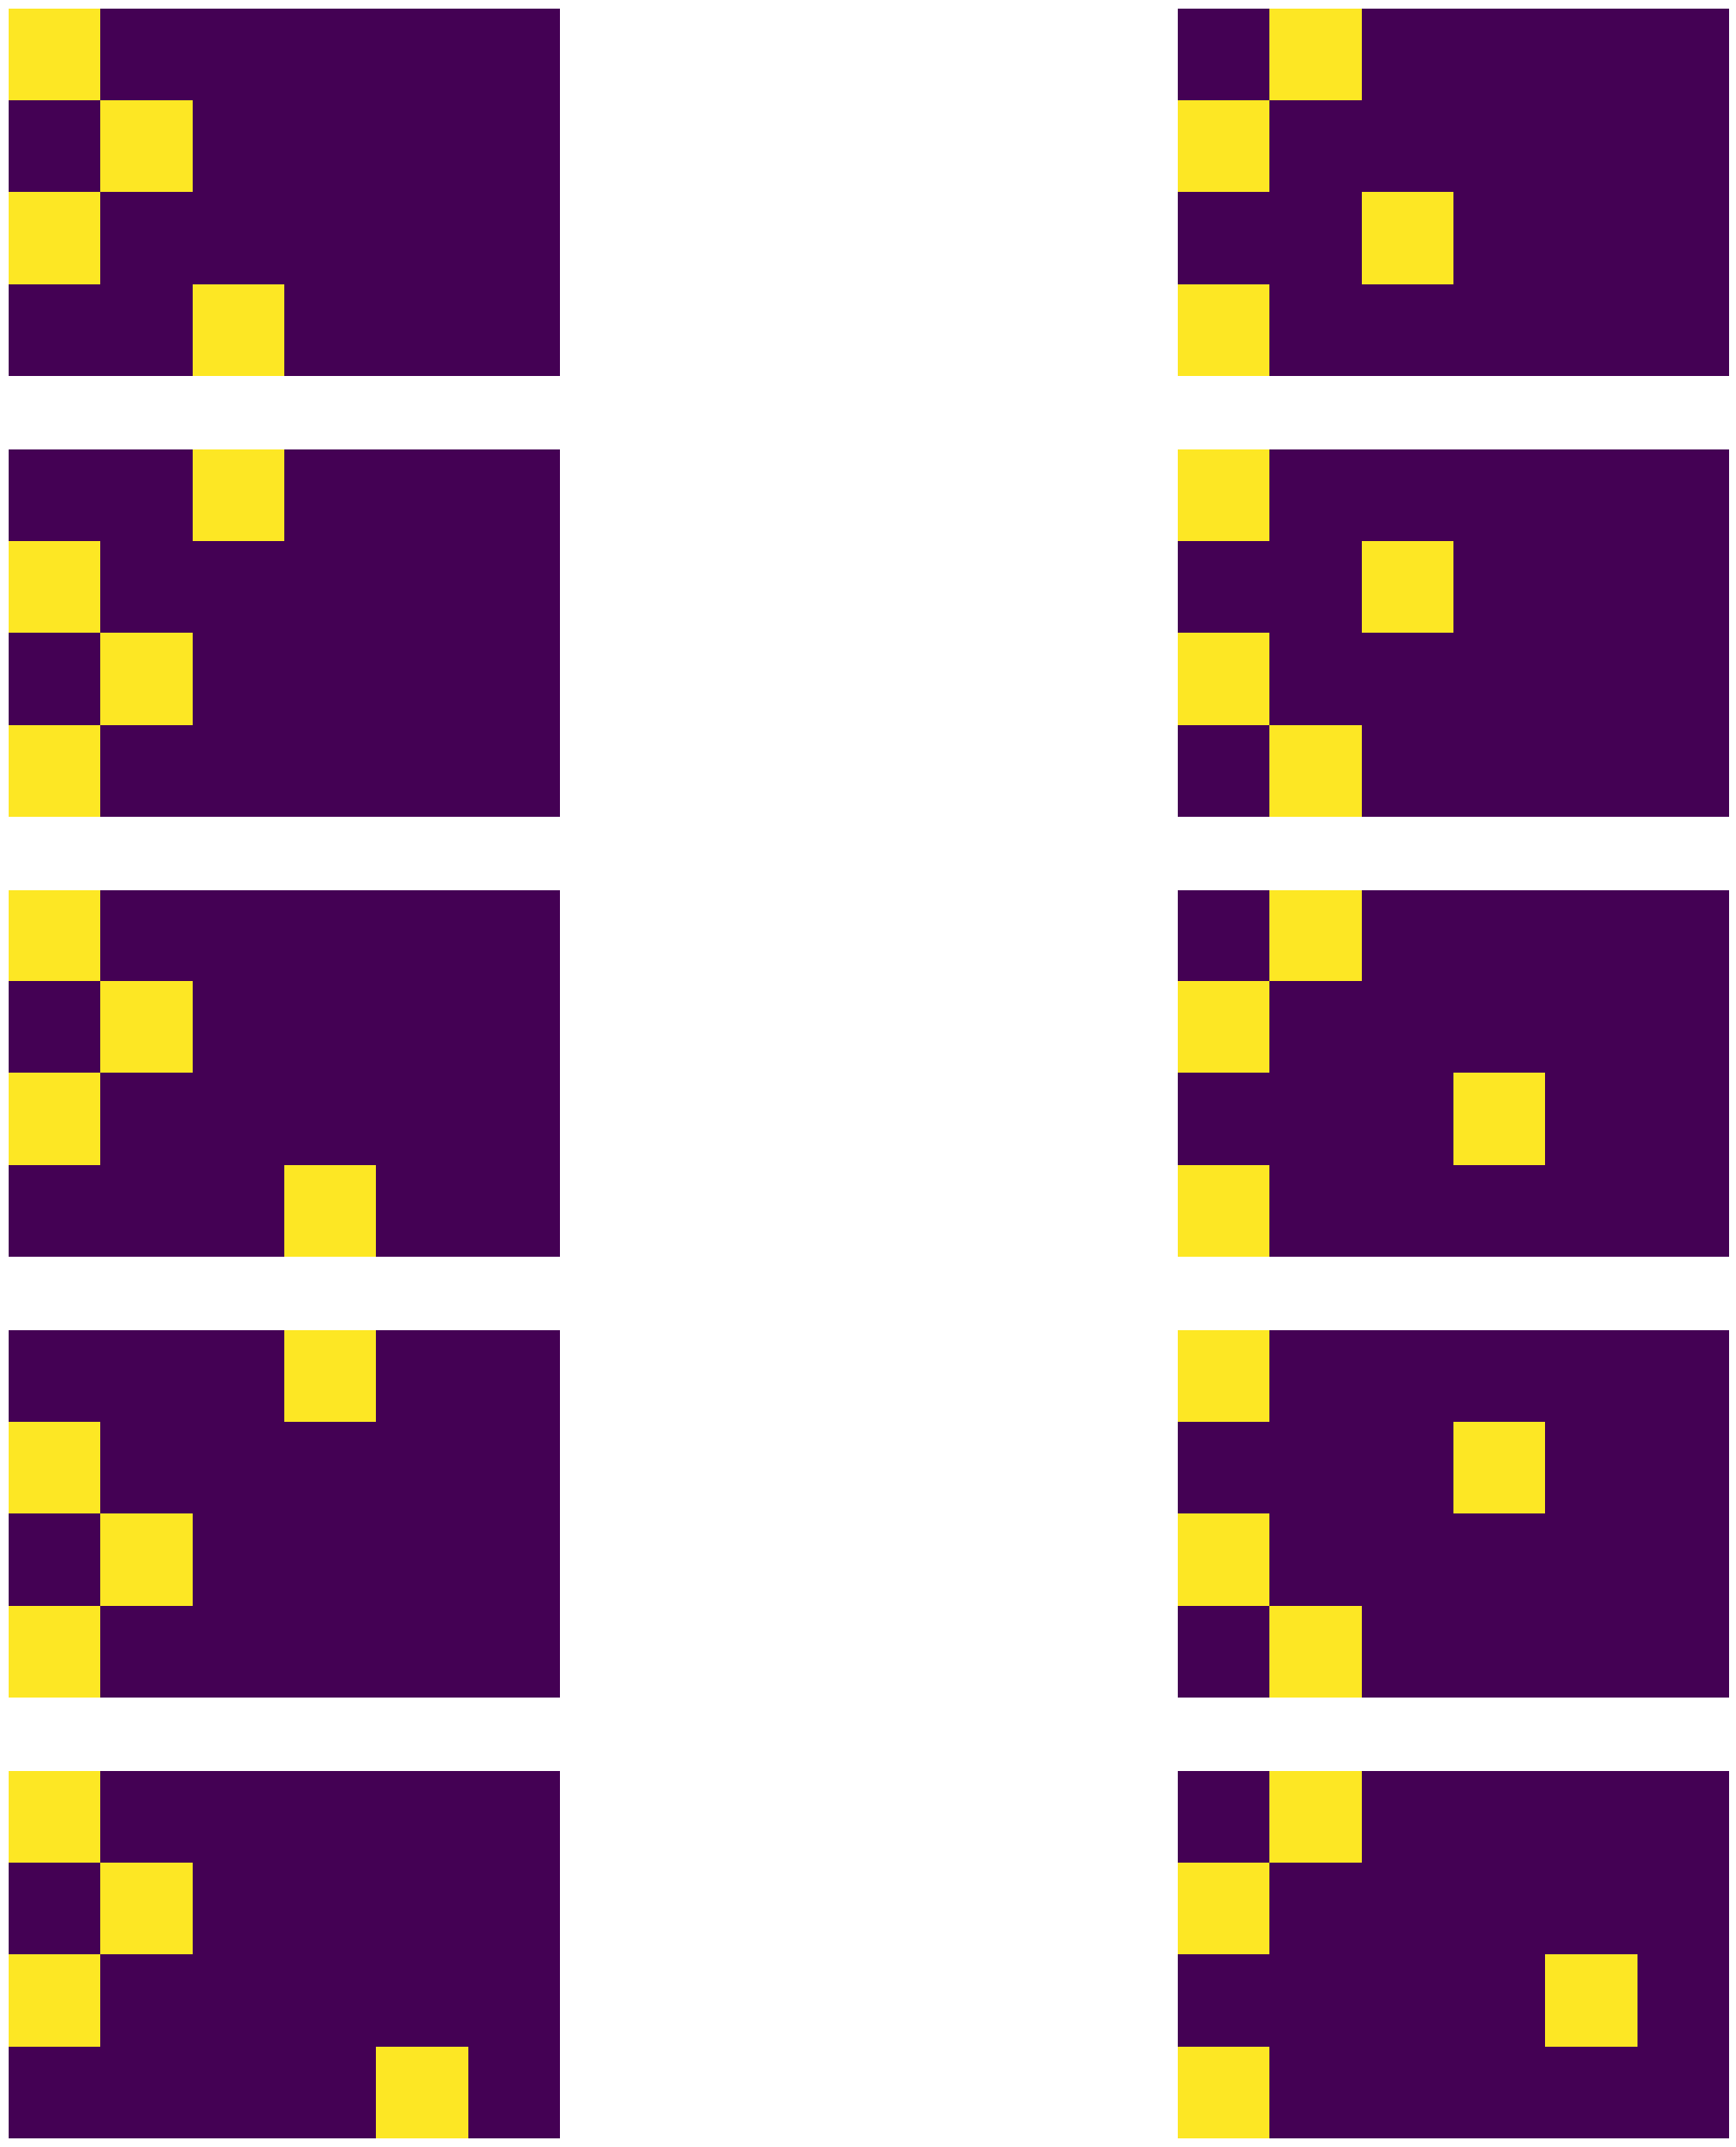

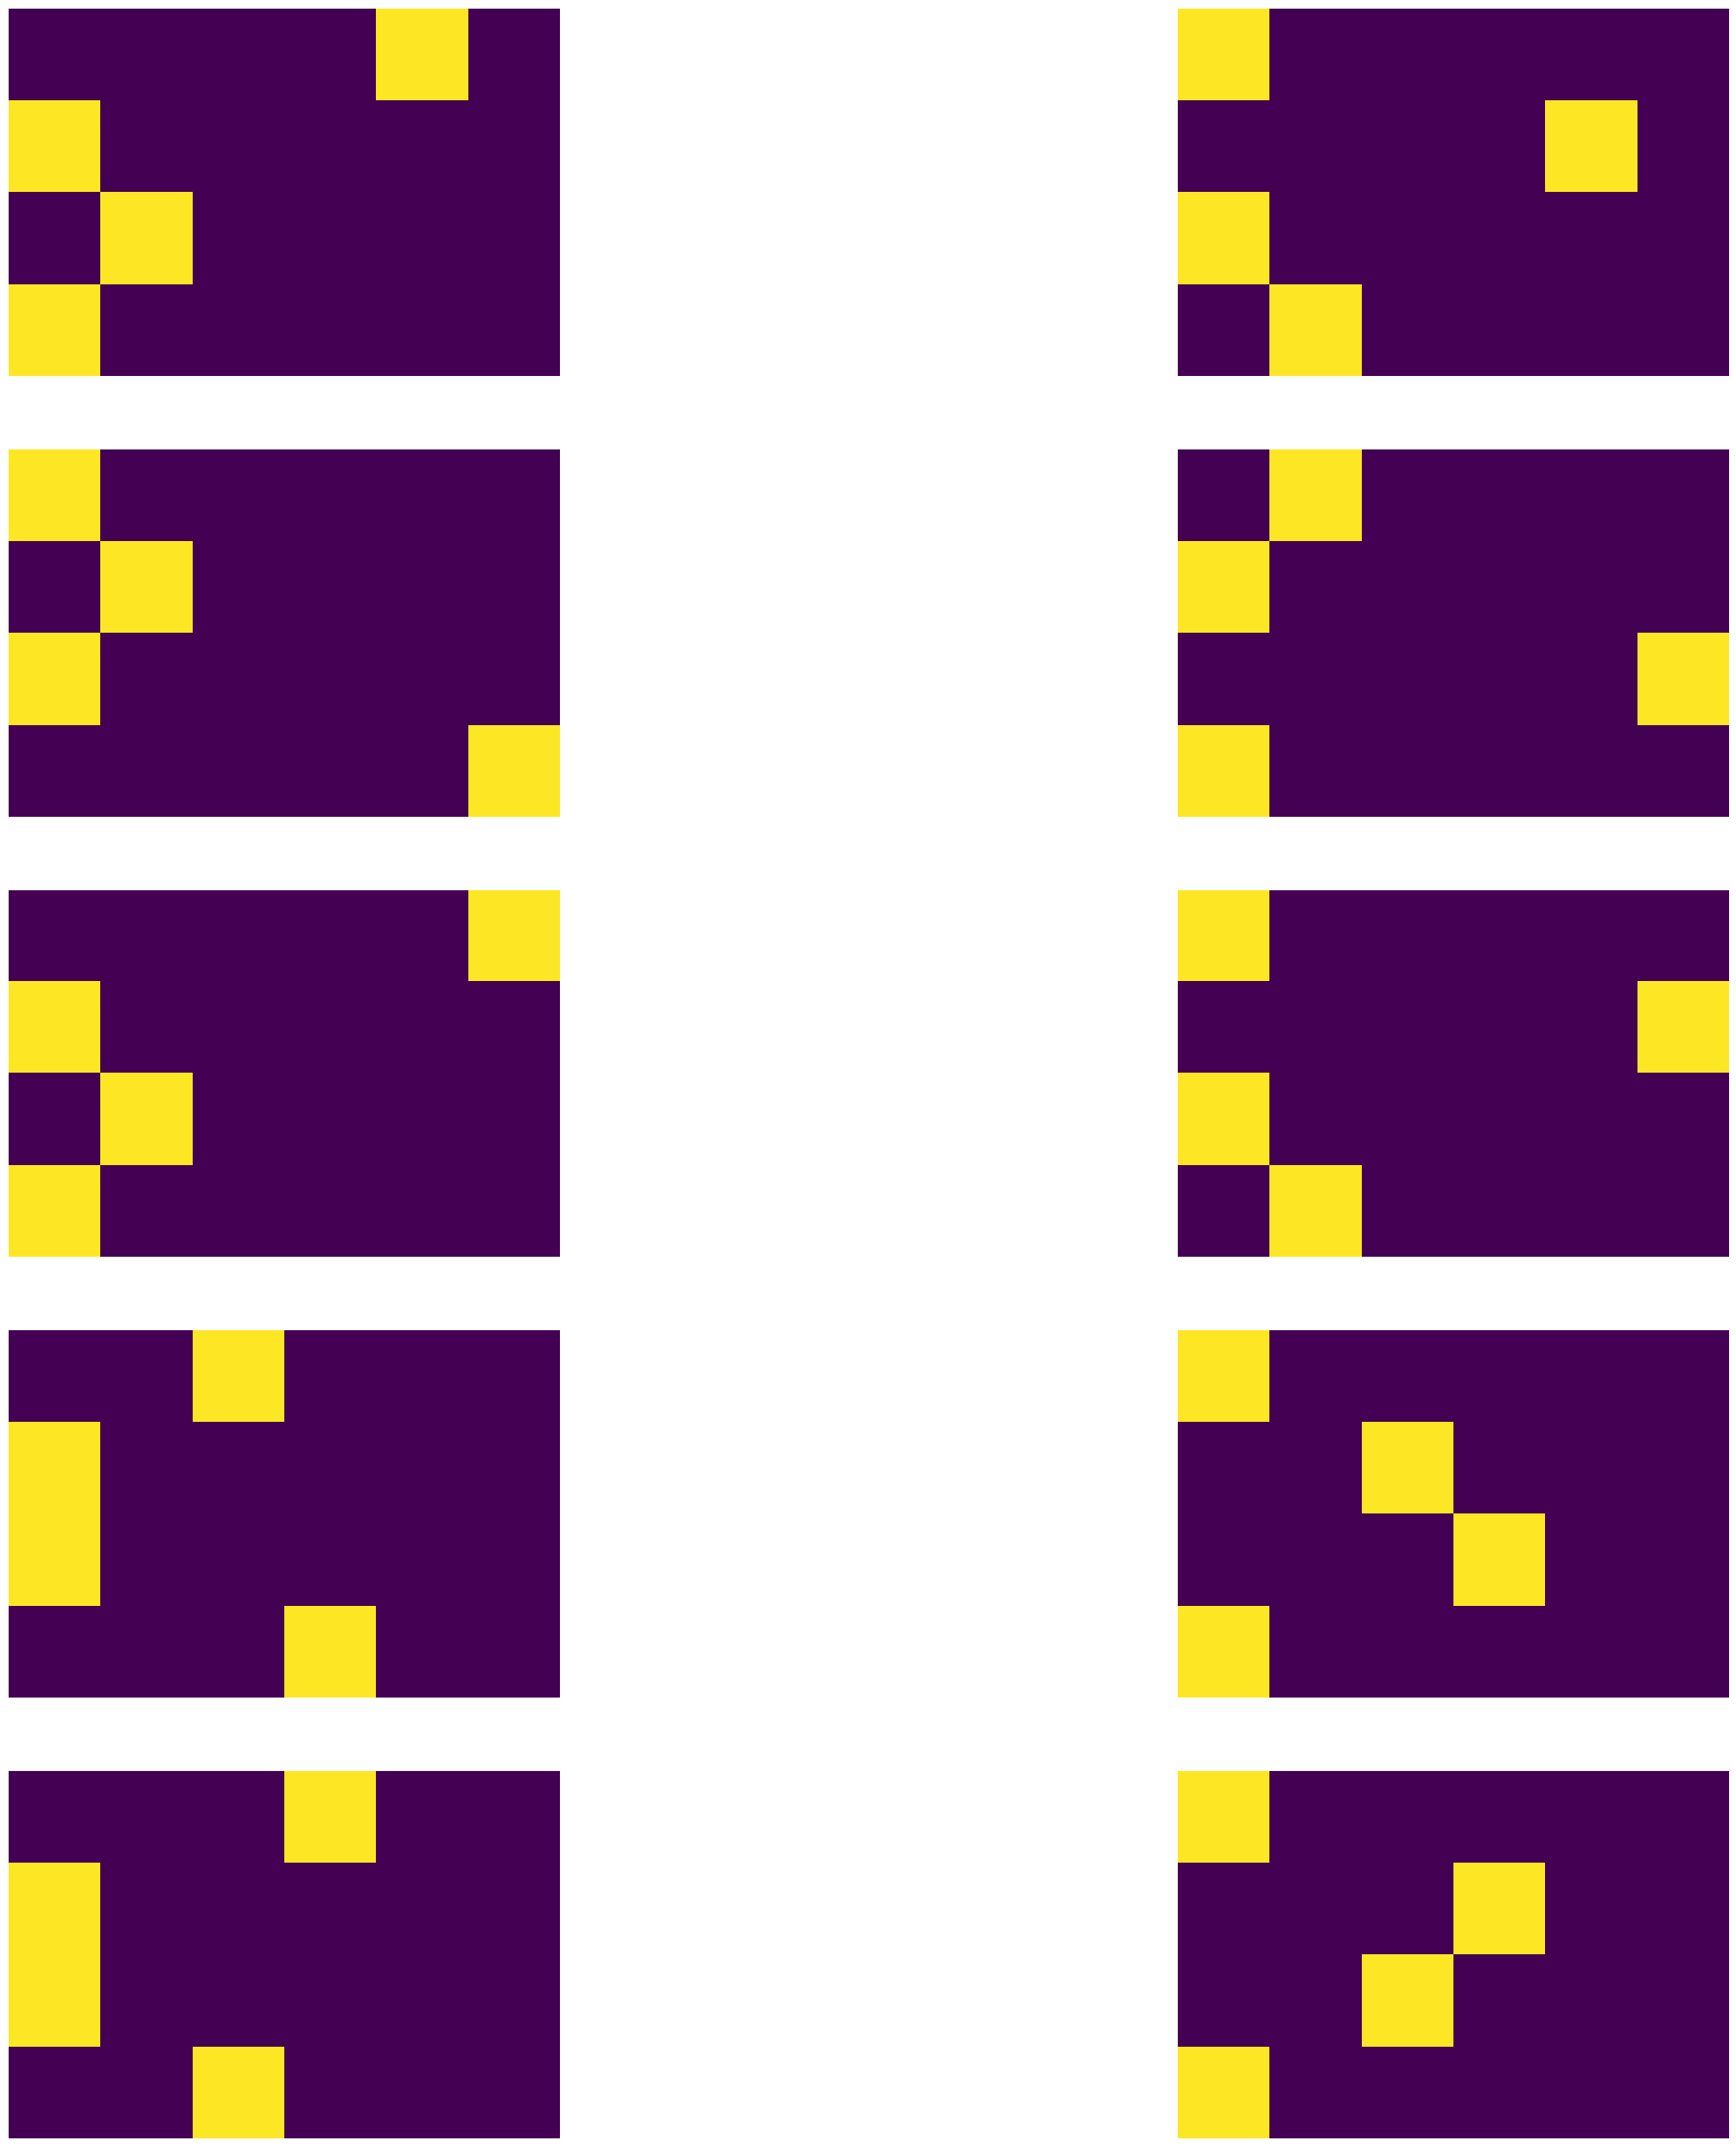

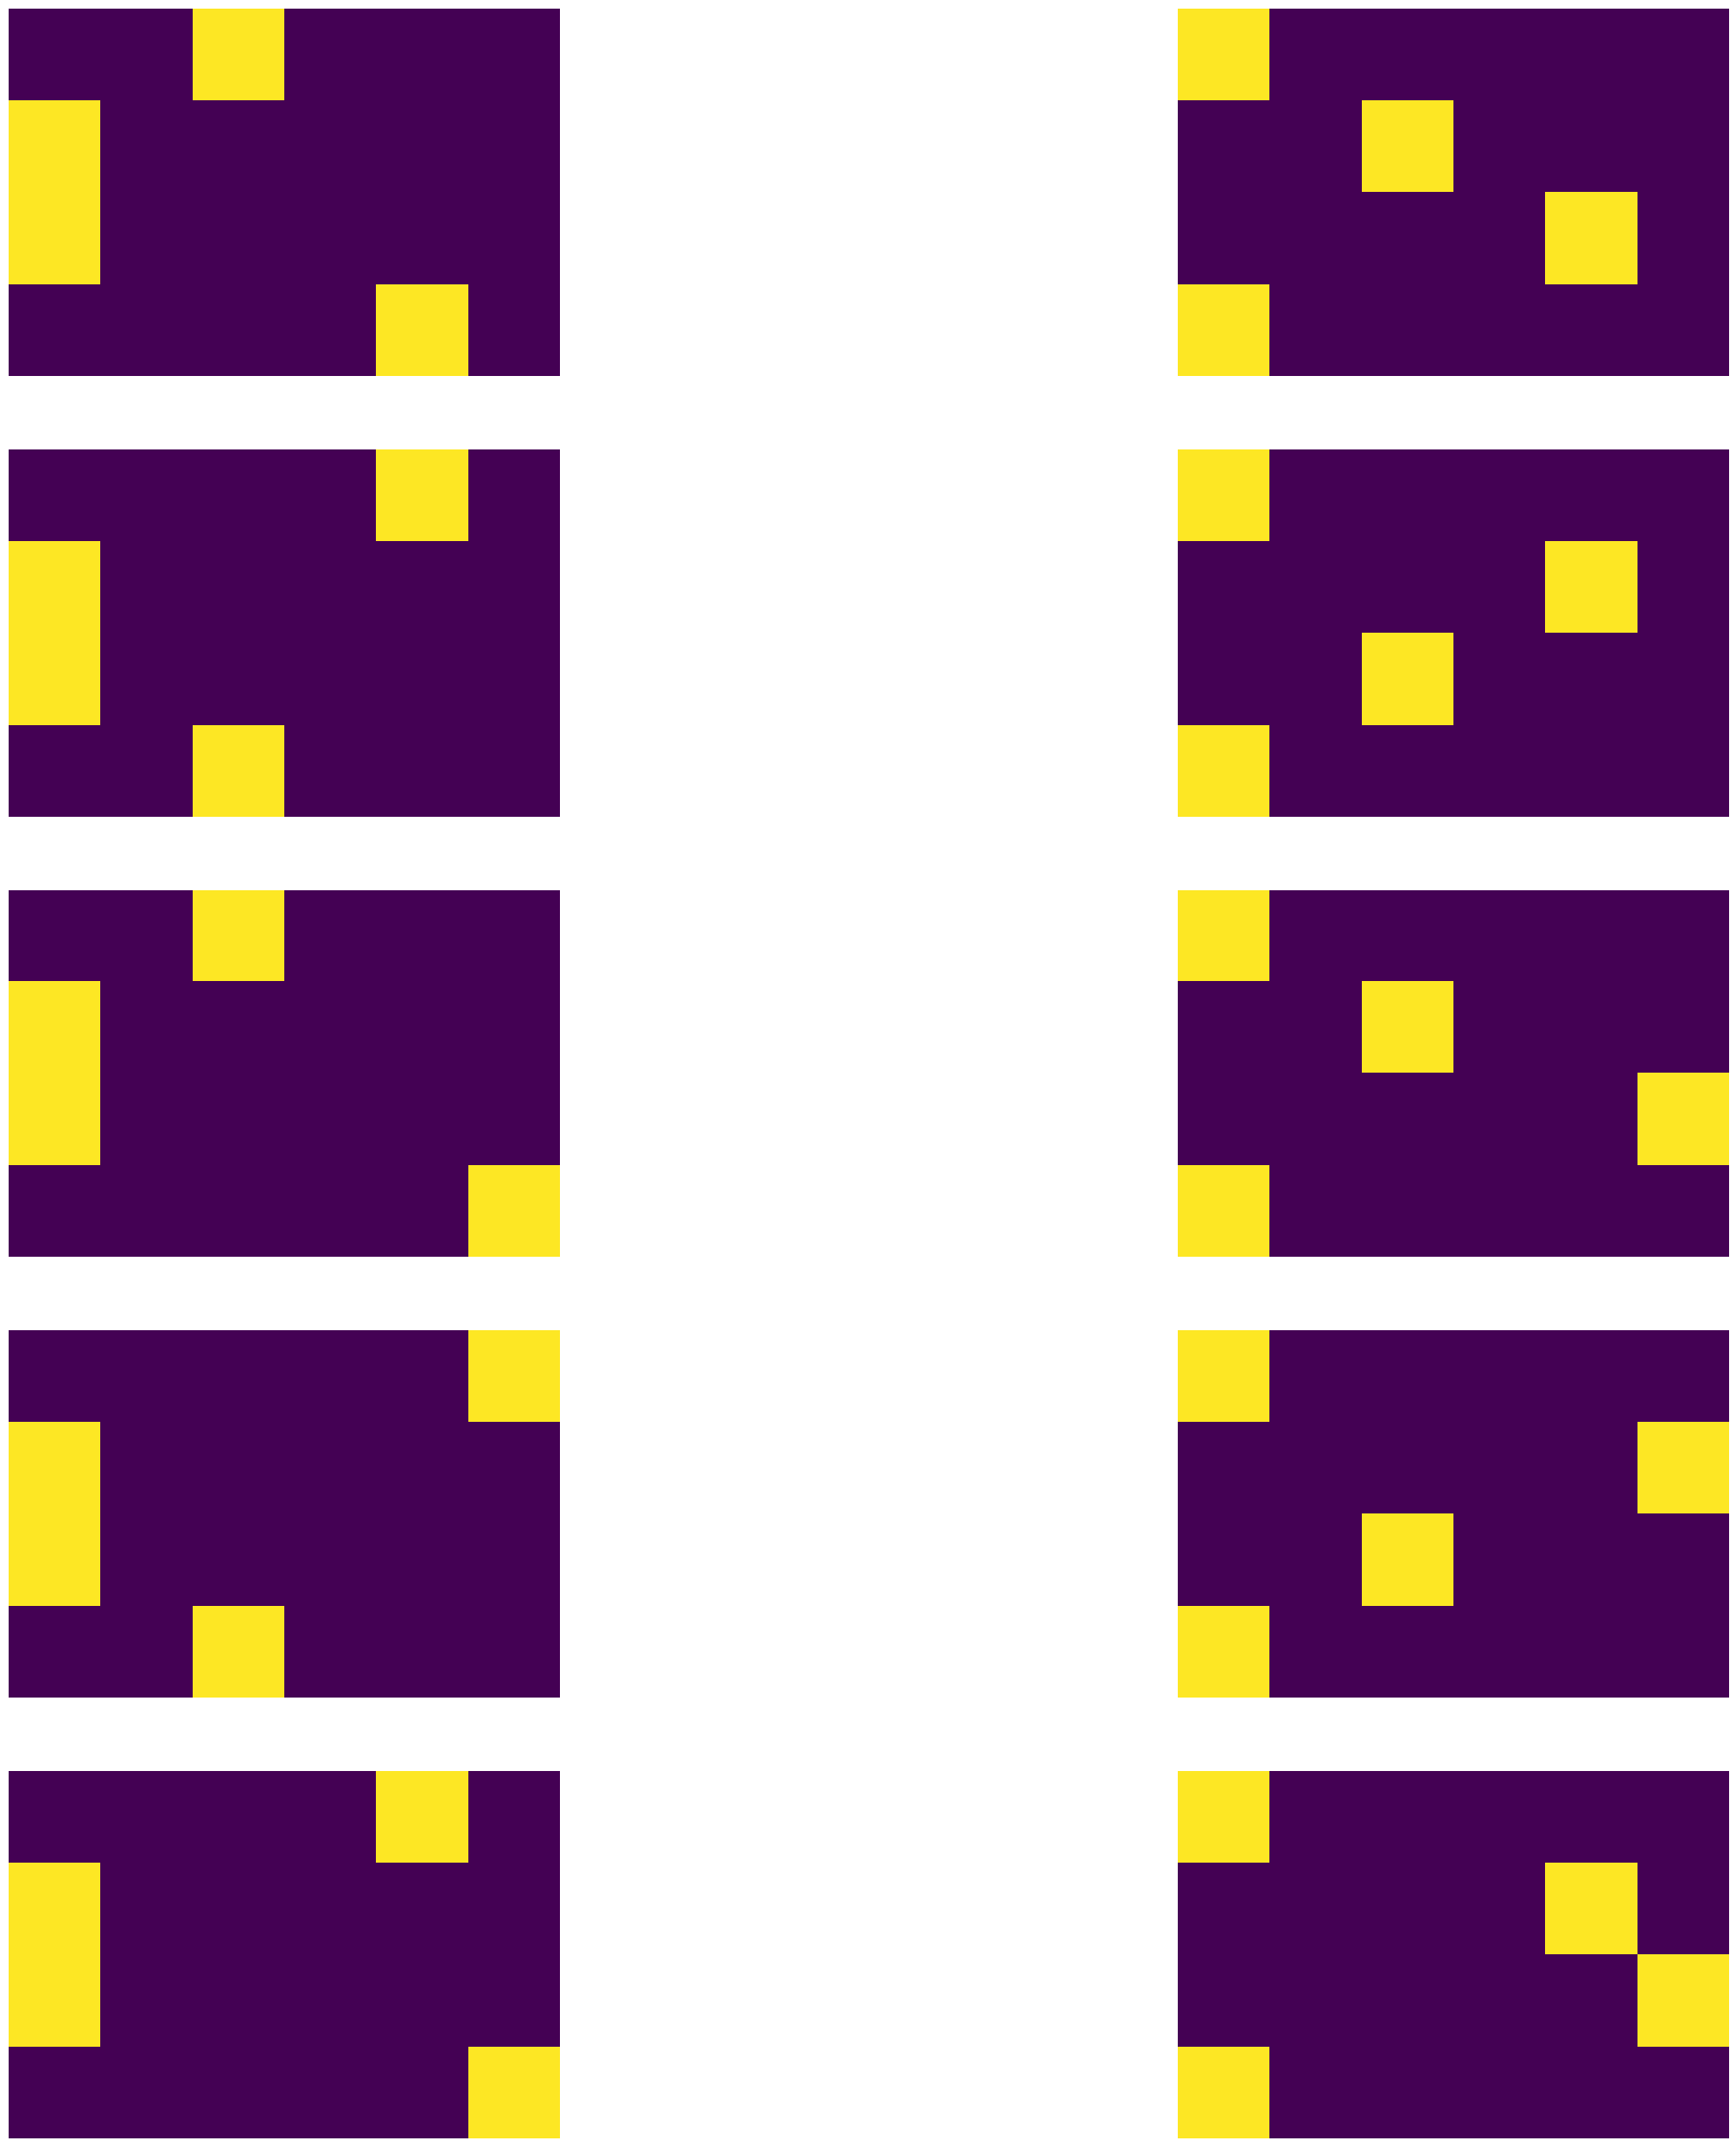

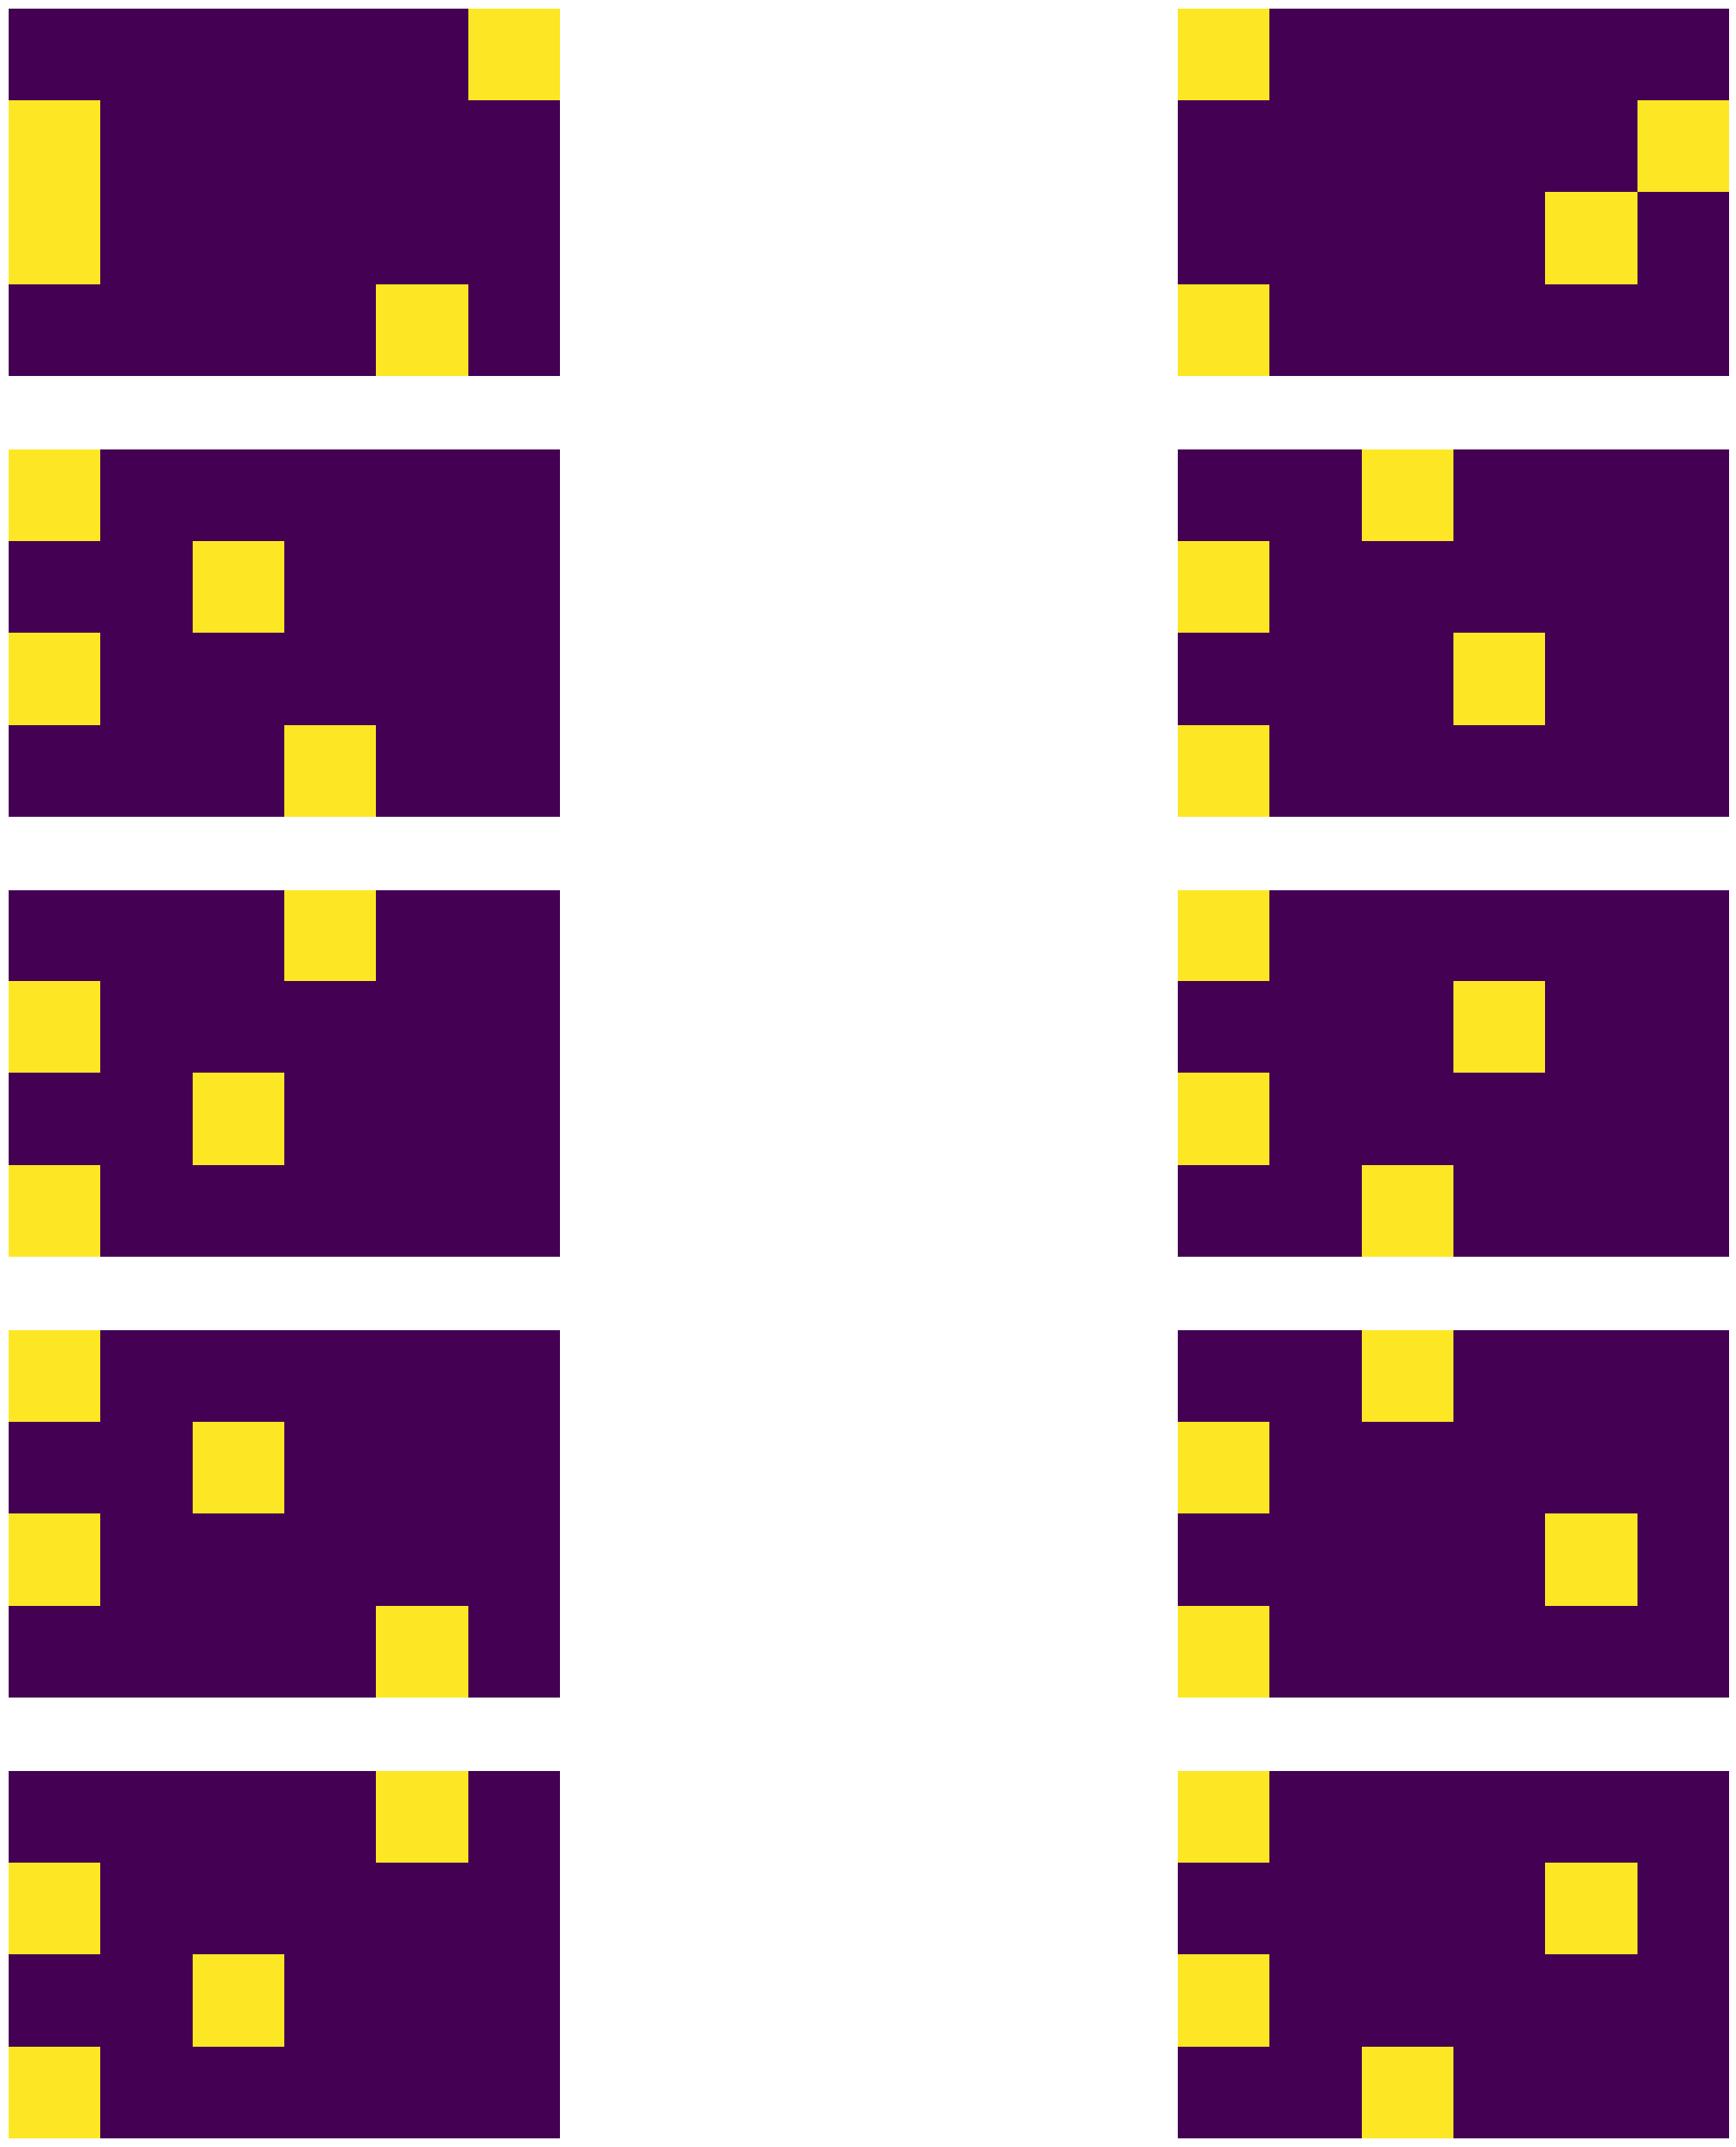

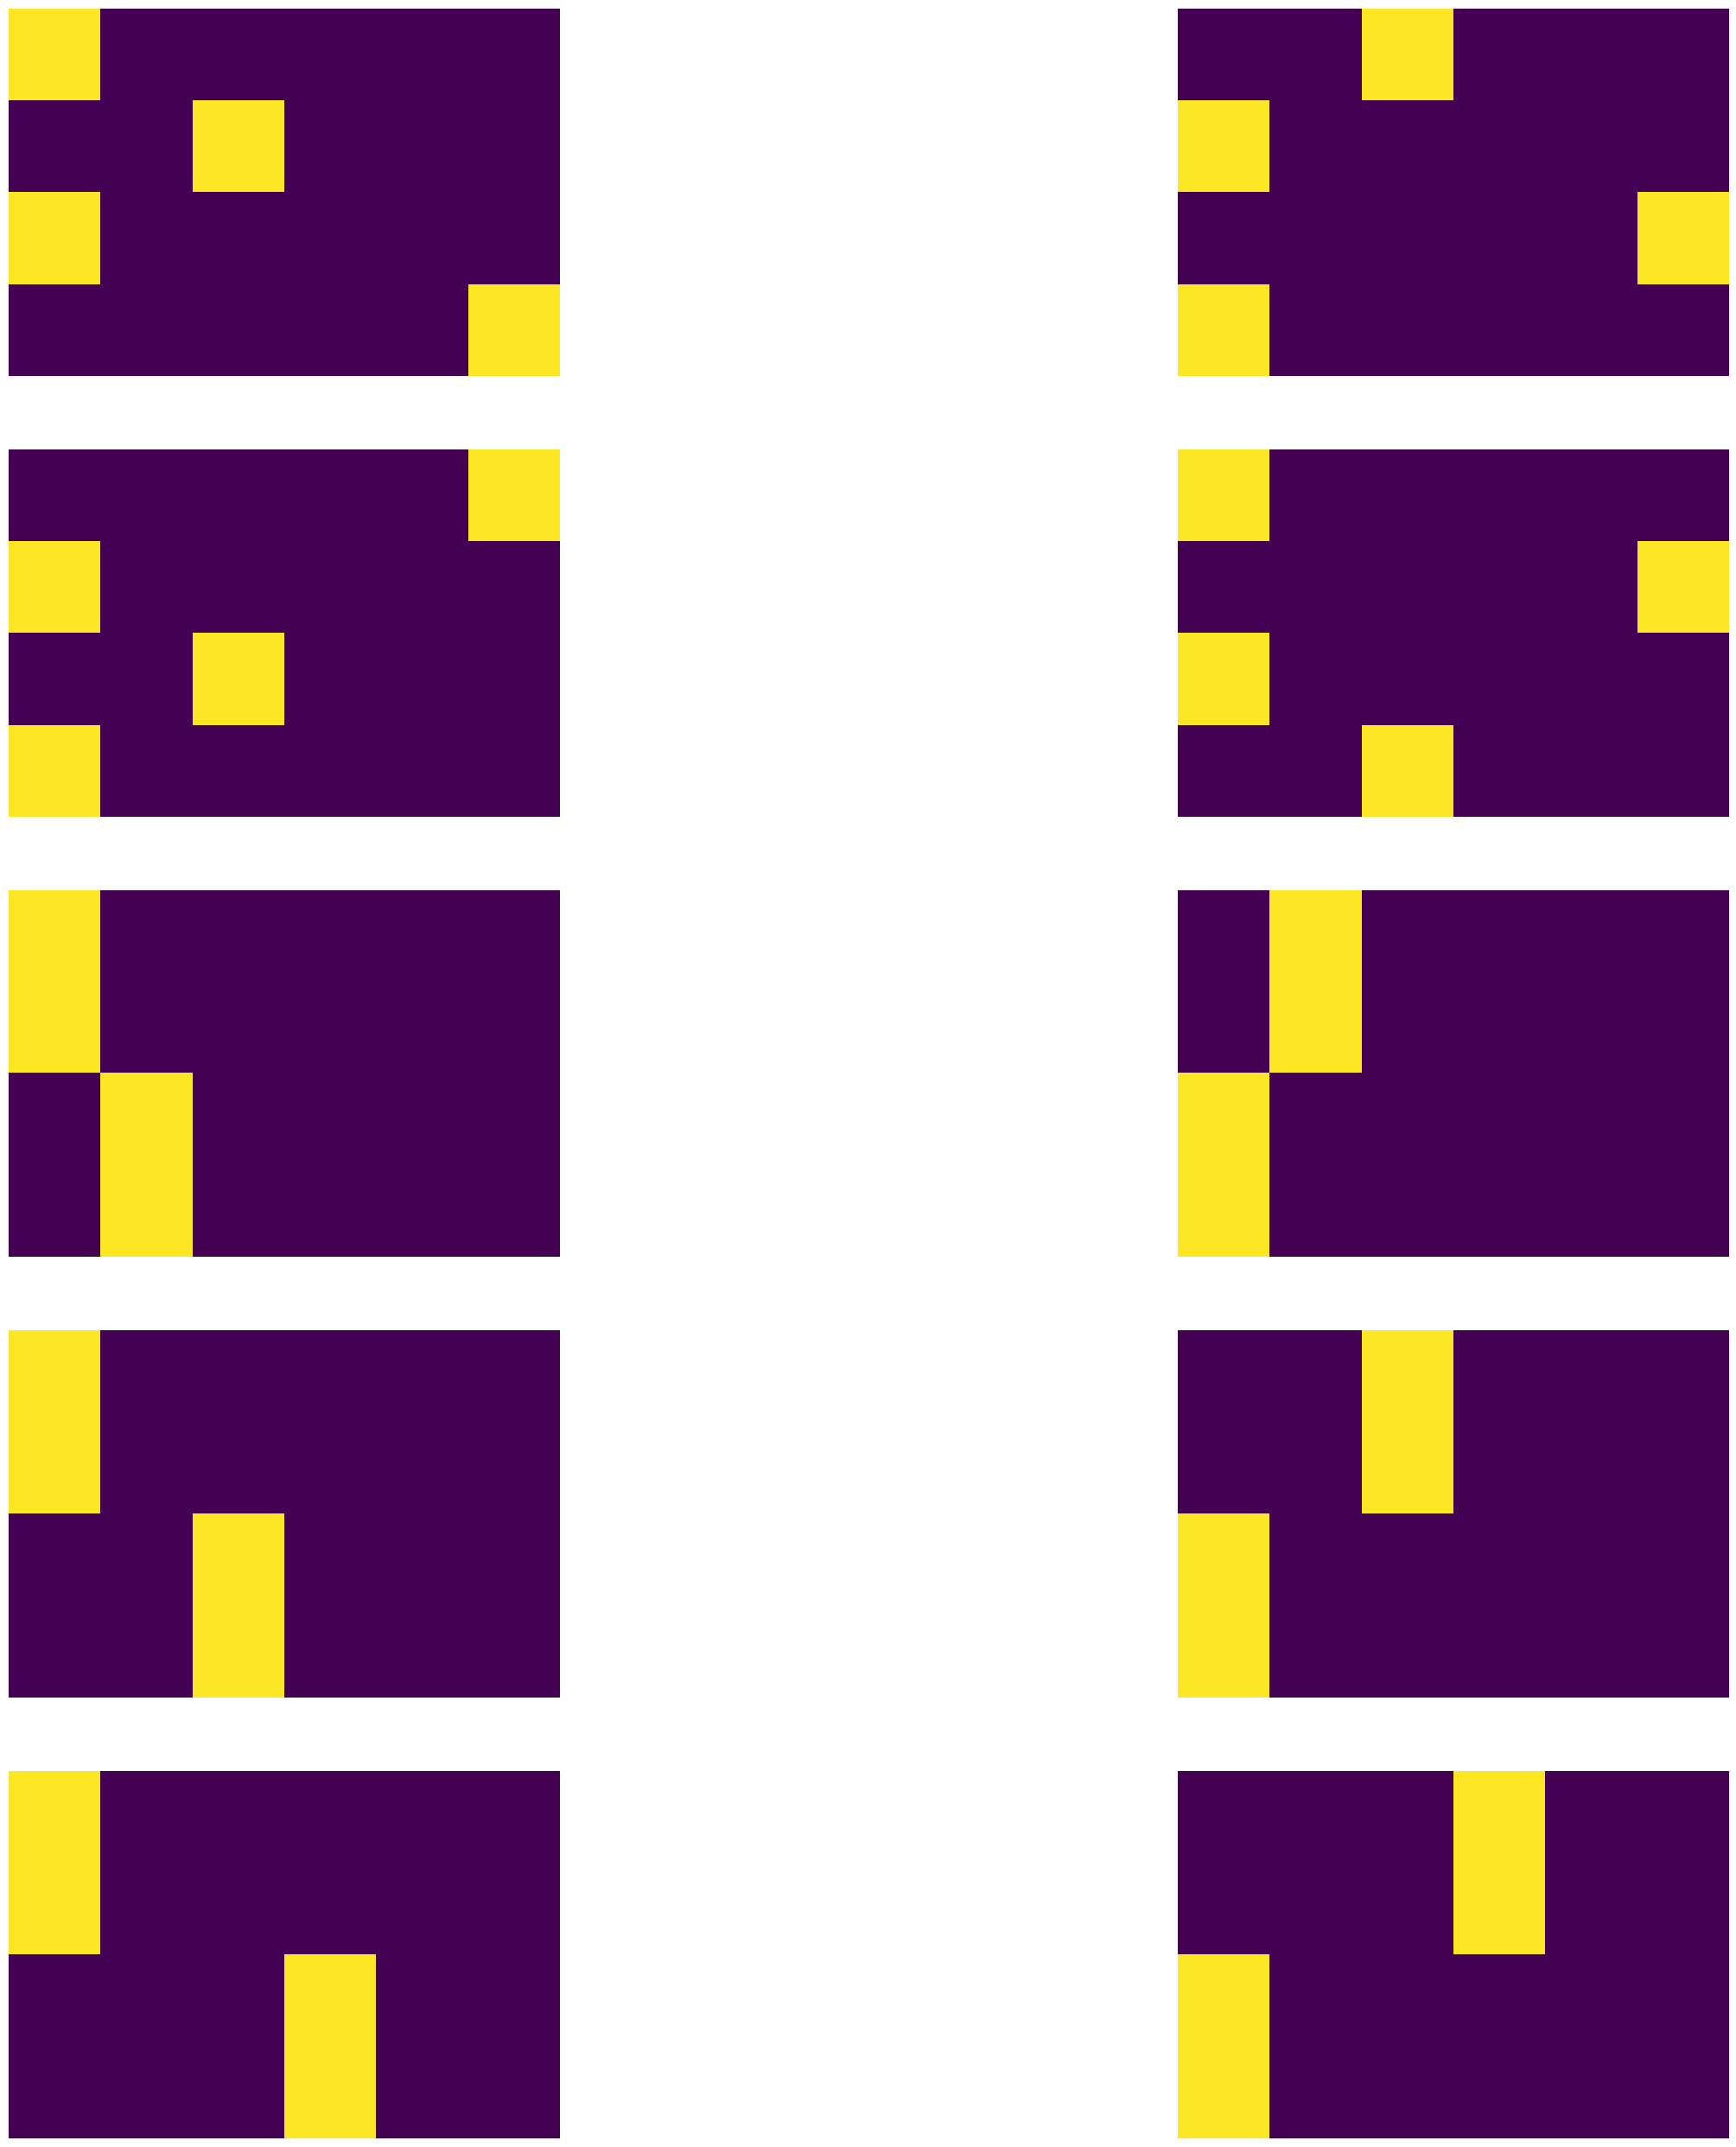

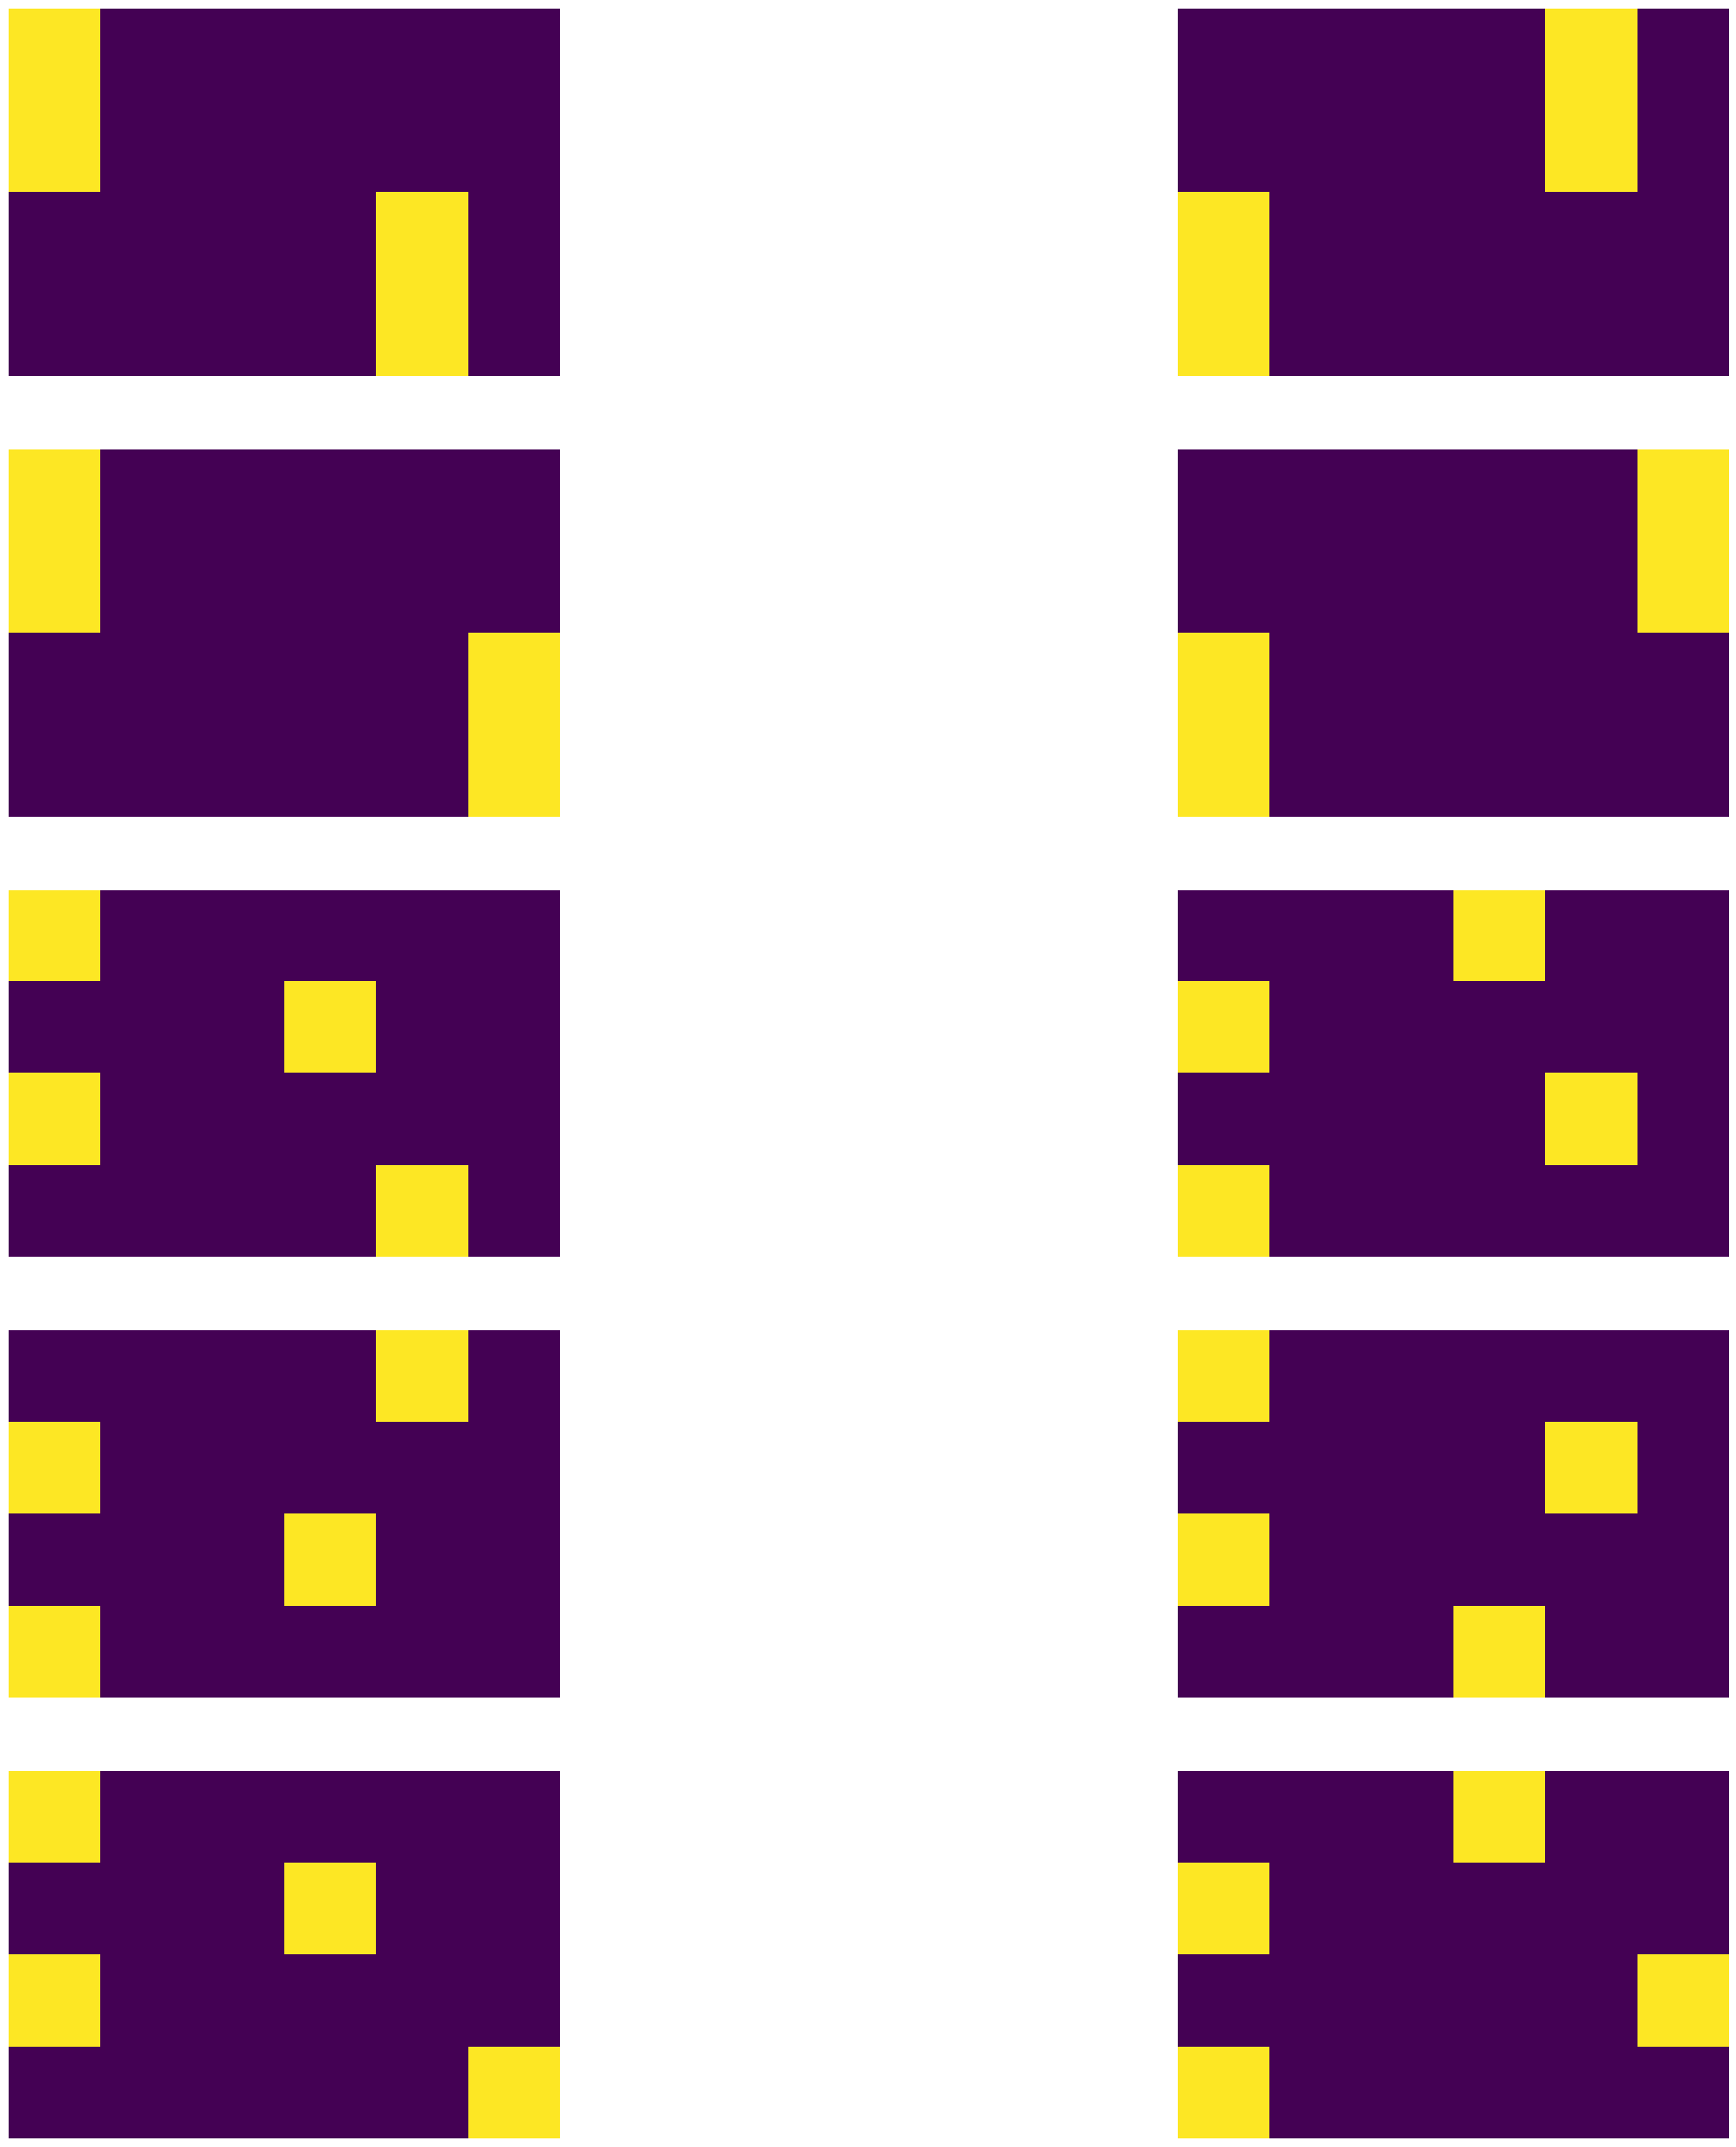

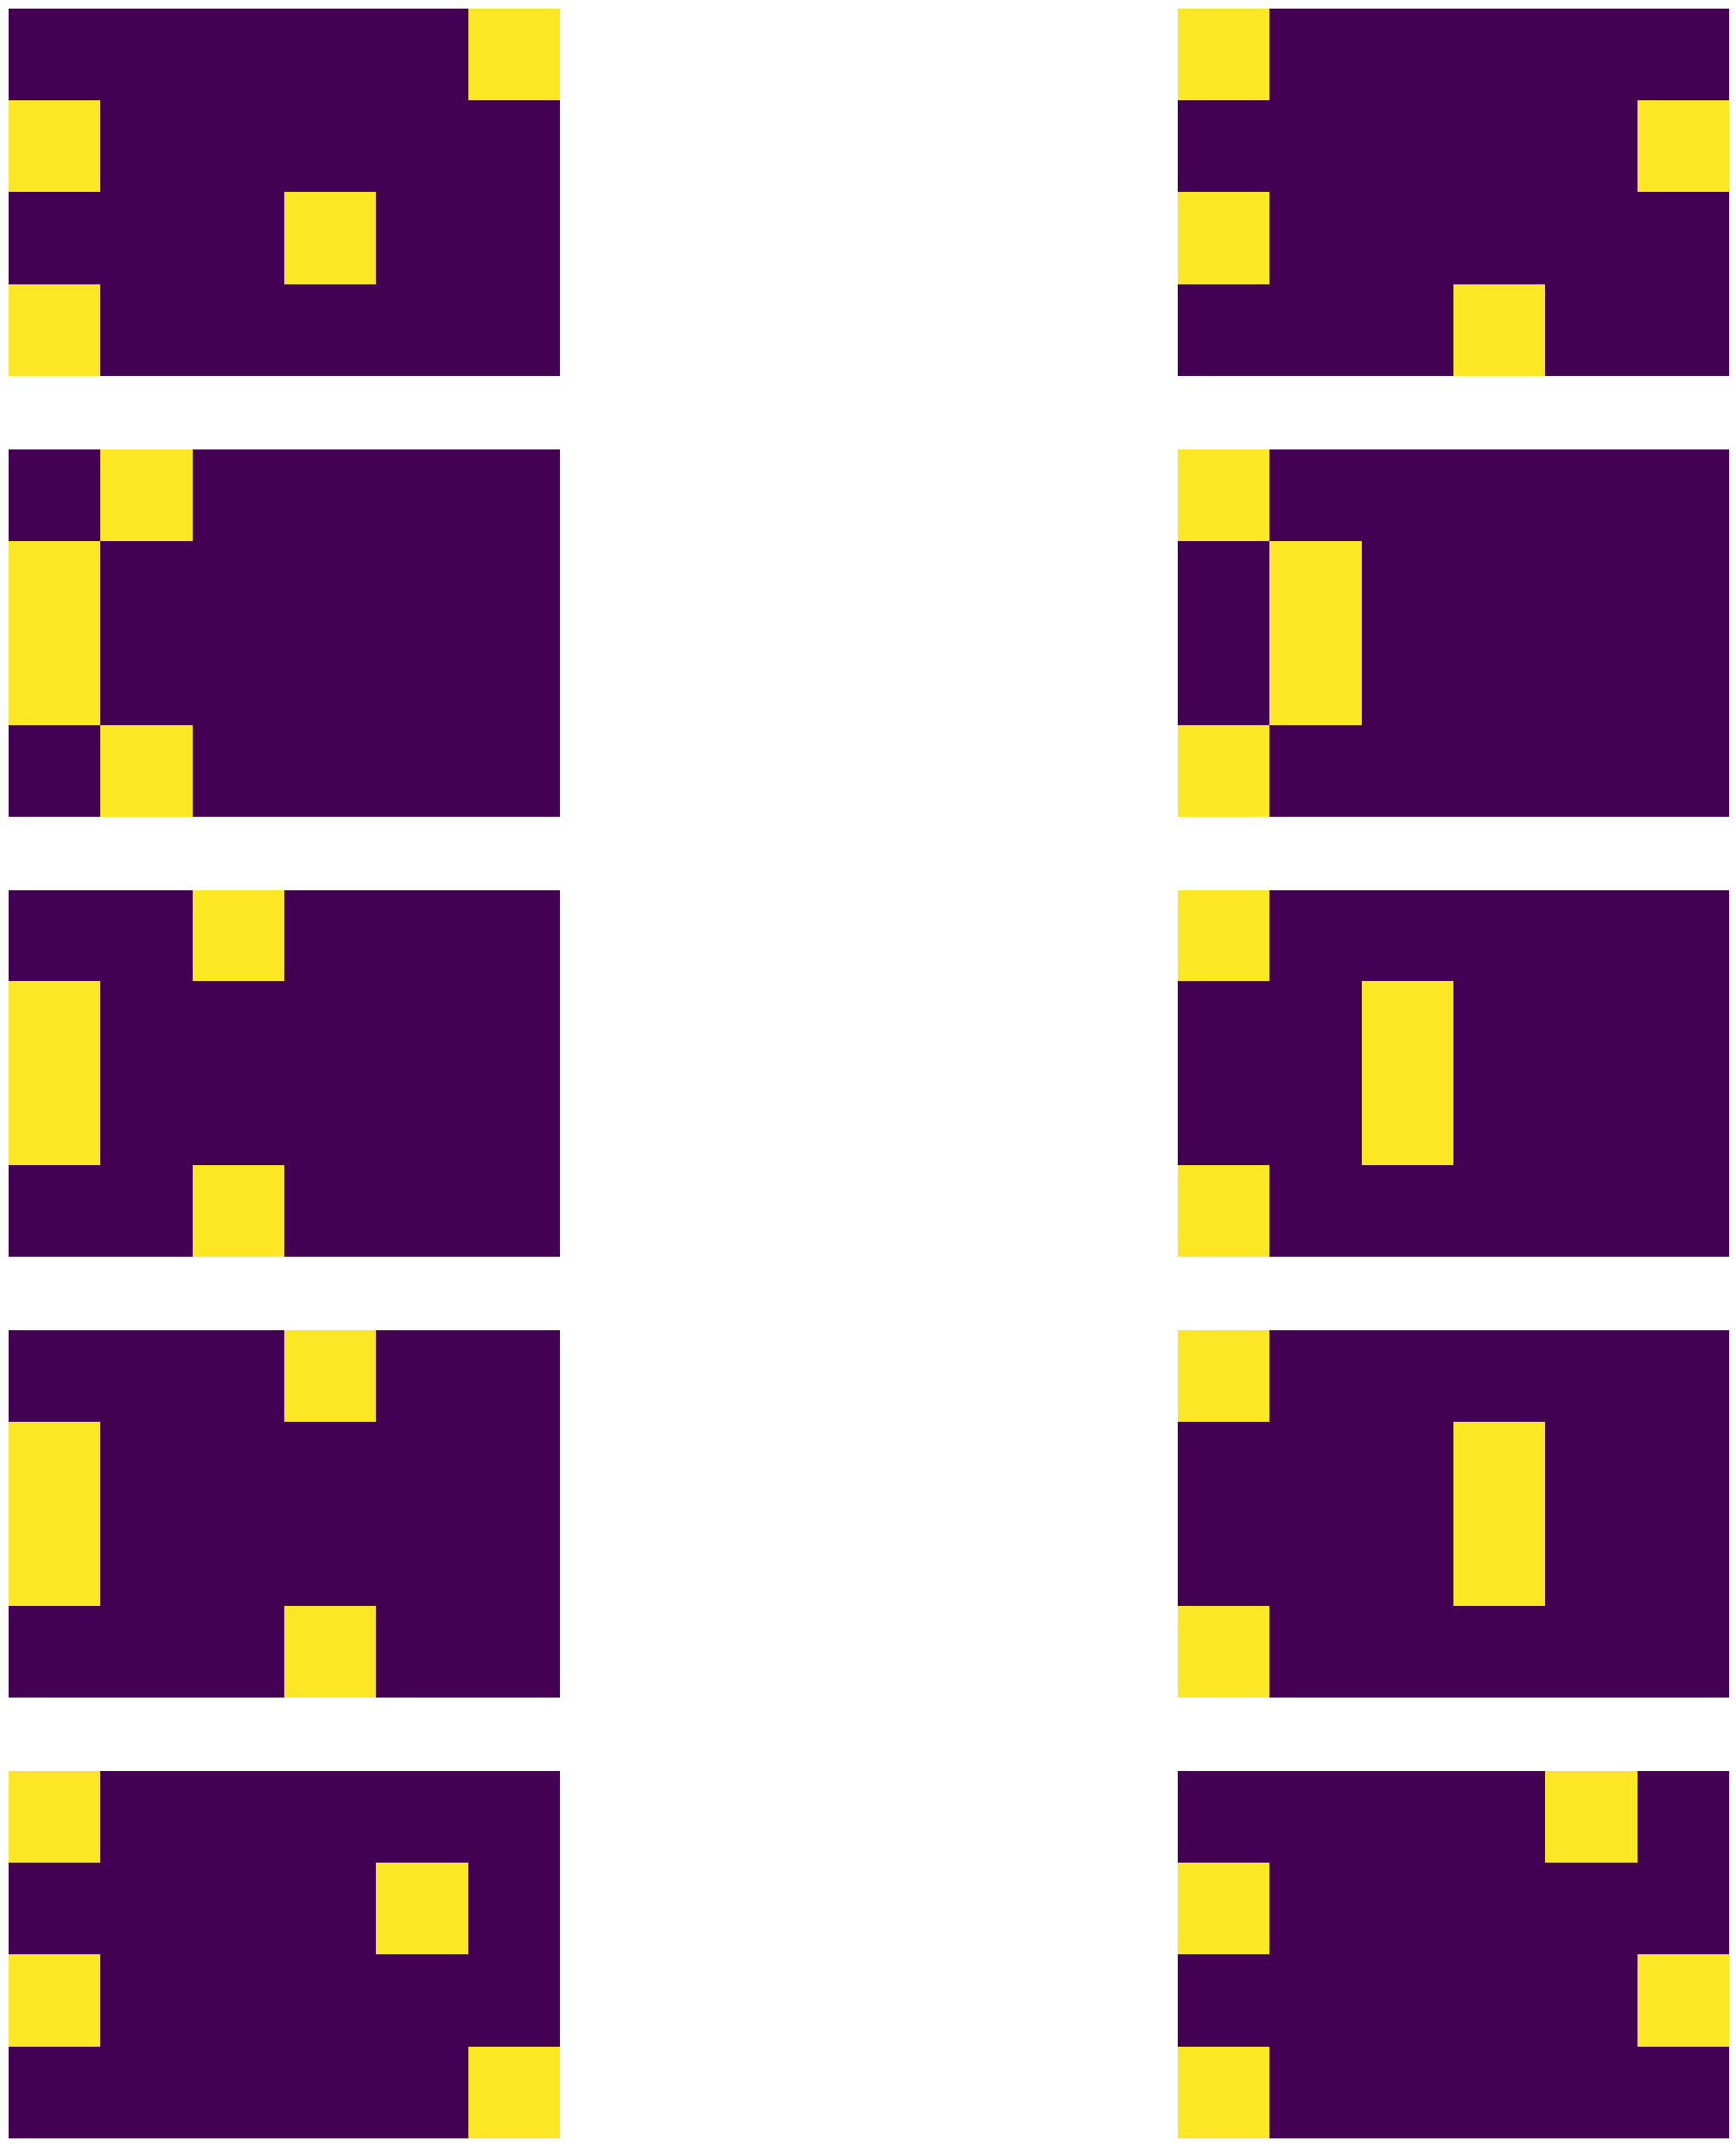

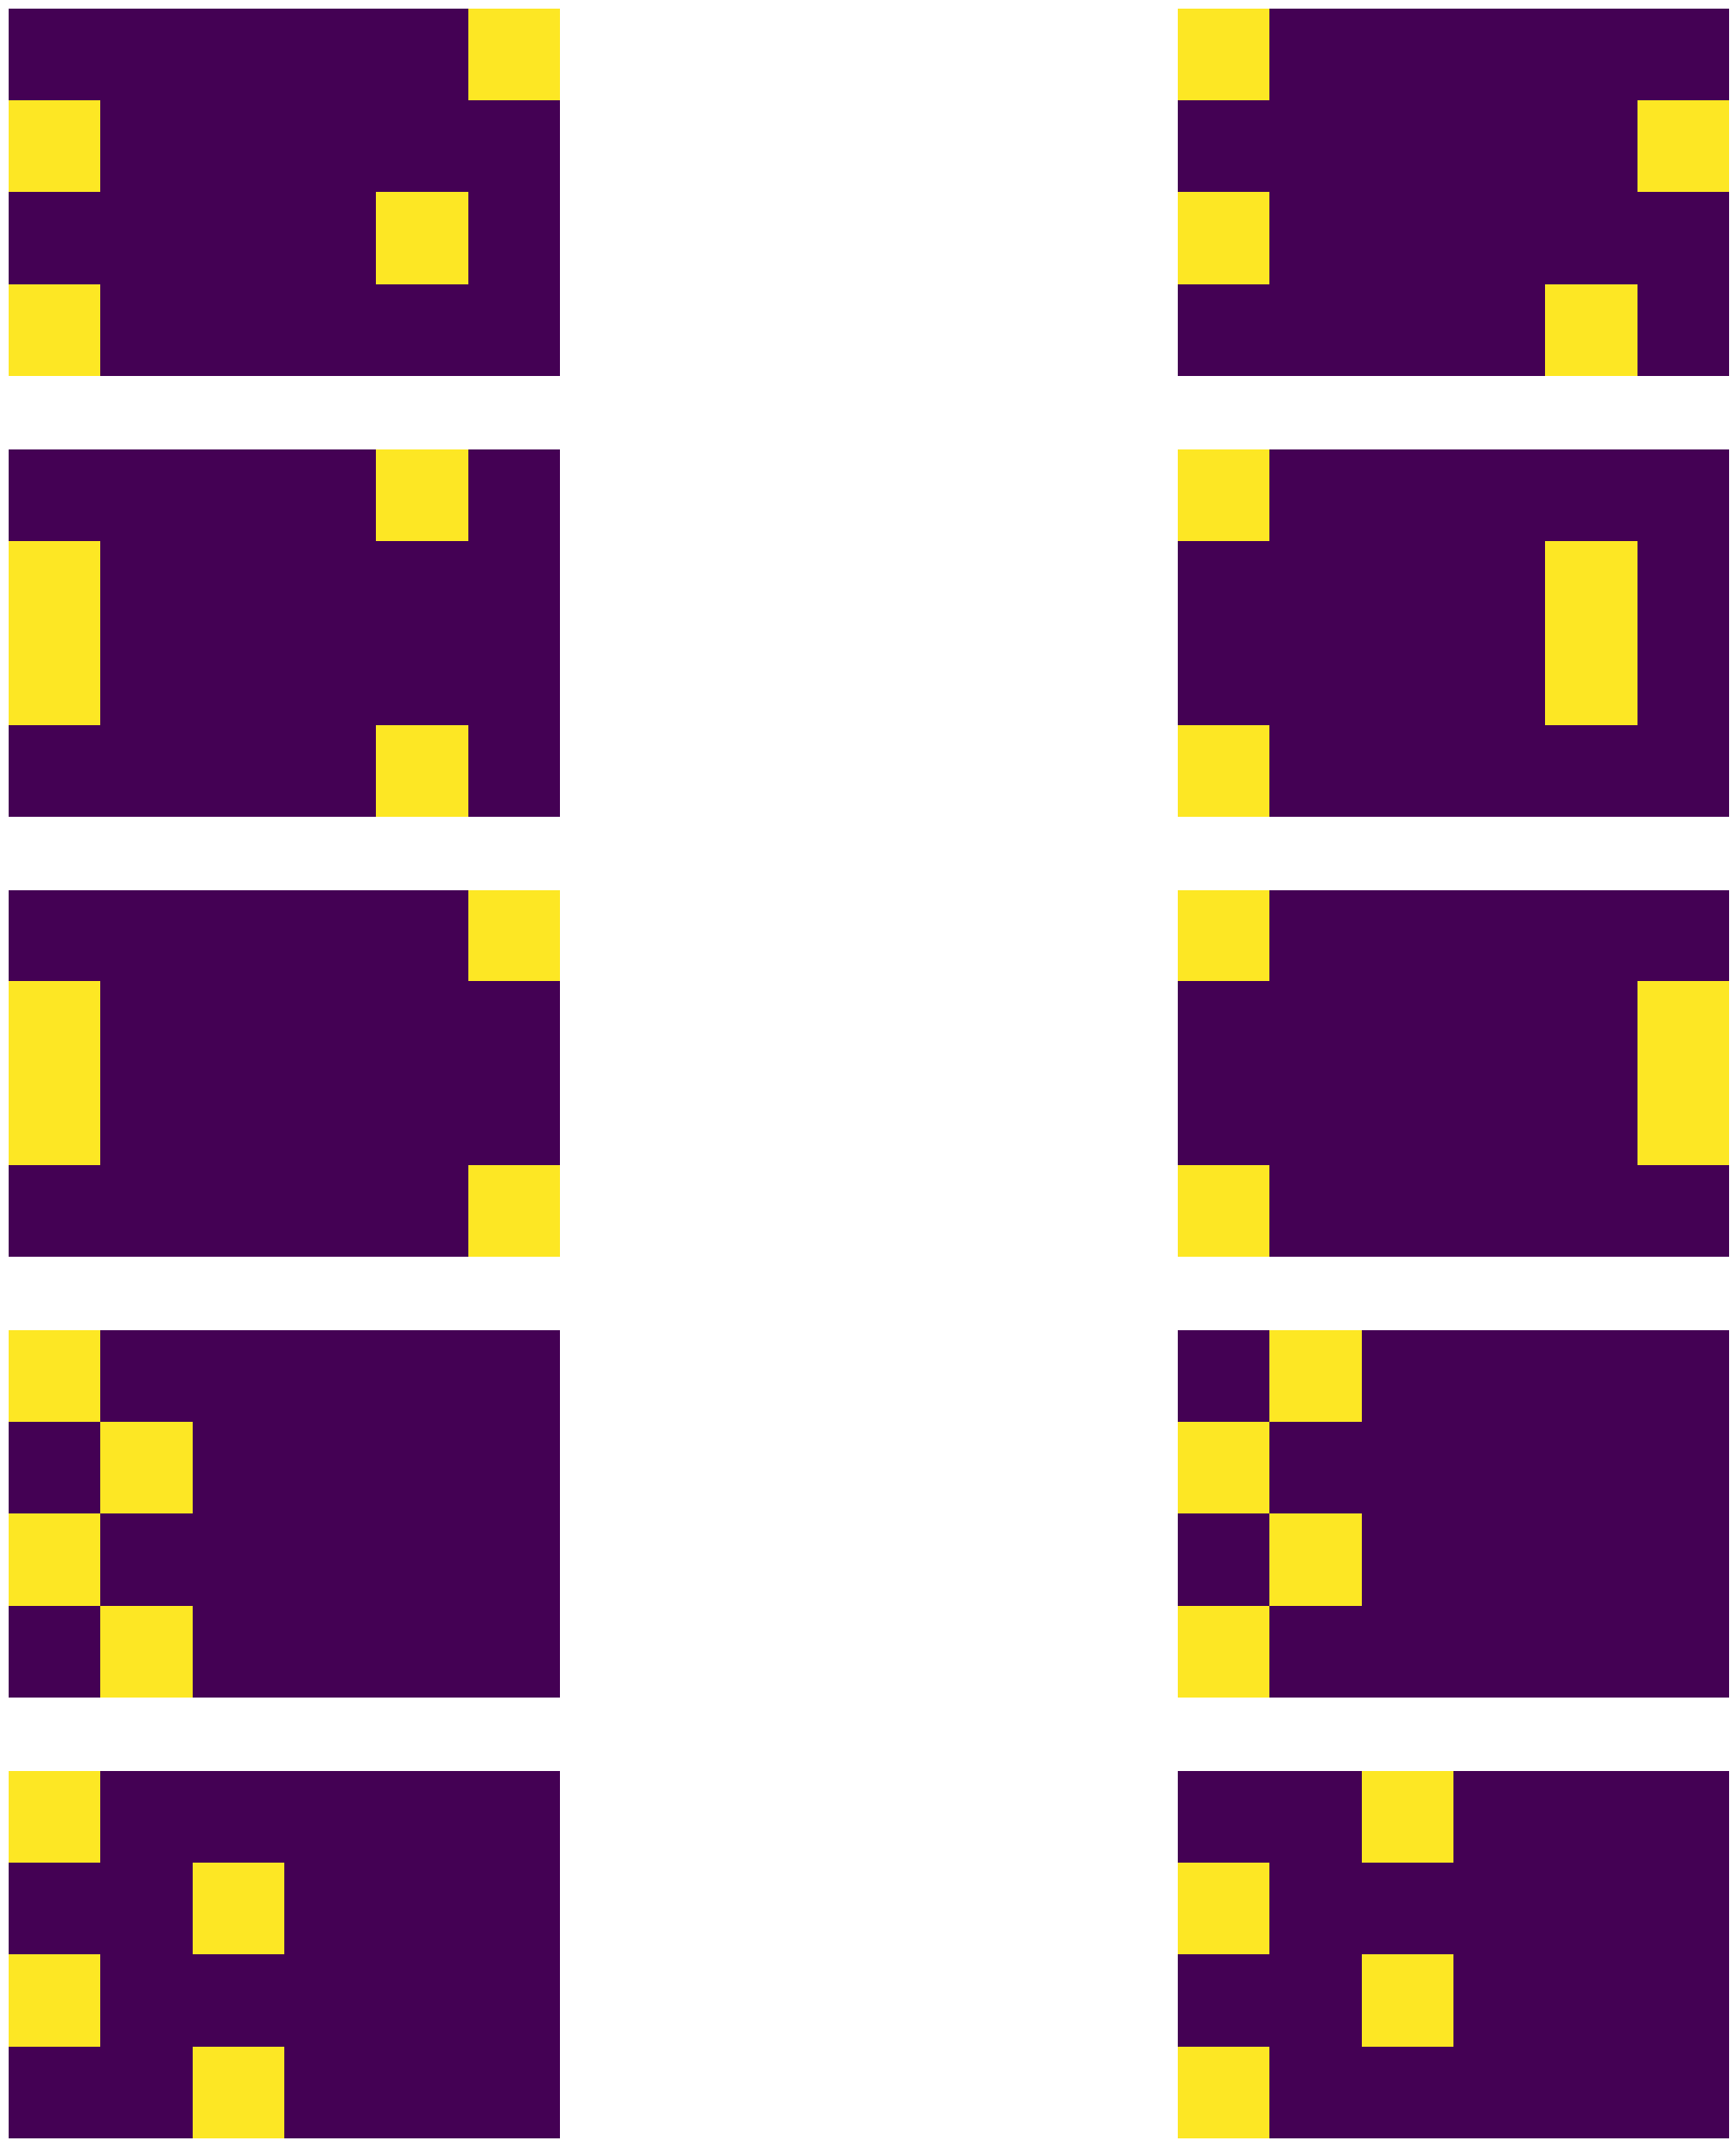

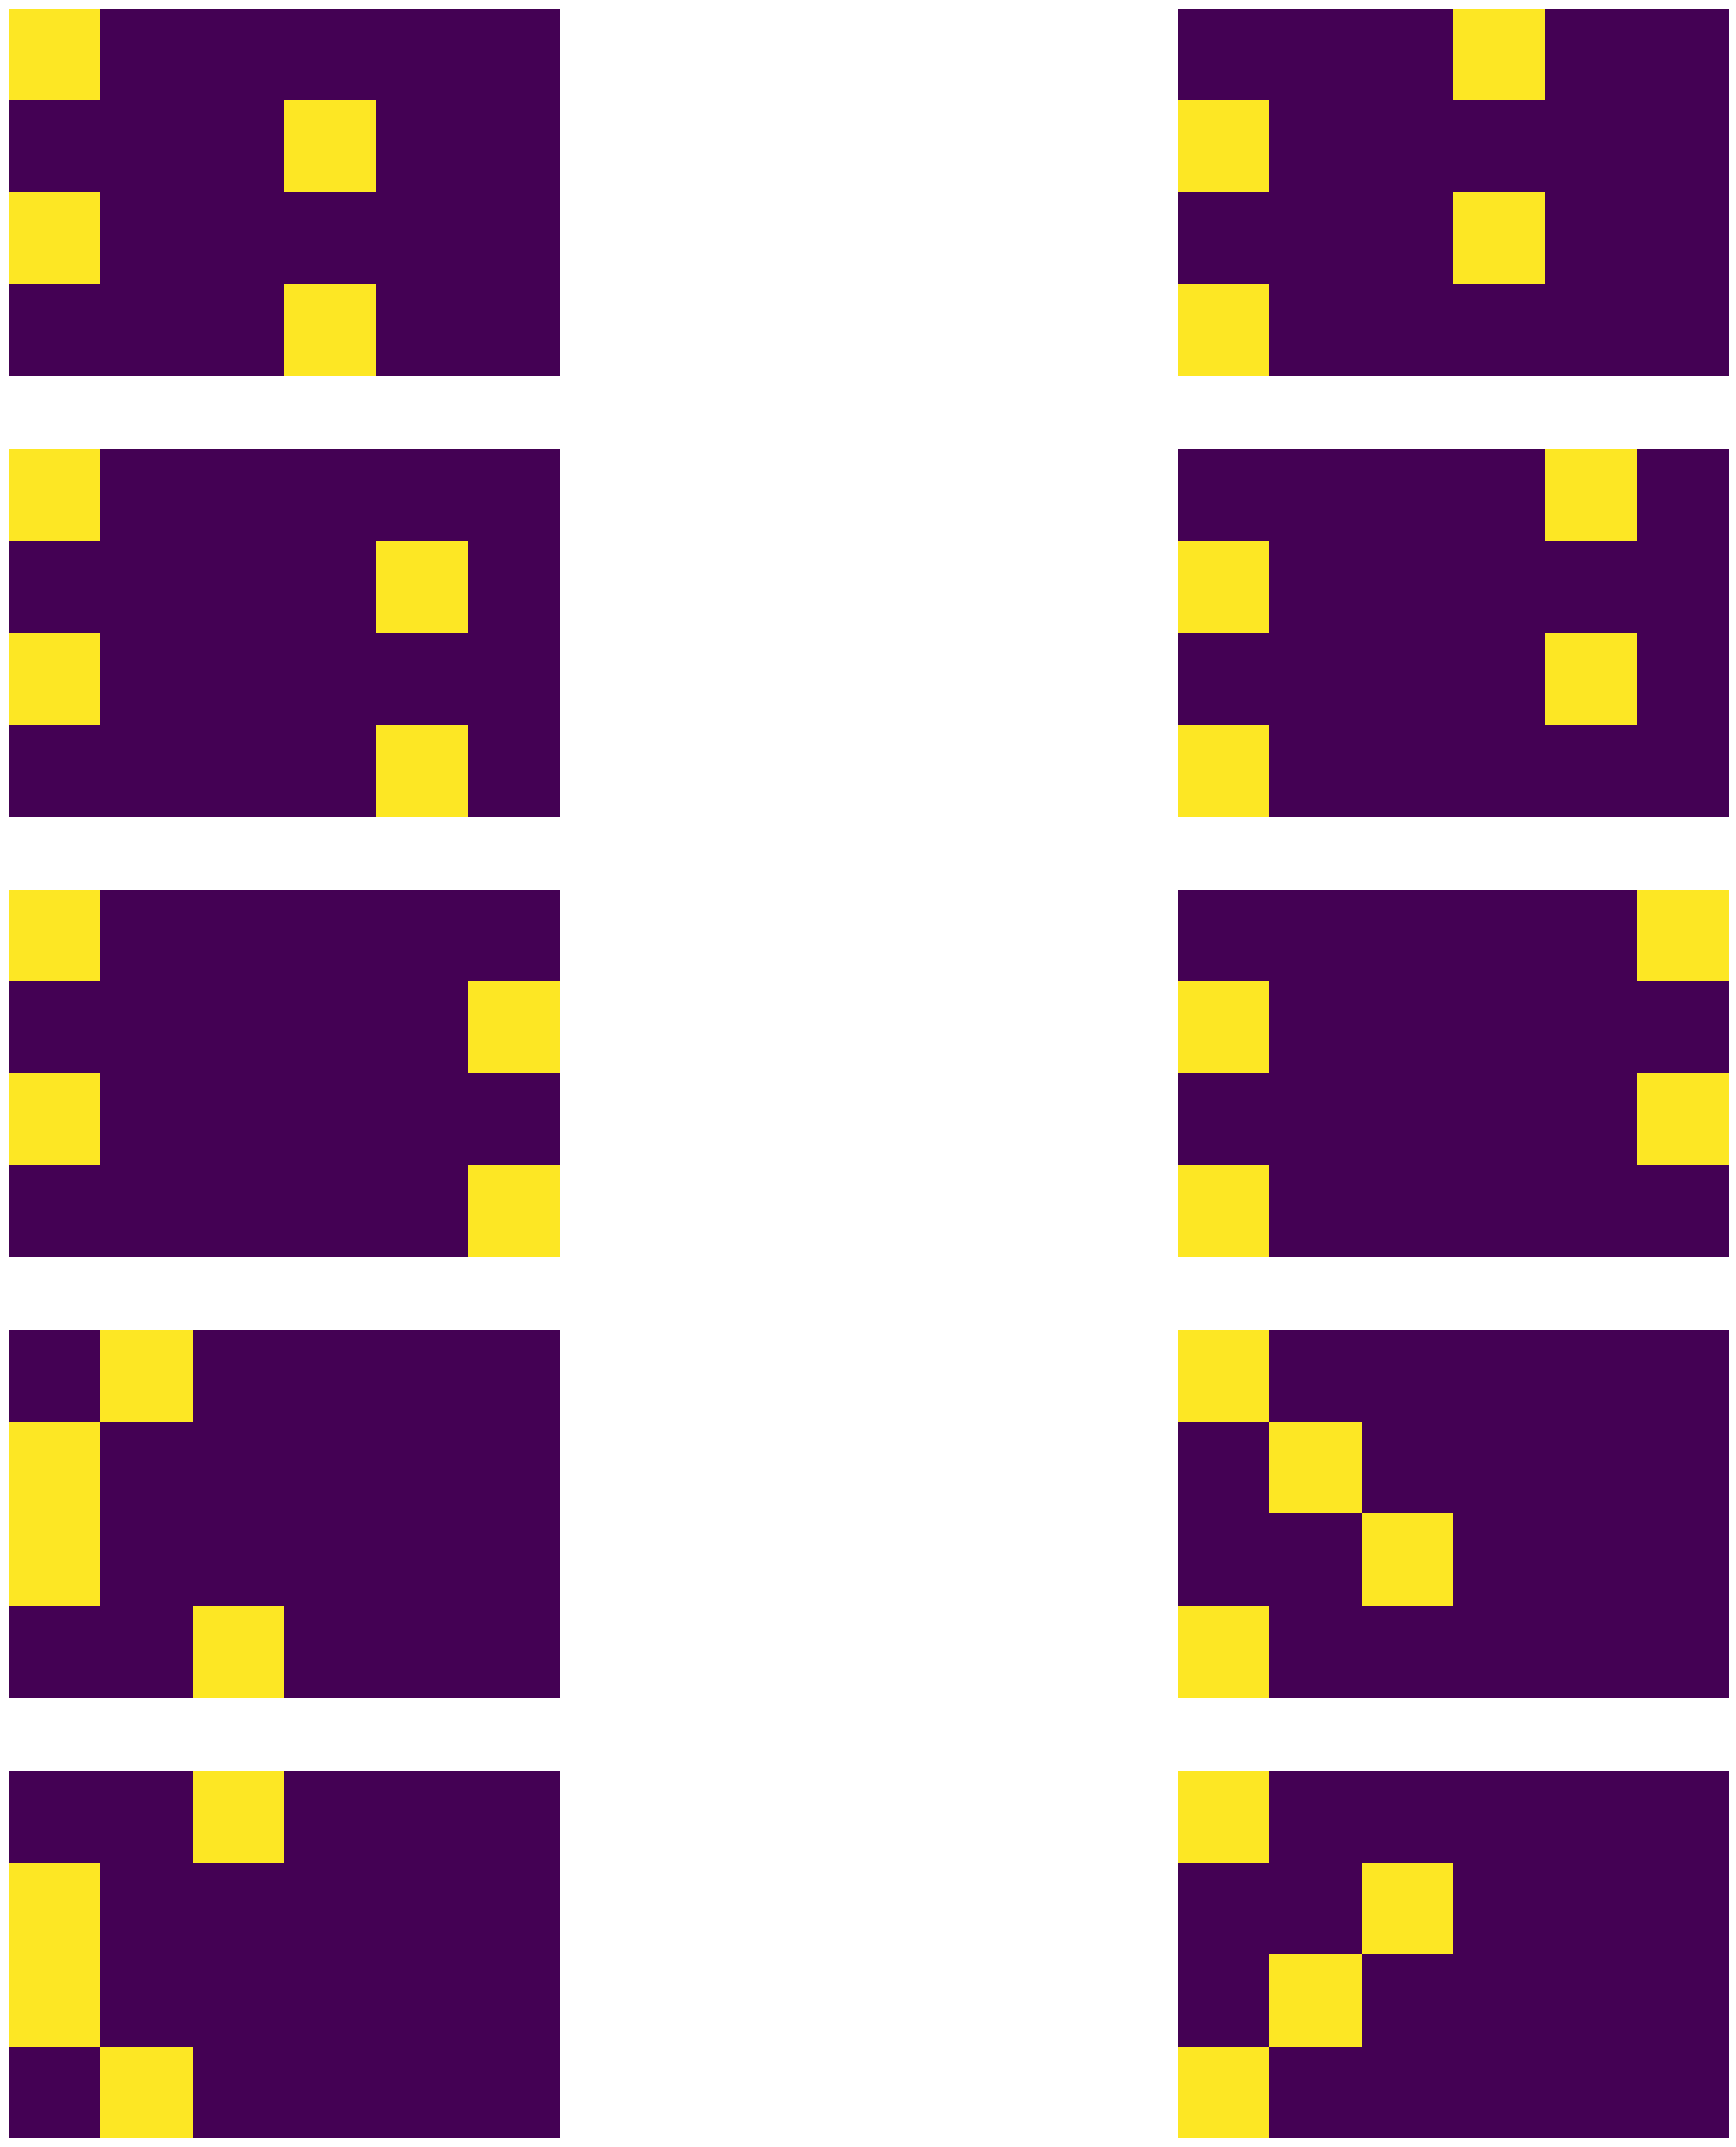

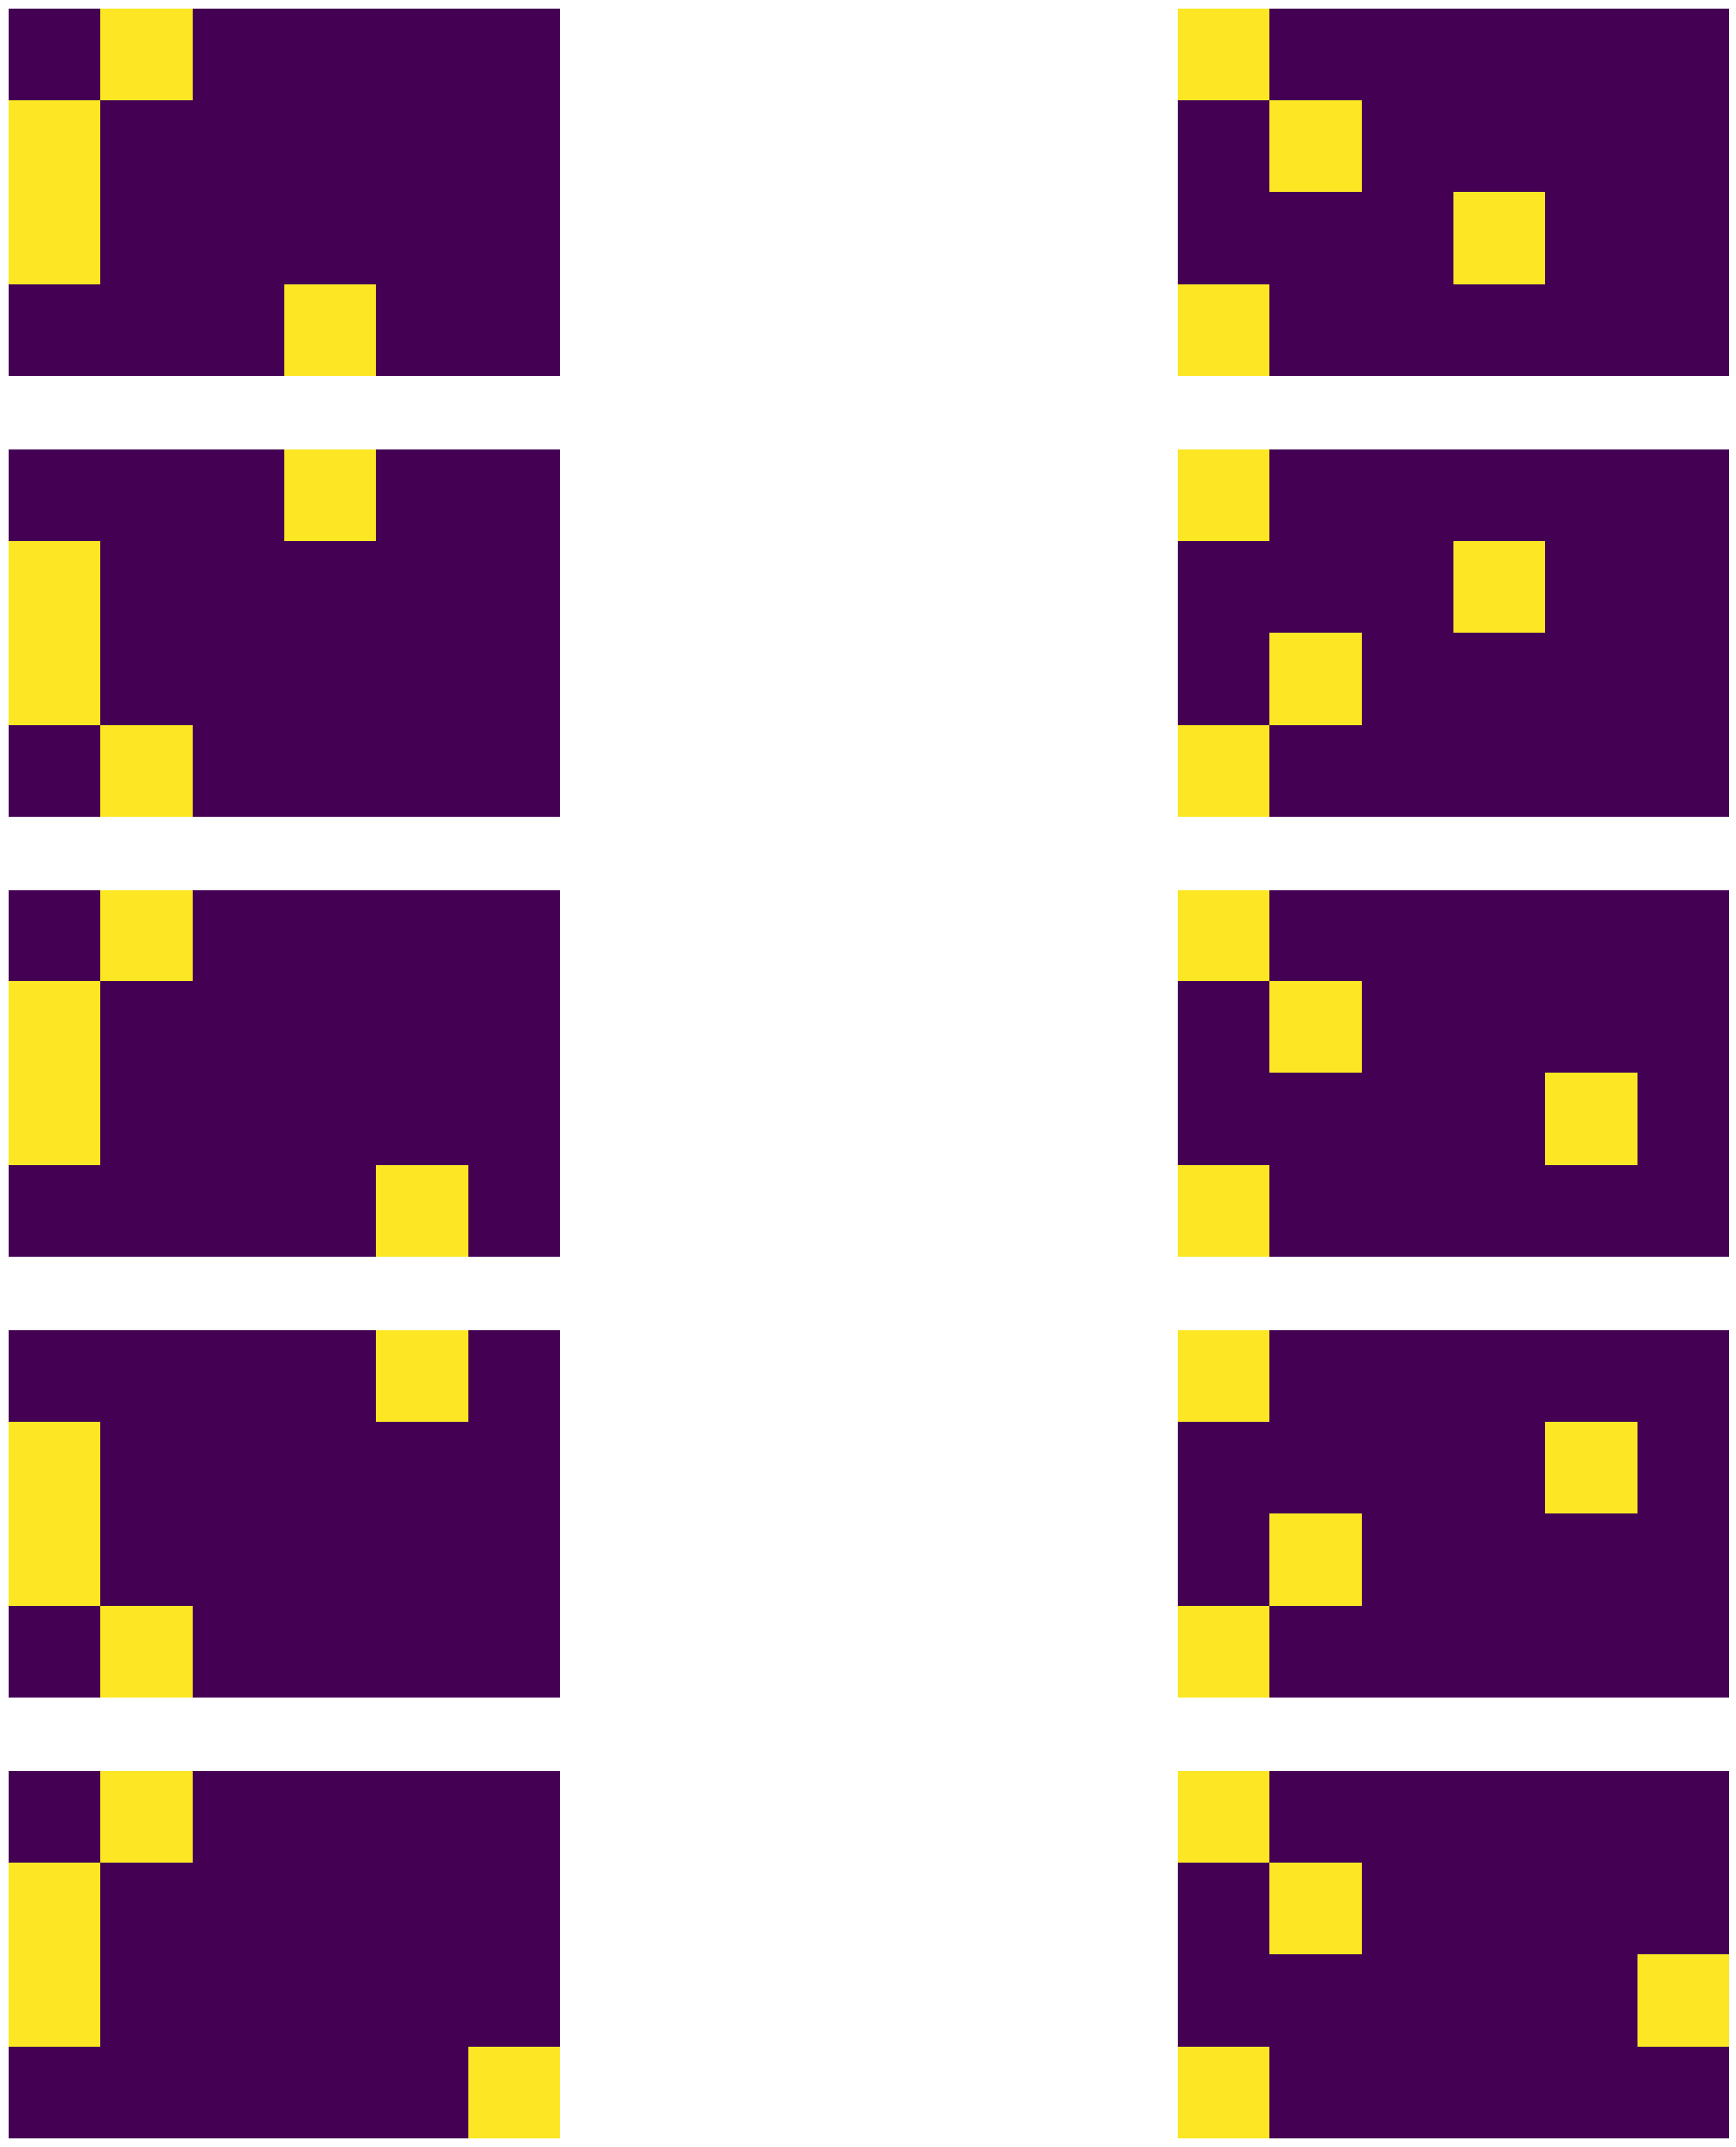

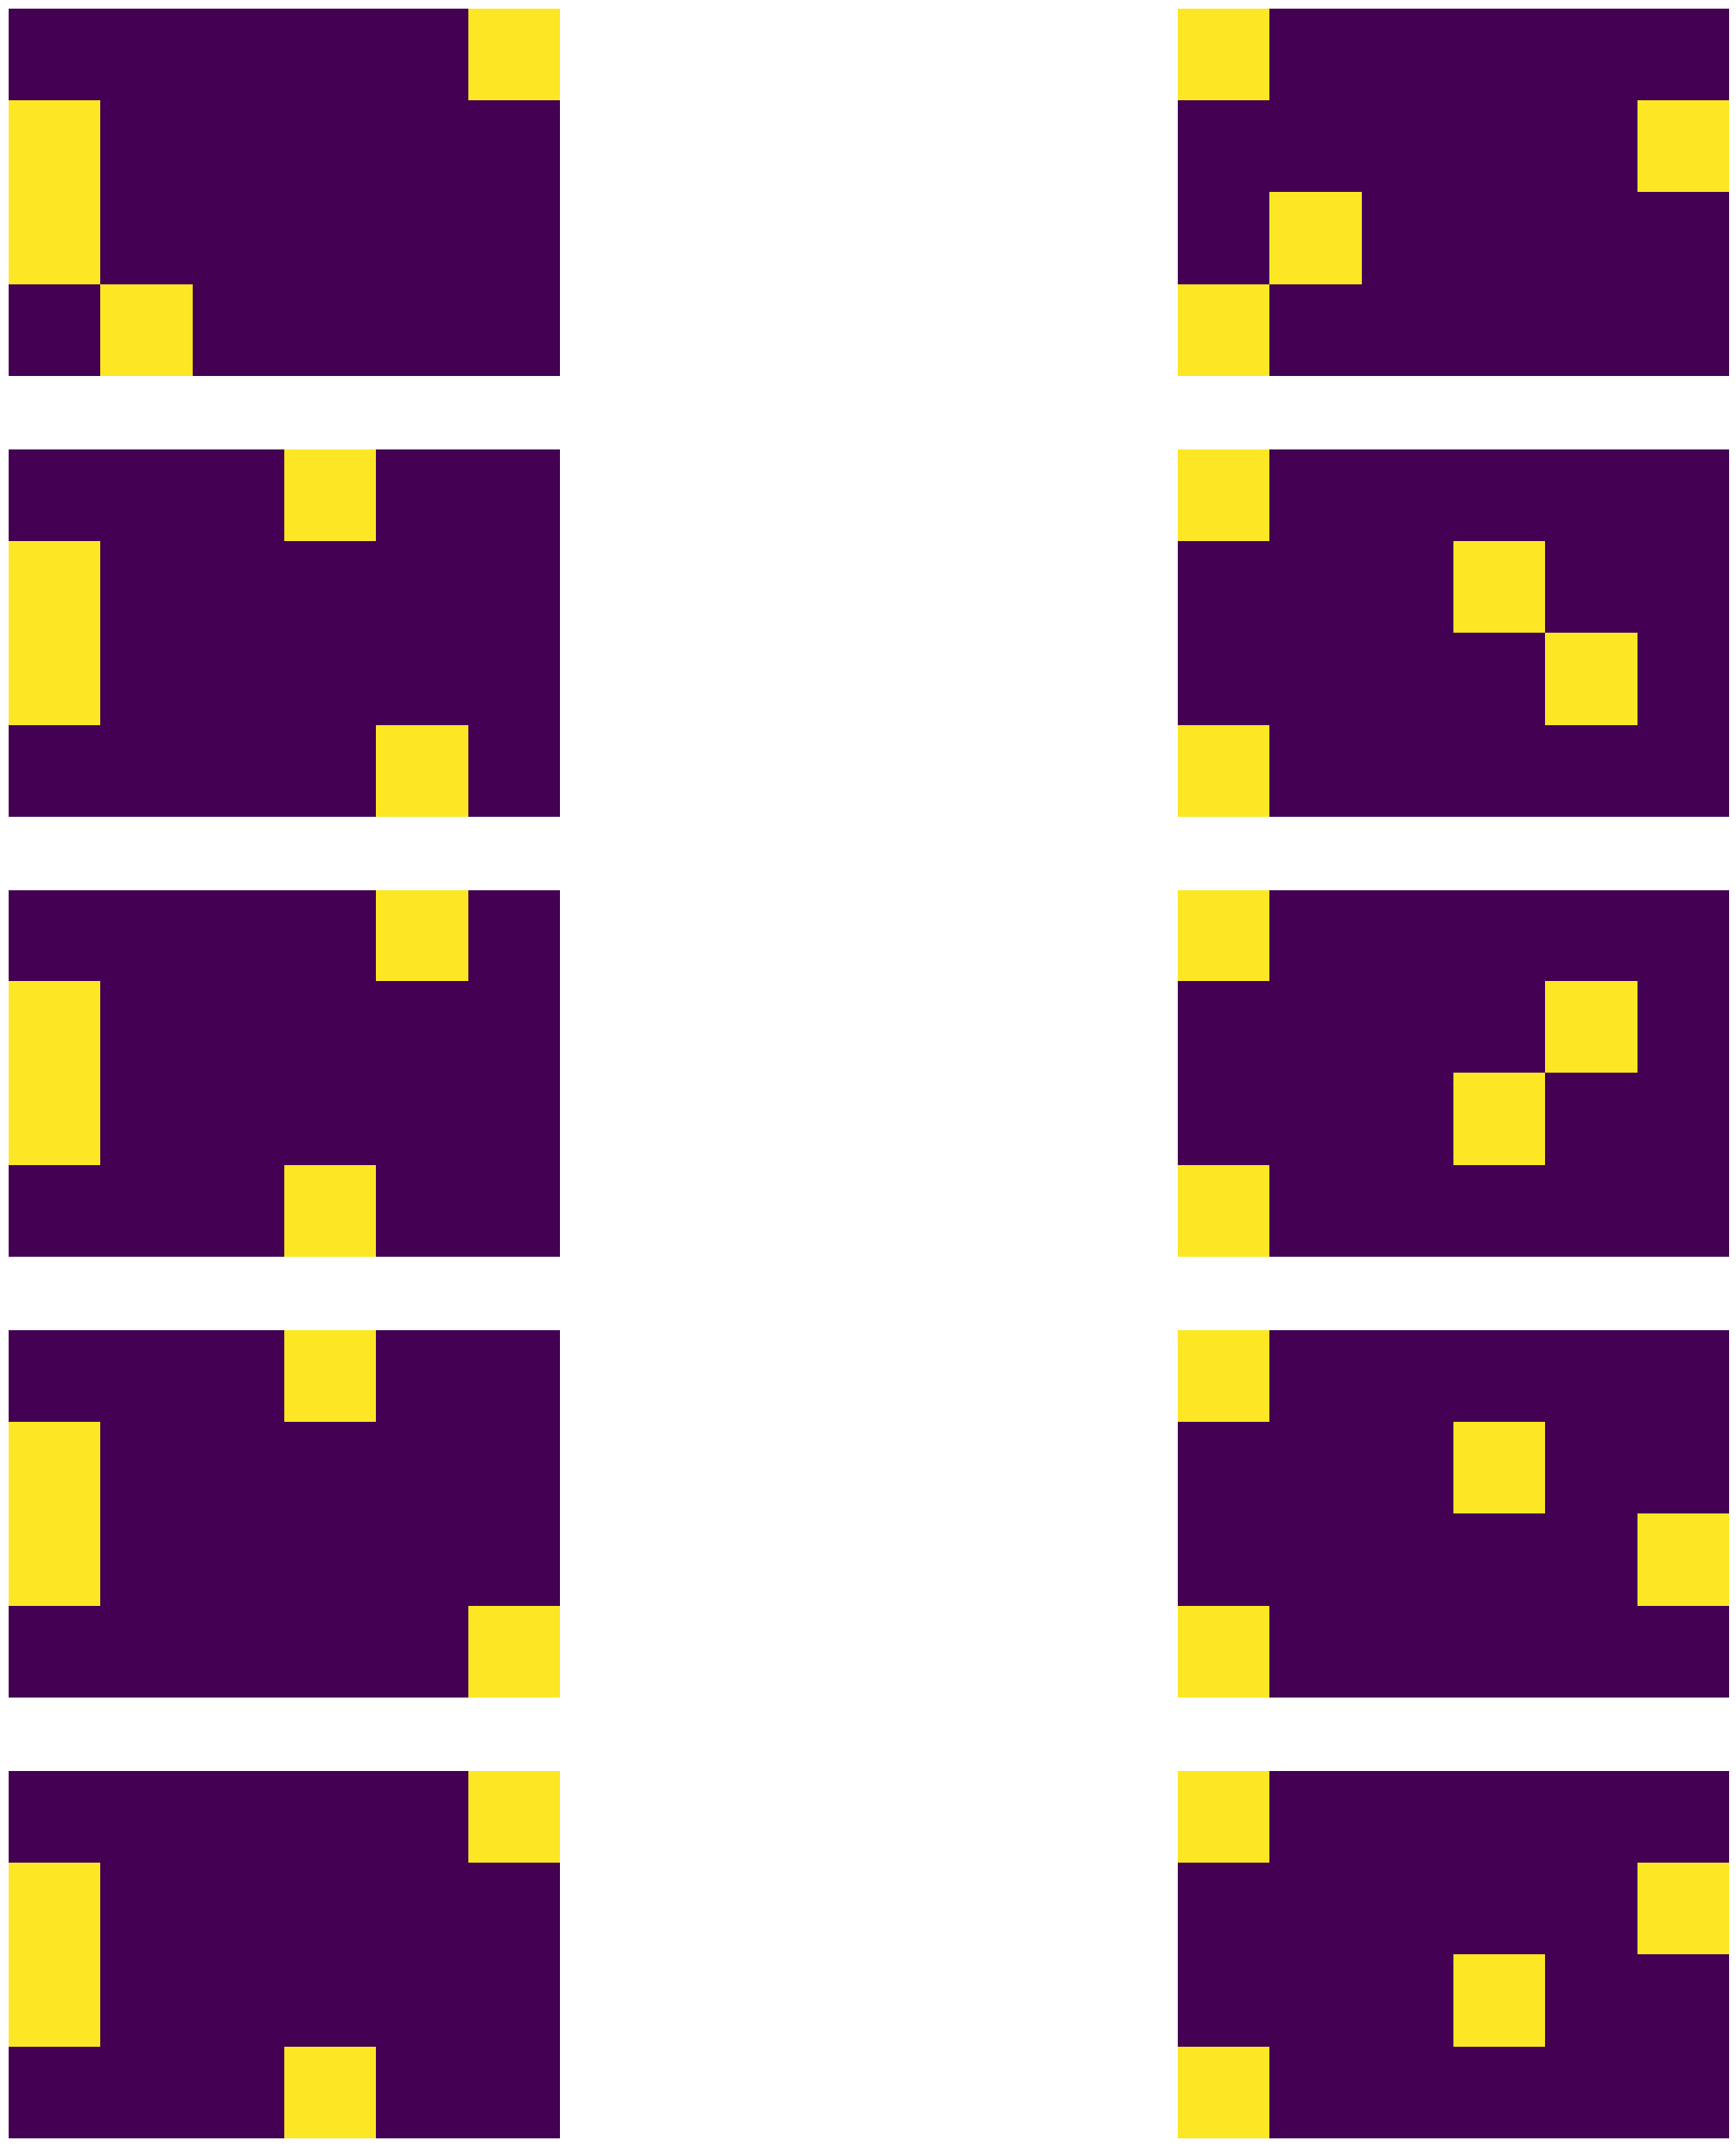

In [275]:
for i in range(17):
    show_samples(X_train[i*10:10*(i+1)])

In [278]:
write_images(X_train, "Imagenes_1_2_sust")

Imagenes guardadas en: Imagenes_1_2_sust


In [282]:
X_train, X_test, y_train, y_test = train_test_list(lista)
X_train,y_train = PrepareConvInput(X_train,y_train)
X_test,y_test = PrepareConvInput(X_test,y_test)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 151.0, 152.0, 153.0, 259.0, 35.0, 36.0, 37.0, 301.0, 302.0, 303.0, 304.0, 305.0, 52.0, 53.0, 316.0, 317.0, 319.0, 66.0, 322.0, 326.0, 331.0, 332.0, 333.0, 334.0, 335.0, 81.0, 82.0, 83.0, 84.0, 211.0, 212.0]


In [283]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_train[0],y_train)

[[[1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [1]
  [0]
  [0]
  [0]
  [0]]] [[ 1.2901211]
 [ 1.2901211]
 [ 1.2901211]
 [ 1.2901211]
 [ 0.0606045]
 [ 0.0606045]
 [ 0.0606045]
 [ 0.0606045]
 [ 1.146497 ]
 [ 1.146497 ]
 [ 1.146497 ]
 [ 1.146497 ]
 [ 2.6404064]
 [ 2.6404064]
 [ 2.6404064]
 [ 2.6404064]
 [ 4.0071102]
 [ 4.0071102]
 [ 4.0071102]
 [ 4.0071102]
 [ 3.0106935]
 [ 3.0106935]
 [ 3.0106935]
 [ 3.0106935]
 [ 2.0553875]
 [ 2.0553875]
 [ 2.0553875]
 [ 2.0553875]
 [ 4.468386 ]
 [ 4.468386 ]
 [ 4.468386 ]
 [ 4.468386 ]
 [ 6.7266701]
 [ 6.7266701]
 [ 6.7266701]
 [ 6.7266701]
 [ 0.6983428]
 [ 0.6983428]
 [ 0.6983428]
 [ 0.6983428]
 [ 3.8583167]
 [ 3.8583167]
 [ 3.8583167]
 [ 3.8583167]
 [ 5.2569038]
 [ 5.2569038]
 [ 5.2569038]
 [ 5.2569038]
 [ 3.8940447]
 [ 3.8940447]
 [ 3.8940447]
 [ 3.8940447]
 [ 4.4974041]
 [ 4.4974041]
 [ 4.4974041]
 [ 4.4974041]
 [ 6.3389403]
 [ 6.3389403]
 [ 6.3389403]
 [ 6.3389403]
 [ 2.047

In [344]:
image_size = (4,6)

In [461]:
inputs = tf.keras.Input(shape=image_size + (1, ), name='inputs')

# Conv Layer 1
conv_1 = layers.Conv2D(64, 1, padding='valid', activation='elu',
                       name='conv_1')(inputs)
#pool_1 = layers.MaxPooling2D(pool_size=(1, 1), name='pool_1')(conv_1)

# Conv Layer 2
#conv_2 = layers.Conv2D(64, 1, padding='valid', activation='elu',
#                       name='conv_2')(pool_1)
#pool_2 = layers.MaxPooling2D(pool_size=(1, 1), name='pool_2')(conv_2)


# Fully-connected
# Flattening
#flat = layers.Flatten(name='flatten')(pool_2)
flat = layers.Flatten(name='flatten')(conv_1)
#flat = layers.Flatten(name='flatten')(inputs)
dense = layers.Dense(64, activation='elu', name='dense')(flat)
outputs = layers.Dense(1, activation='linear', name='output')(dense)

model = keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [462]:
model.summary()
esNOSTOP = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)   #alternative patience=np.inf
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
CALLBACKS = [esNOSTOP]
CALLBACKS = []

Model: "cnn_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 4, 6, 1)]         0         
                                                                 
 conv_1 (Conv2D)             (None, 4, 6, 64)          128       
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 98,561
Trainable params: 98,561
Non-trainable params: 0
_________________________________________________________________


In [463]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_error'])
history = model.fit(
    X_train, 
    y_train,
    batch_size=64,
    epochs=2000,
    validation_split=0.2,
    callbacks=CALLBACKS
)

Epoch 1/2000
3/3 [==============================] - 1s 81ms/step - loss: 15.1484 - mean_absolute_error: 3.3075 - val_loss: 12.9909 - val_mean_absolute_error: 2.5635
Epoch 2/2000
3/3 [==============================] - 0s 23ms/step - loss: 9.8886 - mean_absolute_error: 2.5008 - val_loss: 8.8632 - val_mean_absolute_error: 1.9320
Epoch 3/2000
3/3 [==============================] - 0s 18ms/step - loss: 6.5452 - mean_absolute_error: 2.0063 - val_loss: 6.9578 - val_mean_absolute_error: 1.7434
Epoch 4/2000
3/3 [==============================] - 0s 18ms/step - loss: 5.4488 - mean_absolute_error: 1.8646 - val_loss: 6.8064 - val_mean_absolute_error: 1.9177
Epoch 5/2000
3/3 [==============================] - 0s 19ms/step - loss: 5.5848 - mean_absolute_error: 1.8655 - val_loss: 6.6869 - val_mean_absolute_error: 1.9844
Epoch 6/2000
3/3 [==============================] - 0s 17ms/step - loss: 5.4135 - mean_absolute_error: 1.8120 - val_loss: 5.9966 - val_mean_absolute_error: 1.7897
Epoch 7/2000
3/3 [==

Epoch 51/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.6757 - mean_absolute_error: 0.9836 - val_loss: 3.3754 - val_mean_absolute_error: 1.3854
Epoch 52/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.6653 - mean_absolute_error: 0.9758 - val_loss: 3.2748 - val_mean_absolute_error: 1.3699
Epoch 53/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.6332 - mean_absolute_error: 0.9958 - val_loss: 3.2445 - val_mean_absolute_error: 1.3546
Epoch 54/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.6569 - mean_absolute_error: 1.0252 - val_loss: 3.2525 - val_mean_absolute_error: 1.3534
Epoch 55/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.6319 - mean_absolute_error: 0.9998 - val_loss: 3.3165 - val_mean_absolute_error: 1.3624
Epoch 56/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.6444 - mean_absolute_error: 0.9651 - val_loss: 3.3530 - val_mean_absolute_error: 1.3717
Epoch 57/2000
3/

Epoch 101/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.4581 - mean_absolute_error: 0.7417 - val_loss: 2.7327 - val_mean_absolute_error: 1.1394
Epoch 102/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.4335 - mean_absolute_error: 0.7370 - val_loss: 2.6454 - val_mean_absolute_error: 1.1438
Epoch 103/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.4208 - mean_absolute_error: 0.7281 - val_loss: 2.6431 - val_mean_absolute_error: 1.1509
Epoch 104/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.4065 - mean_absolute_error: 0.7266 - val_loss: 2.7151 - val_mean_absolute_error: 1.1611
Epoch 105/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.3716 - mean_absolute_error: 0.7232 - val_loss: 2.7854 - val_mean_absolute_error: 1.1806
Epoch 106/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.3400 - mean_absolute_error: 0.7191 - val_loss: 2.9025 - val_mean_absolute_error: 1.2224
Epoch 107/

Epoch 151/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0235 - mean_absolute_error: 0.7035 - val_loss: 3.1001 - val_mean_absolute_error: 1.4589
Epoch 152/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0475 - mean_absolute_error: 0.7276 - val_loss: 3.2083 - val_mean_absolute_error: 1.4899
Epoch 153/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.0465 - mean_absolute_error: 0.7242 - val_loss: 3.4350 - val_mean_absolute_error: 1.5269
Epoch 154/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.0600 - mean_absolute_error: 0.7075 - val_loss: 3.6169 - val_mean_absolute_error: 1.5511
Epoch 155/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.0901 - mean_absolute_error: 0.7052 - val_loss: 3.5734 - val_mean_absolute_error: 1.5455
Epoch 156/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.0642 - mean_absolute_error: 0.6983 - val_loss: 3.4004 - val_mean_absolute_error: 1.5197
Epoch 157/

Epoch 201/2000
3/3 [==============================] - 0s 23ms/step - loss: 0.7835 - mean_absolute_error: 0.5866 - val_loss: 2.8345 - val_mean_absolute_error: 1.3812
Epoch 202/2000
3/3 [==============================] - 0s 26ms/step - loss: 0.7498 - mean_absolute_error: 0.5588 - val_loss: 2.8534 - val_mean_absolute_error: 1.3783
Epoch 203/2000
3/3 [==============================] - 0s 25ms/step - loss: 0.7541 - mean_absolute_error: 0.5534 - val_loss: 2.8681 - val_mean_absolute_error: 1.3793
Epoch 204/2000
3/3 [==============================] - 0s 25ms/step - loss: 0.7496 - mean_absolute_error: 0.5418 - val_loss: 2.9861 - val_mean_absolute_error: 1.4183
Epoch 205/2000
3/3 [==============================] - 0s 23ms/step - loss: 0.7711 - mean_absolute_error: 0.5655 - val_loss: 2.9817 - val_mean_absolute_error: 1.4155
Epoch 206/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.7596 - mean_absolute_error: 0.5449 - val_loss: 2.8335 - val_mean_absolute_error: 1.3545
Epoch 207/

Epoch 251/2000
3/3 [==============================] - 0s 23ms/step - loss: 0.3745 - mean_absolute_error: 0.3992 - val_loss: 2.9744 - val_mean_absolute_error: 1.3135
Epoch 252/2000
3/3 [==============================] - 0s 24ms/step - loss: 0.3766 - mean_absolute_error: 0.4065 - val_loss: 2.9383 - val_mean_absolute_error: 1.3087
Epoch 253/2000
3/3 [==============================] - 0s 20ms/step - loss: 0.3689 - mean_absolute_error: 0.3971 - val_loss: 2.9516 - val_mean_absolute_error: 1.3310
Epoch 254/2000
3/3 [==============================] - 0s 23ms/step - loss: 0.3680 - mean_absolute_error: 0.3930 - val_loss: 2.9855 - val_mean_absolute_error: 1.3430
Epoch 255/2000
3/3 [==============================] - 0s 22ms/step - loss: 0.3679 - mean_absolute_error: 0.3974 - val_loss: 3.0201 - val_mean_absolute_error: 1.3443
Epoch 256/2000
3/3 [==============================] - 0s 25ms/step - loss: 0.3637 - mean_absolute_error: 0.4037 - val_loss: 3.0311 - val_mean_absolute_error: 1.3285
Epoch 257/

Epoch 301/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.2292 - mean_absolute_error: 0.3308 - val_loss: 3.0727 - val_mean_absolute_error: 1.2740
Epoch 302/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.2262 - mean_absolute_error: 0.3351 - val_loss: 2.9931 - val_mean_absolute_error: 1.2614
Epoch 303/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2303 - mean_absolute_error: 0.3379 - val_loss: 2.9155 - val_mean_absolute_error: 1.2610
Epoch 304/2000
3/3 [==============================] - 0s 20ms/step - loss: 0.2156 - mean_absolute_error: 0.3136 - val_loss: 2.9033 - val_mean_absolute_error: 1.2789
Epoch 305/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2294 - mean_absolute_error: 0.3401 - val_loss: 2.9435 - val_mean_absolute_error: 1.2695
Epoch 306/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.2115 - mean_absolute_error: 0.3148 - val_loss: 3.1050 - val_mean_absolute_error: 1.2941
Epoch 307/

Epoch 351/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.1430 - mean_absolute_error: 0.2805 - val_loss: 2.8808 - val_mean_absolute_error: 1.2129
Epoch 352/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.1305 - mean_absolute_error: 0.2601 - val_loss: 2.8521 - val_mean_absolute_error: 1.2225
Epoch 353/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1338 - mean_absolute_error: 0.2735 - val_loss: 2.8719 - val_mean_absolute_error: 1.2321
Epoch 354/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.1223 - mean_absolute_error: 0.2532 - val_loss: 2.9550 - val_mean_absolute_error: 1.2281
Epoch 355/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.1274 - mean_absolute_error: 0.2552 - val_loss: 3.0058 - val_mean_absolute_error: 1.2352
Epoch 356/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.1258 - mean_absolute_error: 0.2531 - val_loss: 3.0051 - val_mean_absolute_error: 1.2595
Epoch 357/

Epoch 401/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0530 - mean_absolute_error: 0.1702 - val_loss: 3.0311 - val_mean_absolute_error: 1.3074
Epoch 402/2000
3/3 [==============================] - 0s 22ms/step - loss: 0.0629 - mean_absolute_error: 0.2044 - val_loss: 3.0470 - val_mean_absolute_error: 1.3026
Epoch 403/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0534 - mean_absolute_error: 0.1731 - val_loss: 3.1297 - val_mean_absolute_error: 1.2647
Epoch 404/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0638 - mean_absolute_error: 0.1877 - val_loss: 3.1455 - val_mean_absolute_error: 1.2611
Epoch 405/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0558 - mean_absolute_error: 0.1788 - val_loss: 3.0434 - val_mean_absolute_error: 1.3050
Epoch 406/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0538 - mean_absolute_error: 0.1808 - val_loss: 3.0072 - val_mean_absolute_error: 1.3253
Epoch 407/

Epoch 451/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0145 - mean_absolute_error: 0.0903 - val_loss: 3.0049 - val_mean_absolute_error: 1.2844
Epoch 452/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0138 - mean_absolute_error: 0.0875 - val_loss: 3.0088 - val_mean_absolute_error: 1.2776
Epoch 453/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0138 - mean_absolute_error: 0.0862 - val_loss: 3.0097 - val_mean_absolute_error: 1.2796
Epoch 454/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0132 - mean_absolute_error: 0.0842 - val_loss: 3.0069 - val_mean_absolute_error: 1.2809
Epoch 455/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0128 - mean_absolute_error: 0.0827 - val_loss: 3.0187 - val_mean_absolute_error: 1.2800
Epoch 456/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0129 - mean_absolute_error: 0.0833 - val_loss: 3.0134 - val_mean_absolute_error: 1.2832
Epoch 457/

Epoch 501/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0039 - mean_absolute_error: 0.0470 - val_loss: 3.0713 - val_mean_absolute_error: 1.3079
Epoch 502/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_absolute_error: 0.0475 - val_loss: 3.0606 - val_mean_absolute_error: 1.3071
Epoch 503/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_absolute_error: 0.0465 - val_loss: 3.0636 - val_mean_absolute_error: 1.3040
Epoch 504/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_absolute_error: 0.0475 - val_loss: 3.0712 - val_mean_absolute_error: 1.3074
Epoch 505/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0037 - mean_absolute_error: 0.0480 - val_loss: 3.0732 - val_mean_absolute_error: 1.3199
Epoch 506/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 3.0918 - val_mean_absolute_error: 1.3145
Epoch 507/

Epoch 551/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0016 - mean_absolute_error: 0.0319 - val_loss: 3.0612 - val_mean_absolute_error: 1.3085
Epoch 552/2000
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - mean_absolute_error: 0.0291 - val_loss: 3.0589 - val_mean_absolute_error: 1.3084
Epoch 553/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0012 - mean_absolute_error: 0.0270 - val_loss: 3.0637 - val_mean_absolute_error: 1.3089
Epoch 554/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0012 - mean_absolute_error: 0.0270 - val_loss: 3.0713 - val_mean_absolute_error: 1.3112
Epoch 555/2000
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - mean_absolute_error: 0.0268 - val_loss: 3.0809 - val_mean_absolute_error: 1.3108
Epoch 556/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0012 - mean_absolute_error: 0.0269 - val_loss: 3.0896 - val_mean_absolute_error: 1.3114
Epoch 557/

Epoch 600/2000
3/3 [==============================] - 0s 19ms/step - loss: 5.6916e-04 - mean_absolute_error: 0.0185 - val_loss: 3.0732 - val_mean_absolute_error: 1.3129
Epoch 601/2000
3/3 [==============================] - 0s 18ms/step - loss: 6.0599e-04 - mean_absolute_error: 0.0196 - val_loss: 3.0668 - val_mean_absolute_error: 1.3121
Epoch 602/2000
3/3 [==============================] - 0s 16ms/step - loss: 5.6200e-04 - mean_absolute_error: 0.0183 - val_loss: 3.0660 - val_mean_absolute_error: 1.3098
Epoch 603/2000
3/3 [==============================] - 0s 18ms/step - loss: 5.9865e-04 - mean_absolute_error: 0.0186 - val_loss: 3.0664 - val_mean_absolute_error: 1.3106
Epoch 604/2000
3/3 [==============================] - 0s 18ms/step - loss: 5.6281e-04 - mean_absolute_error: 0.0179 - val_loss: 3.0680 - val_mean_absolute_error: 1.3143
Epoch 605/2000
3/3 [==============================] - 0s 18ms/step - loss: 5.9722e-04 - mean_absolute_error: 0.0187 - val_loss: 3.0774 - val_mean_absolute_

3/3 [==============================] - 0s 18ms/step - loss: 2.5623e-04 - mean_absolute_error: 0.0120 - val_loss: 3.0730 - val_mean_absolute_error: 1.3155
Epoch 649/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.7302e-04 - mean_absolute_error: 0.0128 - val_loss: 3.0740 - val_mean_absolute_error: 1.3151
Epoch 650/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.4590e-04 - mean_absolute_error: 0.0120 - val_loss: 3.0773 - val_mean_absolute_error: 1.3132
Epoch 651/2000
3/3 [==============================] - 0s 19ms/step - loss: 3.5495e-04 - mean_absolute_error: 0.0145 - val_loss: 3.0738 - val_mean_absolute_error: 1.3131
Epoch 652/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.7906e-04 - mean_absolute_error: 0.0127 - val_loss: 3.0689 - val_mean_absolute_error: 1.3146
Epoch 653/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.1400e-04 - mean_absolute_error: 0.0142 - val_loss: 3.0764 - val_mean_absolute_error: 1.3118
E

3/3 [==============================] - 0s 29ms/step - loss: 1.6672e-04 - mean_absolute_error: 0.0104 - val_loss: 3.0821 - val_mean_absolute_error: 1.3133
Epoch 697/2000
3/3 [==============================] - 0s 24ms/step - loss: 1.5958e-04 - mean_absolute_error: 0.0100 - val_loss: 3.0761 - val_mean_absolute_error: 1.3150
Epoch 698/2000
3/3 [==============================] - 0s 26ms/step - loss: 1.5512e-04 - mean_absolute_error: 0.0096 - val_loss: 3.0762 - val_mean_absolute_error: 1.3141
Epoch 699/2000
3/3 [==============================] - 0s 28ms/step - loss: 1.6019e-04 - mean_absolute_error: 0.0097 - val_loss: 3.0742 - val_mean_absolute_error: 1.3140
Epoch 700/2000
3/3 [==============================] - 0s 24ms/step - loss: 1.4487e-04 - mean_absolute_error: 0.0092 - val_loss: 3.0729 - val_mean_absolute_error: 1.3150
Epoch 701/2000
3/3 [==============================] - 0s 29ms/step - loss: 1.1747e-04 - mean_absolute_error: 0.0082 - val_loss: 3.0761 - val_mean_absolute_error: 1.3147
E

3/3 [==============================] - 0s 19ms/step - loss: 7.5829e-05 - mean_absolute_error: 0.0067 - val_loss: 3.0748 - val_mean_absolute_error: 1.3156
Epoch 745/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.7302e-05 - mean_absolute_error: 0.0072 - val_loss: 3.0769 - val_mean_absolute_error: 1.3155
Epoch 746/2000
3/3 [==============================] - 0s 23ms/step - loss: 7.7951e-05 - mean_absolute_error: 0.0067 - val_loss: 3.0746 - val_mean_absolute_error: 1.3161
Epoch 747/2000
3/3 [==============================] - 0s 20ms/step - loss: 7.4015e-05 - mean_absolute_error: 0.0066 - val_loss: 3.0752 - val_mean_absolute_error: 1.3158
Epoch 748/2000
3/3 [==============================] - 0s 21ms/step - loss: 6.3785e-05 - mean_absolute_error: 0.0063 - val_loss: 3.0749 - val_mean_absolute_error: 1.3159
Epoch 749/2000
3/3 [==============================] - 0s 21ms/step - loss: 6.5179e-05 - mean_absolute_error: 0.0062 - val_loss: 3.0761 - val_mean_absolute_error: 1.3156
E

3/3 [==============================] - 0s 20ms/step - loss: 4.5829e-05 - mean_absolute_error: 0.0053 - val_loss: 3.0774 - val_mean_absolute_error: 1.3169
Epoch 793/2000
3/3 [==============================] - 0s 20ms/step - loss: 4.3635e-05 - mean_absolute_error: 0.0053 - val_loss: 3.0792 - val_mean_absolute_error: 1.3160
Epoch 794/2000
3/3 [==============================] - 0s 19ms/step - loss: 4.3858e-05 - mean_absolute_error: 0.0051 - val_loss: 3.0777 - val_mean_absolute_error: 1.3161
Epoch 795/2000
3/3 [==============================] - 0s 18ms/step - loss: 3.2644e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0747 - val_mean_absolute_error: 1.3165
Epoch 796/2000
3/3 [==============================] - 0s 21ms/step - loss: 3.8279e-05 - mean_absolute_error: 0.0049 - val_loss: 3.0766 - val_mean_absolute_error: 1.3150
Epoch 797/2000
3/3 [==============================] - 0s 19ms/step - loss: 4.6369e-05 - mean_absolute_error: 0.0054 - val_loss: 3.0767 - val_mean_absolute_error: 1.3154
E

3/3 [==============================] - 0s 18ms/step - loss: 1.6898e-05 - mean_absolute_error: 0.0030 - val_loss: 3.0779 - val_mean_absolute_error: 1.3165
Epoch 841/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.6066e-05 - mean_absolute_error: 0.0030 - val_loss: 3.0798 - val_mean_absolute_error: 1.3162
Epoch 842/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.7547e-05 - mean_absolute_error: 0.0032 - val_loss: 3.0811 - val_mean_absolute_error: 1.3169
Epoch 843/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.4830e-05 - mean_absolute_error: 0.0028 - val_loss: 3.0817 - val_mean_absolute_error: 1.3173
Epoch 844/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.5357e-05 - mean_absolute_error: 0.0028 - val_loss: 3.0823 - val_mean_absolute_error: 1.3164
Epoch 845/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.7111e-05 - mean_absolute_error: 0.0031 - val_loss: 3.0795 - val_mean_absolute_error: 1.3164
E

3/3 [==============================] - 0s 18ms/step - loss: 3.0300e-05 - mean_absolute_error: 0.0043 - val_loss: 3.0781 - val_mean_absolute_error: 1.3168
Epoch 889/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.1411e-05 - mean_absolute_error: 0.0036 - val_loss: 3.0827 - val_mean_absolute_error: 1.3172
Epoch 890/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.2529e-05 - mean_absolute_error: 0.0038 - val_loss: 3.0899 - val_mean_absolute_error: 1.3166
Epoch 891/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.9055e-05 - mean_absolute_error: 0.0050 - val_loss: 3.0873 - val_mean_absolute_error: 1.3183
Epoch 892/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.1190e-05 - mean_absolute_error: 0.0047 - val_loss: 3.0861 - val_mean_absolute_error: 1.3170
Epoch 893/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.8504e-05 - mean_absolute_error: 0.0034 - val_loss: 3.0826 - val_mean_absolute_error: 1.3171
E

3/3 [==============================] - 0s 18ms/step - loss: 6.6535e-06 - mean_absolute_error: 0.0019 - val_loss: 3.0835 - val_mean_absolute_error: 1.3173
Epoch 937/2000
3/3 [==============================] - 0s 18ms/step - loss: 4.8840e-06 - mean_absolute_error: 0.0015 - val_loss: 3.0851 - val_mean_absolute_error: 1.3171
Epoch 938/2000
3/3 [==============================] - 0s 18ms/step - loss: 5.0556e-06 - mean_absolute_error: 0.0017 - val_loss: 3.0850 - val_mean_absolute_error: 1.3174
Epoch 939/2000
3/3 [==============================] - 0s 16ms/step - loss: 4.3141e-06 - mean_absolute_error: 0.0014 - val_loss: 3.0848 - val_mean_absolute_error: 1.3174
Epoch 940/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.9360e-06 - mean_absolute_error: 0.0014 - val_loss: 3.0843 - val_mean_absolute_error: 1.3172
Epoch 941/2000
3/3 [==============================] - 0s 17ms/step - loss: 4.6141e-06 - mean_absolute_error: 0.0015 - val_loss: 3.0836 - val_mean_absolute_error: 1.3171
E

3/3 [==============================] - 0s 18ms/step - loss: 3.3885e-06 - mean_absolute_error: 0.0013 - val_loss: 3.0862 - val_mean_absolute_error: 1.3174
Epoch 985/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.2939e-06 - mean_absolute_error: 0.0014 - val_loss: 3.0855 - val_mean_absolute_error: 1.3174
Epoch 986/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.2979e-06 - mean_absolute_error: 0.0013 - val_loss: 3.0859 - val_mean_absolute_error: 1.3172
Epoch 987/2000
3/3 [==============================] - 0s 18ms/step - loss: 3.1444e-06 - mean_absolute_error: 0.0013 - val_loss: 3.0848 - val_mean_absolute_error: 1.3176
Epoch 988/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.7165e-06 - mean_absolute_error: 0.0015 - val_loss: 3.0851 - val_mean_absolute_error: 1.3175
Epoch 989/2000
3/3 [==============================] - 0s 18ms/step - loss: 3.2120e-06 - mean_absolute_error: 0.0014 - val_loss: 3.0854 - val_mean_absolute_error: 1.3176
E

3/3 [==============================] - 0s 18ms/step - loss: 2.2023e-06 - mean_absolute_error: 0.0012 - val_loss: 3.0854 - val_mean_absolute_error: 1.3174
Epoch 1033/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.3033e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0853 - val_mean_absolute_error: 1.3176
Epoch 1034/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.5320e-06 - mean_absolute_error: 8.9129e-04 - val_loss: 3.0858 - val_mean_absolute_error: 1.3177
Epoch 1035/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3031e-06 - mean_absolute_error: 8.2630e-04 - val_loss: 3.0868 - val_mean_absolute_error: 1.3177
Epoch 1036/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.4005e-06 - mean_absolute_error: 8.6128e-04 - val_loss: 3.0867 - val_mean_absolute_error: 1.3179
Epoch 1037/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.1438e-06 - mean_absolute_error: 7.5978e-04 - val_loss: 3.0865 - val_mean_abs

Epoch 1080/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.0452e-06 - mean_absolute_error: 7.2412e-04 - val_loss: 3.0861 - val_mean_absolute_error: 1.3177
Epoch 1081/2000
3/3 [==============================] - 0s 17ms/step - loss: 8.1633e-07 - mean_absolute_error: 6.4758e-04 - val_loss: 3.0867 - val_mean_absolute_error: 1.3177
Epoch 1082/2000
3/3 [==============================] - 0s 17ms/step - loss: 7.8439e-07 - mean_absolute_error: 6.5094e-04 - val_loss: 3.0867 - val_mean_absolute_error: 1.3178
Epoch 1083/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.1285e-06 - mean_absolute_error: 8.2033e-04 - val_loss: 3.0867 - val_mean_absolute_error: 1.3177
Epoch 1084/2000
3/3 [==============================] - 0s 19ms/step - loss: 9.8987e-07 - mean_absolute_error: 7.4977e-04 - val_loss: 3.0867 - val_mean_absolute_error: 1.3177
Epoch 1085/2000
3/3 [==============================] - 0s 17ms/step - loss: 8.2037e-07 - mean_absolute_error: 6.7503e-04 - val_los

3/3 [==============================] - 0s 18ms/step - loss: 1.6238e-06 - mean_absolute_error: 0.0010 - val_loss: 3.0869 - val_mean_absolute_error: 1.3178
Epoch 1128/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.2435e-06 - mean_absolute_error: 8.6861e-04 - val_loss: 3.0866 - val_mean_absolute_error: 1.3177
Epoch 1129/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.1695e-07 - mean_absolute_error: 7.3716e-04 - val_loss: 3.0869 - val_mean_absolute_error: 1.3180
Epoch 1130/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.1385e-06 - mean_absolute_error: 8.5902e-04 - val_loss: 3.0881 - val_mean_absolute_error: 1.3178
Epoch 1131/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.2568e-07 - mean_absolute_error: 6.9206e-04 - val_loss: 3.0873 - val_mean_absolute_error: 1.3181
Epoch 1132/2000
3/3 [==============================] - 0s 18ms/step - loss: 9.9355e-07 - mean_absolute_error: 8.2837e-04 - val_loss: 3.0876 - val_mean

3/3 [==============================] - 0s 18ms/step - loss: 3.0401e-06 - mean_absolute_error: 0.0014 - val_loss: 3.0877 - val_mean_absolute_error: 1.3172
Epoch 1176/2000
3/3 [==============================] - 0s 18ms/step - loss: 6.7689e-06 - mean_absolute_error: 0.0022 - val_loss: 3.0868 - val_mean_absolute_error: 1.3184
Epoch 1177/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.2338e-05 - mean_absolute_error: 0.0030 - val_loss: 3.0896 - val_mean_absolute_error: 1.3175
Epoch 1178/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.7766e-06 - mean_absolute_error: 0.0025 - val_loss: 3.0865 - val_mean_absolute_error: 1.3183
Epoch 1179/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.7250e-06 - mean_absolute_error: 0.0016 - val_loss: 3.0876 - val_mean_absolute_error: 1.3176
Epoch 1180/2000
3/3 [==============================] - 0s 17ms/step - loss: 4.0368e-06 - mean_absolute_error: 0.0016 - val_loss: 3.0875 - val_mean_absolute_error: 1.3

3/3 [==============================] - 0s 18ms/step - loss: 1.9462e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0880 - val_mean_absolute_error: 1.3179
Epoch 1223/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.6929e-06 - mean_absolute_error: 0.0010 - val_loss: 3.0873 - val_mean_absolute_error: 1.3179
Epoch 1224/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.9573e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0877 - val_mean_absolute_error: 1.3178
Epoch 1225/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.3069e-06 - mean_absolute_error: 8.9822e-04 - val_loss: 3.0879 - val_mean_absolute_error: 1.3180
Epoch 1226/2000
3/3 [==============================] - 0s 18ms/step - loss: 7.9325e-07 - mean_absolute_error: 7.2315e-04 - val_loss: 3.0883 - val_mean_absolute_error: 1.3180
Epoch 1227/2000
3/3 [==============================] - 0s 18ms/step - loss: 7.5700e-07 - mean_absolute_error: 7.1430e-04 - val_loss: 3.0874 - val_mean_absolut

3/3 [==============================] - 0s 18ms/step - loss: 5.7298e-06 - mean_absolute_error: 0.0019 - val_loss: 3.0876 - val_mean_absolute_error: 1.3177
Epoch 1270/2000
3/3 [==============================] - 0s 17ms/step - loss: 5.5002e-06 - mean_absolute_error: 0.0020 - val_loss: 3.0877 - val_mean_absolute_error: 1.3175
Epoch 1271/2000
3/3 [==============================] - 0s 17ms/step - loss: 4.3913e-06 - mean_absolute_error: 0.0016 - val_loss: 3.0864 - val_mean_absolute_error: 1.3182
Epoch 1272/2000
3/3 [==============================] - 0s 18ms/step - loss: 4.9991e-06 - mean_absolute_error: 0.0017 - val_loss: 3.0880 - val_mean_absolute_error: 1.3176
Epoch 1273/2000
3/3 [==============================] - 0s 18ms/step - loss: 4.2946e-06 - mean_absolute_error: 0.0017 - val_loss: 3.0864 - val_mean_absolute_error: 1.3180
Epoch 1274/2000
3/3 [==============================] - 0s 18ms/step - loss: 3.9912e-06 - mean_absolute_error: 0.0015 - val_loss: 3.0885 - val_mean_absolute_error: 1.3

3/3 [==============================] - 0s 17ms/step - loss: 0.0014 - mean_absolute_error: 0.0331 - val_loss: 3.0731 - val_mean_absolute_error: 1.3251
Epoch 1318/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.4881e-04 - mean_absolute_error: 0.0233 - val_loss: 3.1037 - val_mean_absolute_error: 1.3188
Epoch 1319/2000
3/3 [==============================] - 0s 18ms/step - loss: 9.6059e-04 - mean_absolute_error: 0.0242 - val_loss: 3.0780 - val_mean_absolute_error: 1.3152
Epoch 1320/2000
3/3 [==============================] - 0s 17ms/step - loss: 7.9392e-04 - mean_absolute_error: 0.0218 - val_loss: 3.0595 - val_mean_absolute_error: 1.3141
Epoch 1321/2000
3/3 [==============================] - 0s 17ms/step - loss: 8.3596e-04 - mean_absolute_error: 0.0233 - val_loss: 3.0775 - val_mean_absolute_error: 1.3092
Epoch 1322/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0011 - mean_absolute_error: 0.0260 - val_loss: 3.0759 - val_mean_absolute_error: 1.3273
Epoc

3/3 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_absolute_error: 0.0677 - val_loss: 3.1046 - val_mean_absolute_error: 1.3369
Epoch 1367/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0073 - mean_absolute_error: 0.0689 - val_loss: 3.0925 - val_mean_absolute_error: 1.2945
Epoch 1368/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0126 - mean_absolute_error: 0.0901 - val_loss: 3.0779 - val_mean_absolute_error: 1.3268
Epoch 1369/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0128 - mean_absolute_error: 0.0793 - val_loss: 3.1057 - val_mean_absolute_error: 1.3509
Epoch 1370/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0182 - mean_absolute_error: 0.1096 - val_loss: 3.0572 - val_mean_absolute_error: 1.3015
Epoch 1371/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0286 - mean_absolute_error: 0.1396 - val_loss: 2.9493 - val_mean_absolute_error: 1.3424
Epoch 1372/2000
3/3 

3/3 [==============================] - 0s 18ms/step - loss: 0.0080 - mean_absolute_error: 0.0708 - val_loss: 3.0252 - val_mean_absolute_error: 1.3060
Epoch 1416/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_absolute_error: 0.0604 - val_loss: 2.9647 - val_mean_absolute_error: 1.2834
Epoch 1417/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_absolute_error: 0.0622 - val_loss: 2.9214 - val_mean_absolute_error: 1.3018
Epoch 1418/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0080 - mean_absolute_error: 0.0735 - val_loss: 2.9850 - val_mean_absolute_error: 1.2865
Epoch 1419/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0053 - mean_absolute_error: 0.0593 - val_loss: 3.0325 - val_mean_absolute_error: 1.3230
Epoch 1420/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0068 - mean_absolute_error: 0.0670 - val_loss: 3.0939 - val_mean_absolute_error: 1.3320
Epoch 1421/2000
3/3 

Epoch 1464/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.5809e-04 - mean_absolute_error: 0.0094 - val_loss: 3.0432 - val_mean_absolute_error: 1.3081
Epoch 1465/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.6693e-04 - mean_absolute_error: 0.0093 - val_loss: 3.0569 - val_mean_absolute_error: 1.3080
Epoch 1466/2000
3/3 [==============================] - 0s 18ms/step - loss: 3.1780e-04 - mean_absolute_error: 0.0124 - val_loss: 3.0477 - val_mean_absolute_error: 1.3112
Epoch 1467/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.1404e-04 - mean_absolute_error: 0.0123 - val_loss: 3.0379 - val_mean_absolute_error: 1.3067
Epoch 1468/2000
3/3 [==============================] - 0s 18ms/step - loss: 9.7800e-05 - mean_absolute_error: 0.0080 - val_loss: 3.0260 - val_mean_absolute_error: 1.3085
Epoch 1469/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.8841e-04 - mean_absolute_error: 0.0096 - val_loss: 3.0325 - val_mean_abs

3/3 [==============================] - 0s 24ms/step - loss: 1.1288e-05 - mean_absolute_error: 0.0025 - val_loss: 3.0404 - val_mean_absolute_error: 1.3088
Epoch 1513/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.1119e-05 - mean_absolute_error: 0.0025 - val_loss: 3.0372 - val_mean_absolute_error: 1.3089
Epoch 1514/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.1372e-05 - mean_absolute_error: 0.0026 - val_loss: 3.0364 - val_mean_absolute_error: 1.3079
Epoch 1515/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.1758e-05 - mean_absolute_error: 0.0025 - val_loss: 3.0357 - val_mean_absolute_error: 1.3086
Epoch 1516/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0390e-05 - mean_absolute_error: 0.0026 - val_loss: 3.0387 - val_mean_absolute_error: 1.3084
Epoch 1517/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.1824e-06 - mean_absolute_error: 0.0023 - val_loss: 3.0400 - val_mean_absolute_error: 1.3

3/3 [==============================] - 0s 18ms/step - loss: 2.5280e-05 - mean_absolute_error: 0.0040 - val_loss: 3.0447 - val_mean_absolute_error: 1.3090
Epoch 1561/2000
3/3 [==============================] - 0s 16ms/step - loss: 2.5415e-05 - mean_absolute_error: 0.0040 - val_loss: 3.0450 - val_mean_absolute_error: 1.3106
Epoch 1562/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.6823e-05 - mean_absolute_error: 0.0034 - val_loss: 3.0445 - val_mean_absolute_error: 1.3095
Epoch 1563/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.0367e-05 - mean_absolute_error: 0.0033 - val_loss: 3.0413 - val_mean_absolute_error: 1.3087
Epoch 1564/2000
3/3 [==============================] - 0s 17ms/step - loss: 9.2306e-06 - mean_absolute_error: 0.0024 - val_loss: 3.0398 - val_mean_absolute_error: 1.3087
Epoch 1565/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.2642e-05 - mean_absolute_error: 0.0027 - val_loss: 3.0407 - val_mean_absolute_error: 1.3

3/3 [==============================] - 0s 18ms/step - loss: 6.8199e-06 - mean_absolute_error: 0.0020 - val_loss: 3.0409 - val_mean_absolute_error: 1.3085
Epoch 1609/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3900e-05 - mean_absolute_error: 0.0033 - val_loss: 3.0402 - val_mean_absolute_error: 1.3096
Epoch 1610/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.4162e-05 - mean_absolute_error: 0.0032 - val_loss: 3.0428 - val_mean_absolute_error: 1.3092
Epoch 1611/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.1147e-05 - mean_absolute_error: 0.0026 - val_loss: 3.0431 - val_mean_absolute_error: 1.3098
Epoch 1612/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.4511e-05 - mean_absolute_error: 0.0031 - val_loss: 3.0438 - val_mean_absolute_error: 1.3092
Epoch 1613/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.6366e-05 - mean_absolute_error: 0.0033 - val_loss: 3.0435 - val_mean_absolute_error: 1.3

3/3 [==============================] - 0s 18ms/step - loss: 1.8359e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0421 - val_mean_absolute_error: 1.3095
Epoch 1657/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.3277e-06 - mean_absolute_error: 9.1336e-04 - val_loss: 3.0409 - val_mean_absolute_error: 1.3095
Epoch 1658/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.2057e-06 - mean_absolute_error: 0.0012 - val_loss: 3.0415 - val_mean_absolute_error: 1.3091
Epoch 1659/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.3632e-06 - mean_absolute_error: 0.0012 - val_loss: 3.0419 - val_mean_absolute_error: 1.3094
Epoch 1660/2000
3/3 [==============================] - 0s 17ms/step - loss: 9.1063e-07 - mean_absolute_error: 7.7520e-04 - val_loss: 3.0426 - val_mean_absolute_error: 1.3095
Epoch 1661/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.1477e-06 - mean_absolute_error: 8.3384e-04 - val_loss: 3.0424 - val_mean_absolut

3/3 [==============================] - 0s 18ms/step - loss: 1.8543e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0417 - val_mean_absolute_error: 1.3095
Epoch 1704/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.2222e-06 - mean_absolute_error: 8.5279e-04 - val_loss: 3.0423 - val_mean_absolute_error: 1.3096
Epoch 1705/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.2756e-06 - mean_absolute_error: 9.1179e-04 - val_loss: 3.0429 - val_mean_absolute_error: 1.3094
Epoch 1706/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.7958e-06 - mean_absolute_error: 0.0010 - val_loss: 3.0413 - val_mean_absolute_error: 1.3097
Epoch 1707/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.0007e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0405 - val_mean_absolute_error: 1.3091
Epoch 1708/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.8542e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0413 - val_mean_absolute_er

Epoch 1751/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.5684e-06 - mean_absolute_error: 0.0013 - val_loss: 3.0415 - val_mean_absolute_error: 1.3097
Epoch 1752/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.5818e-06 - mean_absolute_error: 0.0010 - val_loss: 3.0436 - val_mean_absolute_error: 1.3091
Epoch 1753/2000
3/3 [==============================] - 0s 18ms/step - loss: 4.6244e-06 - mean_absolute_error: 0.0016 - val_loss: 3.0426 - val_mean_absolute_error: 1.3099
Epoch 1754/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.6313e-06 - mean_absolute_error: 0.0013 - val_loss: 3.0417 - val_mean_absolute_error: 1.3091
Epoch 1755/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.9669e-06 - mean_absolute_error: 0.0012 - val_loss: 3.0397 - val_mean_absolute_error: 1.3093
Epoch 1756/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.8208e-06 - mean_absolute_error: 0.0013 - val_loss: 3.0412 - val_mean_abs

3/3 [==============================] - 0s 17ms/step - loss: 6.9281e-06 - mean_absolute_error: 0.0021 - val_loss: 3.0434 - val_mean_absolute_error: 1.3098
Epoch 1800/2000
3/3 [==============================] - 0s 17ms/step - loss: 8.0340e-06 - mean_absolute_error: 0.0022 - val_loss: 3.0419 - val_mean_absolute_error: 1.3097
Epoch 1801/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.2746e-06 - mean_absolute_error: 0.0022 - val_loss: 3.0440 - val_mean_absolute_error: 1.3099
Epoch 1802/2000
3/3 [==============================] - 0s 16ms/step - loss: 7.4174e-06 - mean_absolute_error: 0.0022 - val_loss: 3.0460 - val_mean_absolute_error: 1.3094
Epoch 1803/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3531e-05 - mean_absolute_error: 0.0029 - val_loss: 3.0420 - val_mean_absolute_error: 1.3107
Epoch 1804/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.6969e-05 - mean_absolute_error: 0.0034 - val_loss: 3.0417 - val_mean_absolute_error: 1.3

3/3 [==============================] - 0s 17ms/step - loss: 4.1880e-04 - mean_absolute_error: 0.0155 - val_loss: 3.0523 - val_mean_absolute_error: 1.3113
Epoch 1848/2000
3/3 [==============================] - 0s 18ms/step - loss: 3.8837e-04 - mean_absolute_error: 0.0150 - val_loss: 3.0467 - val_mean_absolute_error: 1.3157
Epoch 1849/2000
3/3 [==============================] - 0s 17ms/step - loss: 5.9915e-04 - mean_absolute_error: 0.0189 - val_loss: 3.0450 - val_mean_absolute_error: 1.3032
Epoch 1850/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0013 - mean_absolute_error: 0.0296 - val_loss: 3.0007 - val_mean_absolute_error: 1.3052
Epoch 1851/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0241 - val_loss: 3.0135 - val_mean_absolute_error: 1.2990
Epoch 1852/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0019 - mean_absolute_error: 0.0269 - val_loss: 3.0503 - val_mean_absolute_error: 1.3086
Epoch 18

3/3 [==============================] - 0s 18ms/step - loss: 0.0520 - mean_absolute_error: 0.1884 - val_loss: 3.3988 - val_mean_absolute_error: 1.3339
Epoch 1897/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0729 - mean_absolute_error: 0.2183 - val_loss: 3.2224 - val_mean_absolute_error: 1.4154
Epoch 1898/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0660 - mean_absolute_error: 0.2211 - val_loss: 3.1460 - val_mean_absolute_error: 1.2877
Epoch 1899/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0695 - mean_absolute_error: 0.2324 - val_loss: 2.8808 - val_mean_absolute_error: 1.3606
Epoch 1900/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.0899 - mean_absolute_error: 0.2450 - val_loss: 3.0401 - val_mean_absolute_error: 1.2745
Epoch 1901/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0629 - mean_absolute_error: 0.2064 - val_loss: 3.0035 - val_mean_absolute_error: 1.3601
Epoch 1902/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0297 - val_loss: 3.0154 - val_mean_absolute_error: 1.2979
Epoch 1946/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0015 - mean_absolute_error: 0.0319 - val_loss: 3.0053 - val_mean_absolute_error: 1.3010
Epoch 1947/2000
3/3 [==============================] - 0s 17ms/step - loss: 6.9169e-04 - mean_absolute_error: 0.0207 - val_loss: 3.0076 - val_mean_absolute_error: 1.3094
Epoch 1948/2000
3/3 [==============================] - 0s 17ms/step - loss: 9.0318e-04 - mean_absolute_error: 0.0246 - val_loss: 3.0168 - val_mean_absolute_error: 1.2998
Epoch 1949/2000
3/3 [==============================] - 0s 18ms/step - loss: 7.9196e-04 - mean_absolute_error: 0.0219 - val_loss: 3.0102 - val_mean_absolute_error: 1.3021
Epoch 1950/2000
3/3 [==============================] - 0s 17ms/step - loss: 5.6114e-04 - mean_absolute_error: 0.0187 - val_loss: 3.0152 - val_mean_absolute_error: 1.2954
Epoc

3/3 [==============================] - 0s 18ms/step - loss: 5.8942e-05 - mean_absolute_error: 0.0062 - val_loss: 3.0089 - val_mean_absolute_error: 1.3021
Epoch 1994/2000
3/3 [==============================] - 0s 17ms/step - loss: 6.4645e-05 - mean_absolute_error: 0.0066 - val_loss: 3.0146 - val_mean_absolute_error: 1.3026
Epoch 1995/2000
3/3 [==============================] - 0s 18ms/step - loss: 8.5393e-05 - mean_absolute_error: 0.0074 - val_loss: 3.0222 - val_mean_absolute_error: 1.3032
Epoch 1996/2000
3/3 [==============================] - 0s 19ms/step - loss: 5.7920e-05 - mean_absolute_error: 0.0058 - val_loss: 3.0161 - val_mean_absolute_error: 1.3041
Epoch 1997/2000
3/3 [==============================] - 0s 17ms/step - loss: 7.3759e-05 - mean_absolute_error: 0.0068 - val_loss: 3.0081 - val_mean_absolute_error: 1.3000
Epoch 1998/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.1583e-04 - mean_absolute_error: 0.0084 - val_loss: 3.0039 - val_mean_absolute_error: 1.3

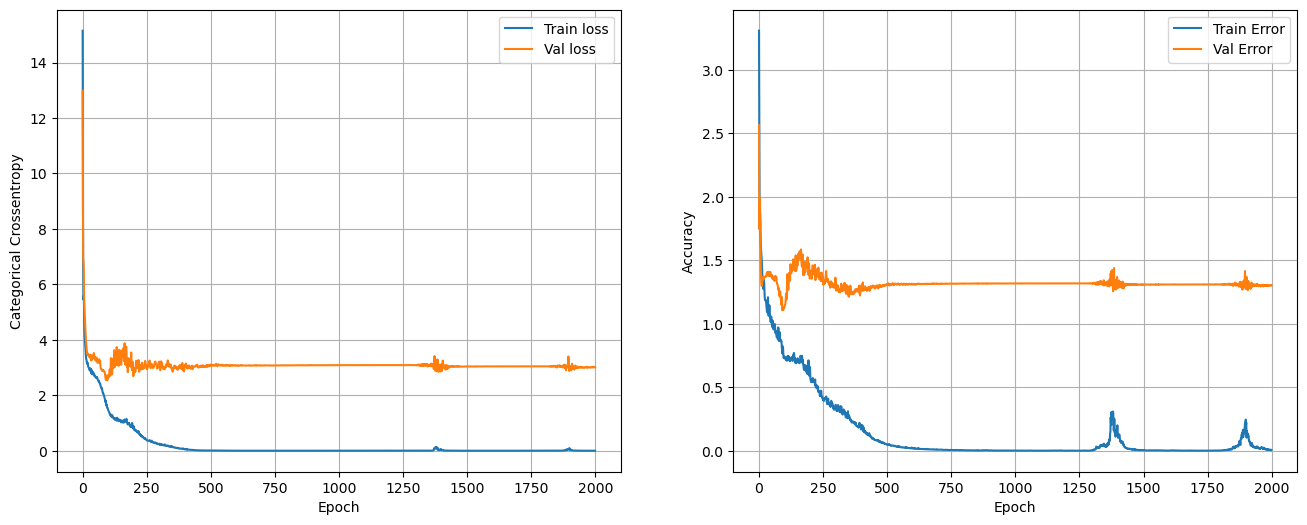

In [464]:
show_loss_accuracy_evolution(history)

Test Loss: 12.019649505615234
Test Accuracy: 2.2450754642486572
36/36 [==============================] - 0s 2ms/step
Coeficiente de correlacion: 0.4169264975513821


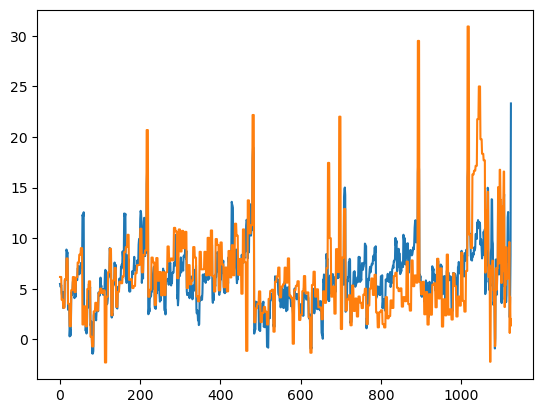

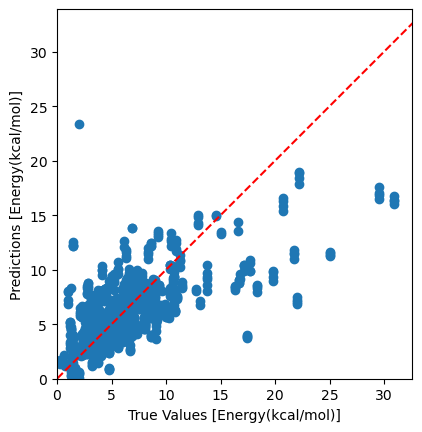

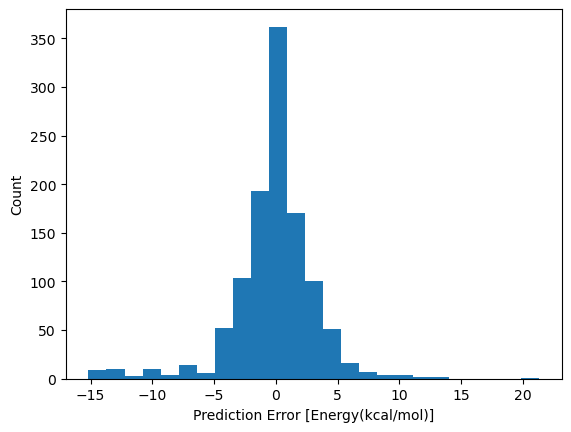

In [465]:
show_results(model,X_test,y_test)

dict_keys(['inputs', 'conv_1', 'flatten', 'dense', 'output'])


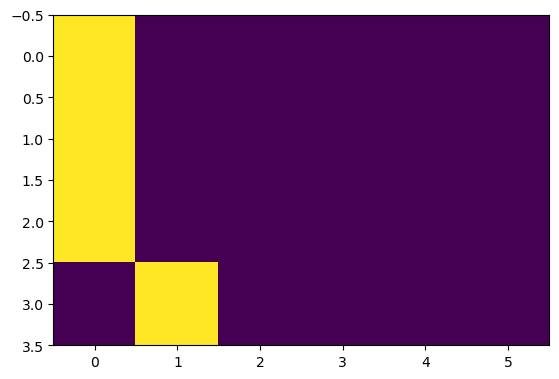

In [466]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

feature_maps shape:  (1, 4, 6, 64)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 64 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

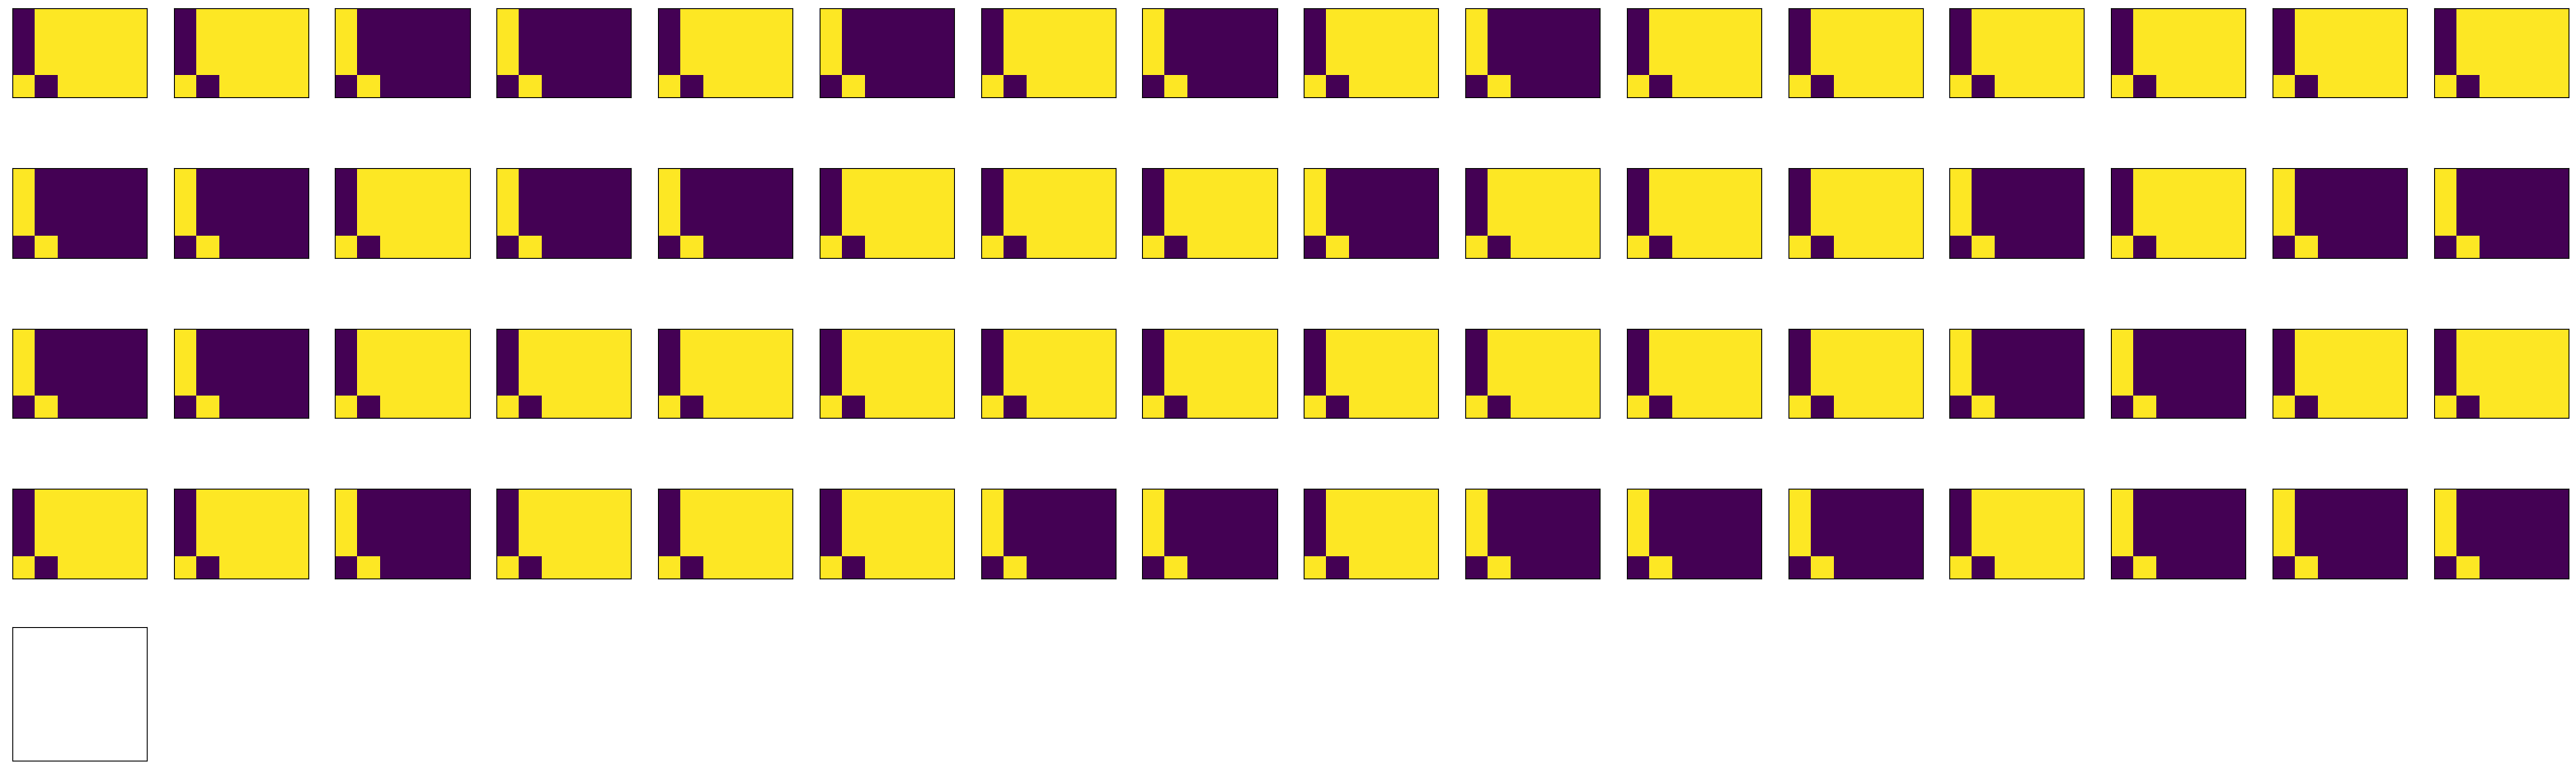

In [467]:
show_features(features,'conv_1')

feature_maps shape:  (1, 4, 6, 64)


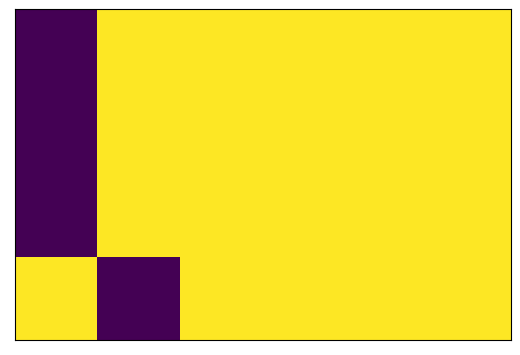

tf.Tensor(
[[-0.2693929  -0.00156283 -0.00156283 -0.00156283 -0.00156283 -0.00156283]
 [-0.2693929  -0.00156283 -0.00156283 -0.00156283 -0.00156283 -0.00156283]
 [-0.2693929  -0.00156283 -0.00156283 -0.00156283 -0.00156283 -0.00156283]
 [-0.00156283 -0.2693929  -0.00156283 -0.00156283 -0.00156283 -0.00156283]], shape=(4, 6), dtype=float32)


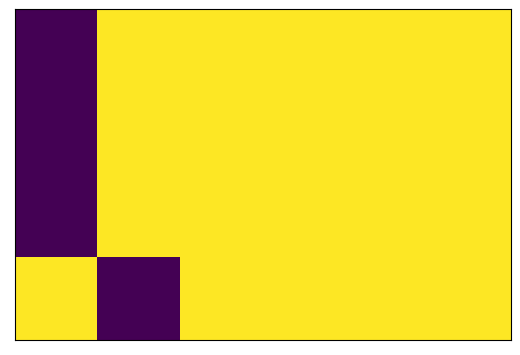

tf.Tensor(
[[-0.27552807  0.00324495  0.00324495  0.00324495  0.00324495  0.00324495]
 [-0.27552807  0.00324495  0.00324495  0.00324495  0.00324495  0.00324495]
 [-0.27552807  0.00324495  0.00324495  0.00324495  0.00324495  0.00324495]
 [ 0.00324495 -0.27552807  0.00324495  0.00324495  0.00324495  0.00324495]], shape=(4, 6), dtype=float32)


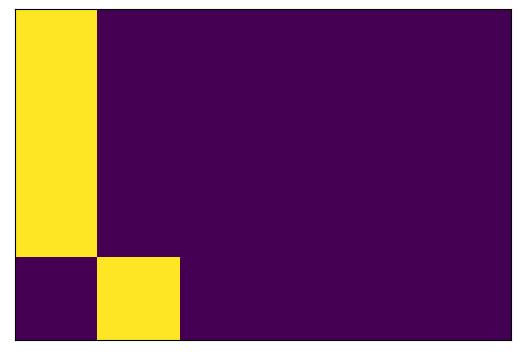

tf.Tensor(
[[ 0.23947676 -0.00083184 -0.00083184 -0.00083184 -0.00083184 -0.00083184]
 [ 0.23947676 -0.00083184 -0.00083184 -0.00083184 -0.00083184 -0.00083184]
 [ 0.23947676 -0.00083184 -0.00083184 -0.00083184 -0.00083184 -0.00083184]
 [-0.00083184  0.23947676 -0.00083184 -0.00083184 -0.00083184 -0.00083184]], shape=(4, 6), dtype=float32)


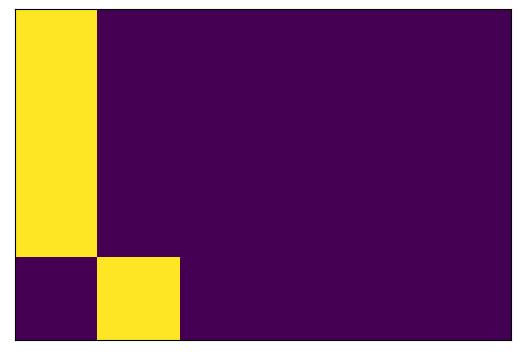

tf.Tensor(
[[0.31274772 0.01022501 0.01022501 0.01022501 0.01022501 0.01022501]
 [0.31274772 0.01022501 0.01022501 0.01022501 0.01022501 0.01022501]
 [0.31274772 0.01022501 0.01022501 0.01022501 0.01022501 0.01022501]
 [0.01022501 0.31274772 0.01022501 0.01022501 0.01022501 0.01022501]], shape=(4, 6), dtype=float32)


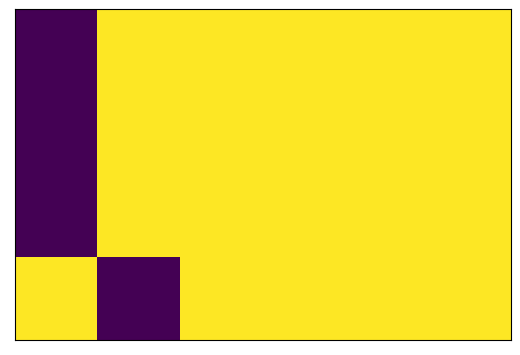

tf.Tensor(
[[-0.1716379   0.00844797  0.00844797  0.00844797  0.00844797  0.00844797]
 [-0.1716379   0.00844797  0.00844797  0.00844797  0.00844797  0.00844797]
 [-0.1716379   0.00844797  0.00844797  0.00844797  0.00844797  0.00844797]
 [ 0.00844797 -0.1716379   0.00844797  0.00844797  0.00844797  0.00844797]], shape=(4, 6), dtype=float32)


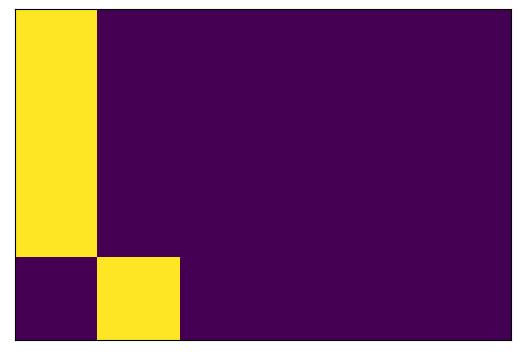

tf.Tensor(
[[0.2019801  0.00484538 0.00484538 0.00484538 0.00484538 0.00484538]
 [0.2019801  0.00484538 0.00484538 0.00484538 0.00484538 0.00484538]
 [0.2019801  0.00484538 0.00484538 0.00484538 0.00484538 0.00484538]
 [0.00484538 0.2019801  0.00484538 0.00484538 0.00484538 0.00484538]], shape=(4, 6), dtype=float32)


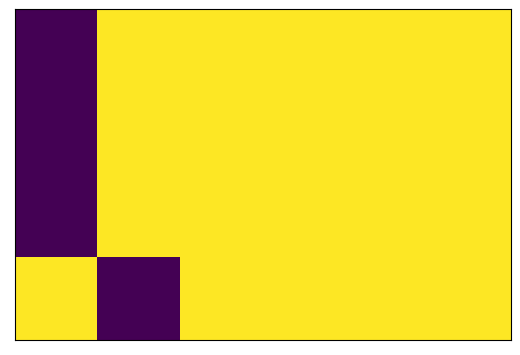

tf.Tensor(
[[-0.32876158 -0.00550866 -0.00550866 -0.00550866 -0.00550866 -0.00550866]
 [-0.32876158 -0.00550866 -0.00550866 -0.00550866 -0.00550866 -0.00550866]
 [-0.32876158 -0.00550866 -0.00550866 -0.00550866 -0.00550866 -0.00550866]
 [-0.00550866 -0.32876158 -0.00550866 -0.00550866 -0.00550866 -0.00550866]], shape=(4, 6), dtype=float32)


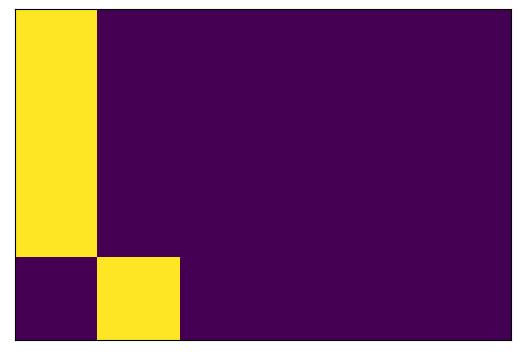

tf.Tensor(
[[2.3392282e-01 1.4988125e-04 1.4988125e-04 1.4988125e-04 1.4988125e-04
  1.4988125e-04]
 [2.3392282e-01 1.4988125e-04 1.4988125e-04 1.4988125e-04 1.4988125e-04
  1.4988125e-04]
 [2.3392282e-01 1.4988125e-04 1.4988125e-04 1.4988125e-04 1.4988125e-04
  1.4988125e-04]
 [1.4988125e-04 2.3392282e-01 1.4988125e-04 1.4988125e-04 1.4988125e-04
  1.4988125e-04]], shape=(4, 6), dtype=float32)


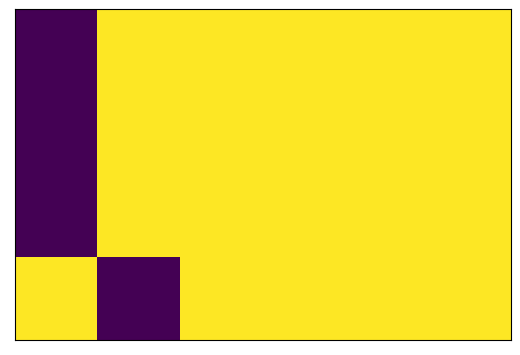

tf.Tensor(
[[-0.25119972 -0.00759035 -0.00759035 -0.00759035 -0.00759035 -0.00759035]
 [-0.25119972 -0.00759035 -0.00759035 -0.00759035 -0.00759035 -0.00759035]
 [-0.25119972 -0.00759035 -0.00759035 -0.00759035 -0.00759035 -0.00759035]
 [-0.00759035 -0.25119972 -0.00759035 -0.00759035 -0.00759035 -0.00759035]], shape=(4, 6), dtype=float32)


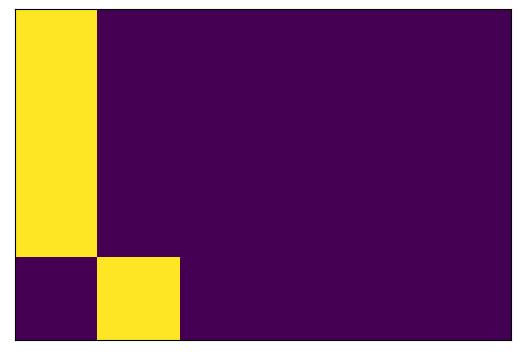

tf.Tensor(
[[ 0.15436481 -0.00273496 -0.00273496 -0.00273496 -0.00273496 -0.00273496]
 [ 0.15436481 -0.00273496 -0.00273496 -0.00273496 -0.00273496 -0.00273496]
 [ 0.15436481 -0.00273496 -0.00273496 -0.00273496 -0.00273496 -0.00273496]
 [-0.00273496  0.15436481 -0.00273496 -0.00273496 -0.00273496 -0.00273496]], shape=(4, 6), dtype=float32)


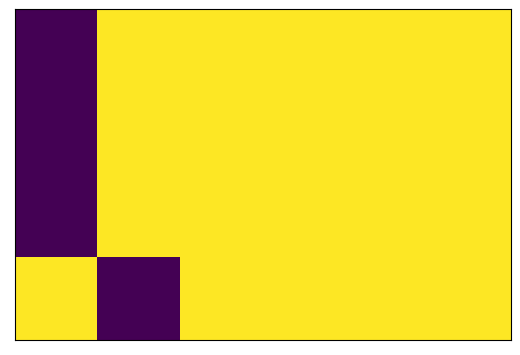

tf.Tensor(
[[-0.32193124  0.00347702  0.00347702  0.00347702  0.00347702  0.00347702]
 [-0.32193124  0.00347702  0.00347702  0.00347702  0.00347702  0.00347702]
 [-0.32193124  0.00347702  0.00347702  0.00347702  0.00347702  0.00347702]
 [ 0.00347702 -0.32193124  0.00347702  0.00347702  0.00347702  0.00347702]], shape=(4, 6), dtype=float32)


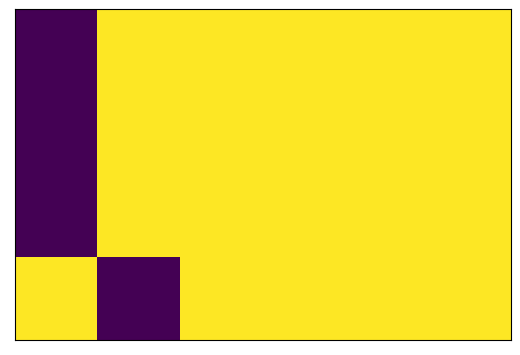

tf.Tensor(
[[-0.1988945  -0.00285536 -0.00285536 -0.00285536 -0.00285536 -0.00285536]
 [-0.1988945  -0.00285536 -0.00285536 -0.00285536 -0.00285536 -0.00285536]
 [-0.1988945  -0.00285536 -0.00285536 -0.00285536 -0.00285536 -0.00285536]
 [-0.00285536 -0.1988945  -0.00285536 -0.00285536 -0.00285536 -0.00285536]], shape=(4, 6), dtype=float32)


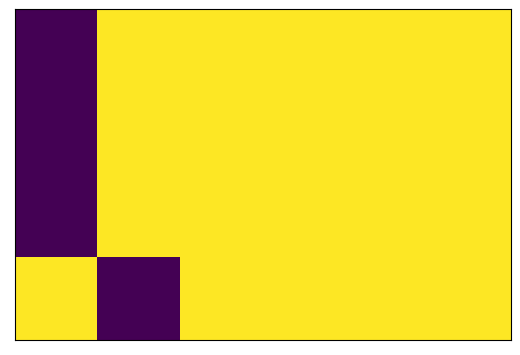

tf.Tensor(
[[-0.25566763  0.00310515  0.00310515  0.00310515  0.00310515  0.00310515]
 [-0.25566763  0.00310515  0.00310515  0.00310515  0.00310515  0.00310515]
 [-0.25566763  0.00310515  0.00310515  0.00310515  0.00310515  0.00310515]
 [ 0.00310515 -0.25566763  0.00310515  0.00310515  0.00310515  0.00310515]], shape=(4, 6), dtype=float32)


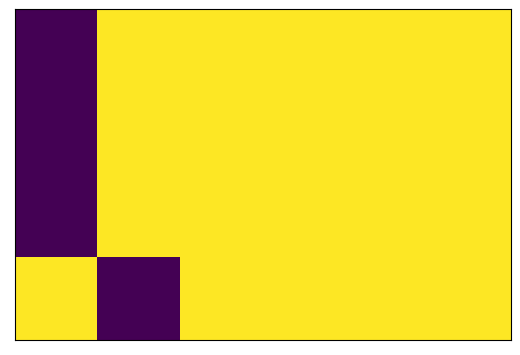

tf.Tensor(
[[-0.28911012 -0.00319397 -0.00319397 -0.00319397 -0.00319397 -0.00319397]
 [-0.28911012 -0.00319397 -0.00319397 -0.00319397 -0.00319397 -0.00319397]
 [-0.28911012 -0.00319397 -0.00319397 -0.00319397 -0.00319397 -0.00319397]
 [-0.00319397 -0.28911012 -0.00319397 -0.00319397 -0.00319397 -0.00319397]], shape=(4, 6), dtype=float32)


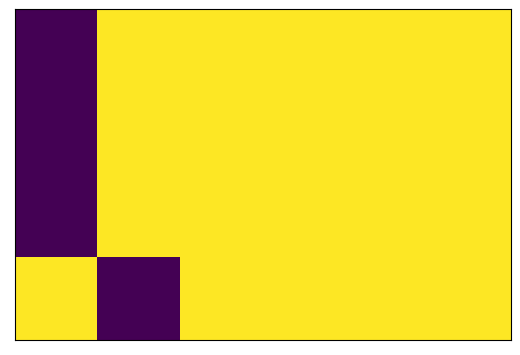

tf.Tensor(
[[-0.26797432 -0.00052899 -0.00052899 -0.00052899 -0.00052899 -0.00052899]
 [-0.26797432 -0.00052899 -0.00052899 -0.00052899 -0.00052899 -0.00052899]
 [-0.26797432 -0.00052899 -0.00052899 -0.00052899 -0.00052899 -0.00052899]
 [-0.00052899 -0.26797432 -0.00052899 -0.00052899 -0.00052899 -0.00052899]], shape=(4, 6), dtype=float32)


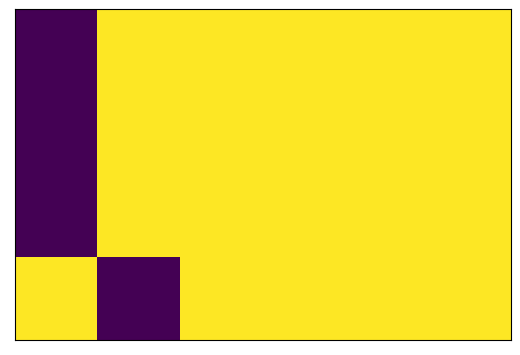

tf.Tensor(
[[-0.15985727 -0.00389409 -0.00389409 -0.00389409 -0.00389409 -0.00389409]
 [-0.15985727 -0.00389409 -0.00389409 -0.00389409 -0.00389409 -0.00389409]
 [-0.15985727 -0.00389409 -0.00389409 -0.00389409 -0.00389409 -0.00389409]
 [-0.00389409 -0.15985727 -0.00389409 -0.00389409 -0.00389409 -0.00389409]], shape=(4, 6), dtype=float32)


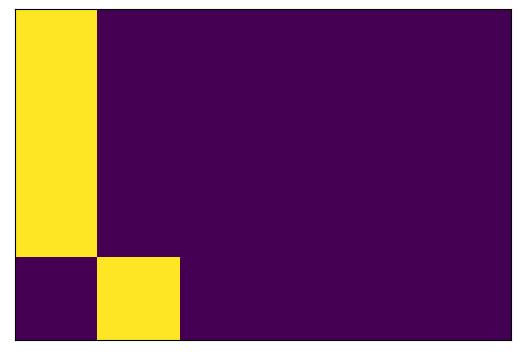

tf.Tensor(
[[0.1534561  0.00015377 0.00015377 0.00015377 0.00015377 0.00015377]
 [0.1534561  0.00015377 0.00015377 0.00015377 0.00015377 0.00015377]
 [0.1534561  0.00015377 0.00015377 0.00015377 0.00015377 0.00015377]
 [0.00015377 0.1534561  0.00015377 0.00015377 0.00015377 0.00015377]], shape=(4, 6), dtype=float32)


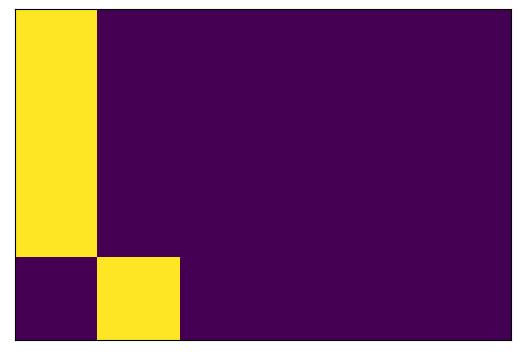

tf.Tensor(
[[ 0.2531827  -0.00228876 -0.00228876 -0.00228876 -0.00228876 -0.00228876]
 [ 0.2531827  -0.00228876 -0.00228876 -0.00228876 -0.00228876 -0.00228876]
 [ 0.2531827  -0.00228876 -0.00228876 -0.00228876 -0.00228876 -0.00228876]
 [-0.00228876  0.2531827  -0.00228876 -0.00228876 -0.00228876 -0.00228876]], shape=(4, 6), dtype=float32)


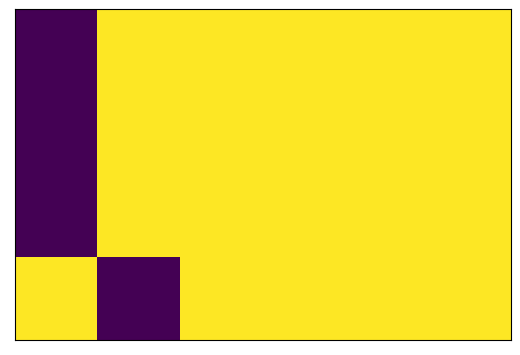

tf.Tensor(
[[-0.10862321  0.00070404  0.00070404  0.00070404  0.00070404  0.00070404]
 [-0.10862321  0.00070404  0.00070404  0.00070404  0.00070404  0.00070404]
 [-0.10862321  0.00070404  0.00070404  0.00070404  0.00070404  0.00070404]
 [ 0.00070404 -0.10862321  0.00070404  0.00070404  0.00070404  0.00070404]], shape=(4, 6), dtype=float32)


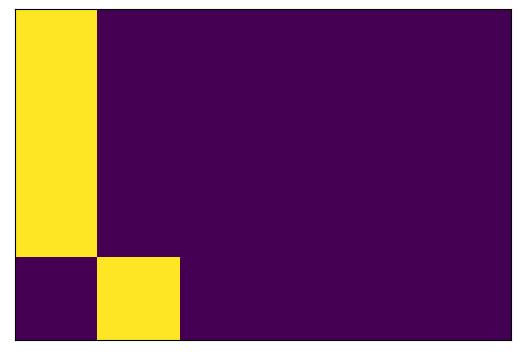

tf.Tensor(
[[0.38679755 0.00957356 0.00957356 0.00957356 0.00957356 0.00957356]
 [0.38679755 0.00957356 0.00957356 0.00957356 0.00957356 0.00957356]
 [0.38679755 0.00957356 0.00957356 0.00957356 0.00957356 0.00957356]
 [0.00957356 0.38679755 0.00957356 0.00957356 0.00957356 0.00957356]], shape=(4, 6), dtype=float32)


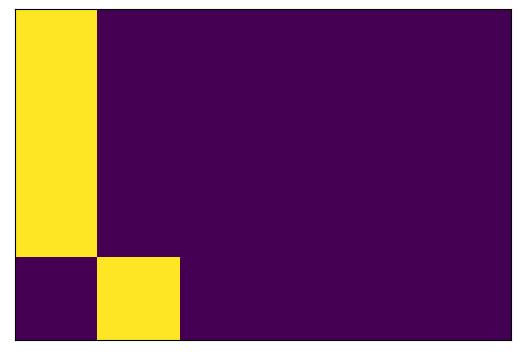

tf.Tensor(
[[ 0.27116296 -0.00379384 -0.00379384 -0.00379384 -0.00379384 -0.00379384]
 [ 0.27116296 -0.00379384 -0.00379384 -0.00379384 -0.00379384 -0.00379384]
 [ 0.27116296 -0.00379384 -0.00379384 -0.00379384 -0.00379384 -0.00379384]
 [-0.00379384  0.27116296 -0.00379384 -0.00379384 -0.00379384 -0.00379384]], shape=(4, 6), dtype=float32)


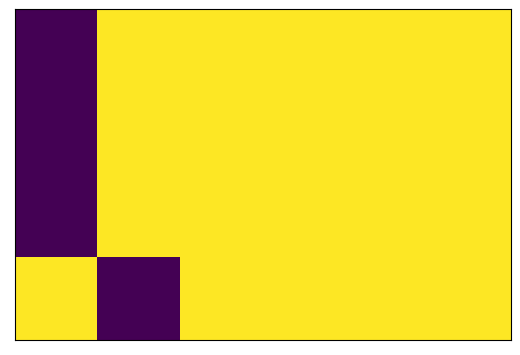

tf.Tensor(
[[-0.32177663  0.00472185  0.00472185  0.00472185  0.00472185  0.00472185]
 [-0.32177663  0.00472185  0.00472185  0.00472185  0.00472185  0.00472185]
 [-0.32177663  0.00472185  0.00472185  0.00472185  0.00472185  0.00472185]
 [ 0.00472185 -0.32177663  0.00472185  0.00472185  0.00472185  0.00472185]], shape=(4, 6), dtype=float32)


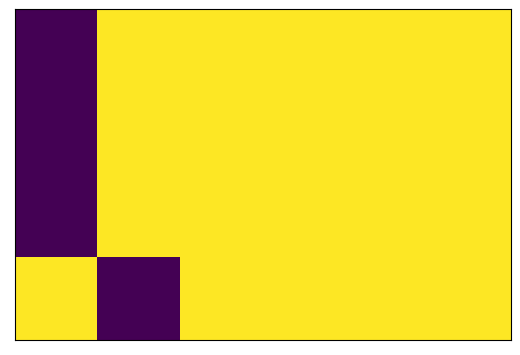

tf.Tensor(
[[-0.16877437  0.00937918  0.00937918  0.00937918  0.00937918  0.00937918]
 [-0.16877437  0.00937918  0.00937918  0.00937918  0.00937918  0.00937918]
 [-0.16877437  0.00937918  0.00937918  0.00937918  0.00937918  0.00937918]
 [ 0.00937918 -0.16877437  0.00937918  0.00937918  0.00937918  0.00937918]], shape=(4, 6), dtype=float32)


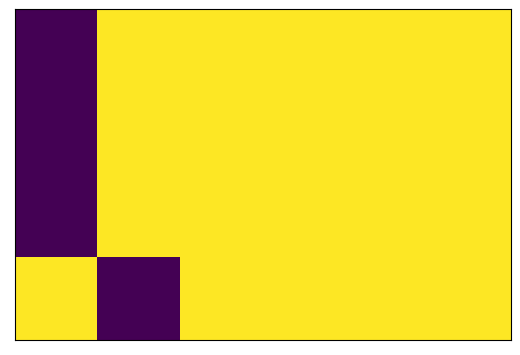

tf.Tensor(
[[-0.23798329  0.00068804  0.00068804  0.00068804  0.00068804  0.00068804]
 [-0.23798329  0.00068804  0.00068804  0.00068804  0.00068804  0.00068804]
 [-0.23798329  0.00068804  0.00068804  0.00068804  0.00068804  0.00068804]
 [ 0.00068804 -0.23798329  0.00068804  0.00068804  0.00068804  0.00068804]], shape=(4, 6), dtype=float32)


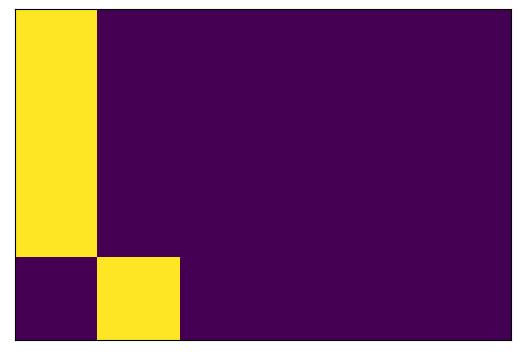

tf.Tensor(
[[0.39874324 0.0095402  0.0095402  0.0095402  0.0095402  0.0095402 ]
 [0.39874324 0.0095402  0.0095402  0.0095402  0.0095402  0.0095402 ]
 [0.39874324 0.0095402  0.0095402  0.0095402  0.0095402  0.0095402 ]
 [0.0095402  0.39874324 0.0095402  0.0095402  0.0095402  0.0095402 ]], shape=(4, 6), dtype=float32)


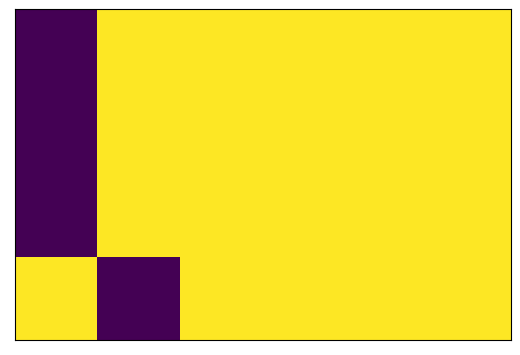

tf.Tensor(
[[-0.3325507 -0.0032075 -0.0032075 -0.0032075 -0.0032075 -0.0032075]
 [-0.3325507 -0.0032075 -0.0032075 -0.0032075 -0.0032075 -0.0032075]
 [-0.3325507 -0.0032075 -0.0032075 -0.0032075 -0.0032075 -0.0032075]
 [-0.0032075 -0.3325507 -0.0032075 -0.0032075 -0.0032075 -0.0032075]], shape=(4, 6), dtype=float32)


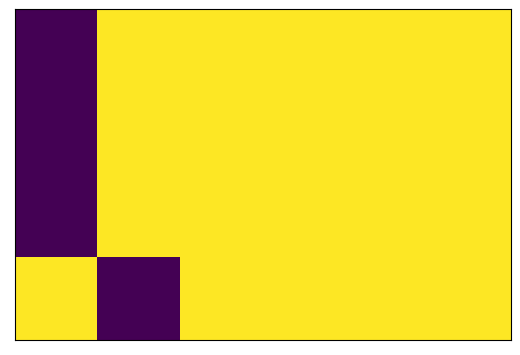

tf.Tensor(
[[-0.09654391  0.00314269  0.00314269  0.00314269  0.00314269  0.00314269]
 [-0.09654391  0.00314269  0.00314269  0.00314269  0.00314269  0.00314269]
 [-0.09654391  0.00314269  0.00314269  0.00314269  0.00314269  0.00314269]
 [ 0.00314269 -0.09654391  0.00314269  0.00314269  0.00314269  0.00314269]], shape=(4, 6), dtype=float32)


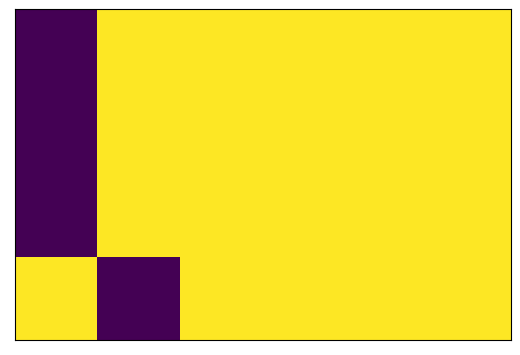

tf.Tensor(
[[-0.20261991  0.00520088  0.00520088  0.00520088  0.00520088  0.00520088]
 [-0.20261991  0.00520088  0.00520088  0.00520088  0.00520088  0.00520088]
 [-0.20261991  0.00520088  0.00520088  0.00520088  0.00520088  0.00520088]
 [ 0.00520088 -0.20261991  0.00520088  0.00520088  0.00520088  0.00520088]], shape=(4, 6), dtype=float32)


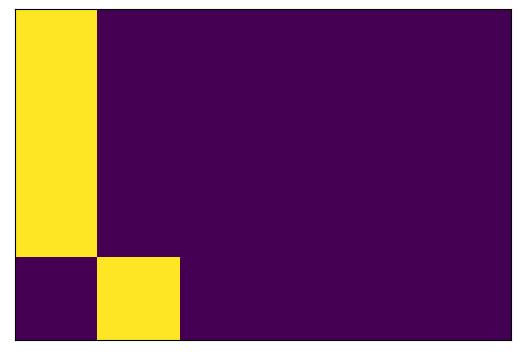

tf.Tensor(
[[0.29051903 0.00694549 0.00694549 0.00694549 0.00694549 0.00694549]
 [0.29051903 0.00694549 0.00694549 0.00694549 0.00694549 0.00694549]
 [0.29051903 0.00694549 0.00694549 0.00694549 0.00694549 0.00694549]
 [0.00694549 0.29051903 0.00694549 0.00694549 0.00694549 0.00694549]], shape=(4, 6), dtype=float32)


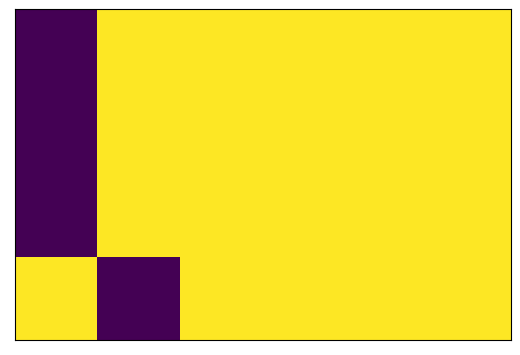

tf.Tensor(
[[-0.26805586 -0.00913829 -0.00913829 -0.00913829 -0.00913829 -0.00913829]
 [-0.26805586 -0.00913829 -0.00913829 -0.00913829 -0.00913829 -0.00913829]
 [-0.26805586 -0.00913829 -0.00913829 -0.00913829 -0.00913829 -0.00913829]
 [-0.00913829 -0.26805586 -0.00913829 -0.00913829 -0.00913829 -0.00913829]], shape=(4, 6), dtype=float32)


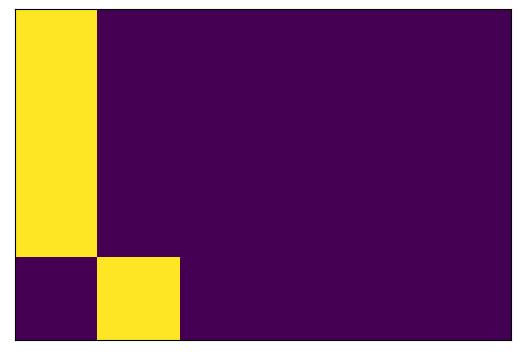

tf.Tensor(
[[0.24121    0.00144512 0.00144512 0.00144512 0.00144512 0.00144512]
 [0.24121    0.00144512 0.00144512 0.00144512 0.00144512 0.00144512]
 [0.24121    0.00144512 0.00144512 0.00144512 0.00144512 0.00144512]
 [0.00144512 0.24121    0.00144512 0.00144512 0.00144512 0.00144512]], shape=(4, 6), dtype=float32)


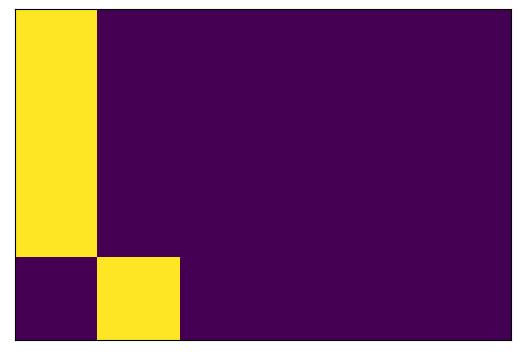

tf.Tensor(
[[0.3286852  0.00859572 0.00859572 0.00859572 0.00859572 0.00859572]
 [0.3286852  0.00859572 0.00859572 0.00859572 0.00859572 0.00859572]
 [0.3286852  0.00859572 0.00859572 0.00859572 0.00859572 0.00859572]
 [0.00859572 0.3286852  0.00859572 0.00859572 0.00859572 0.00859572]], shape=(4, 6), dtype=float32)


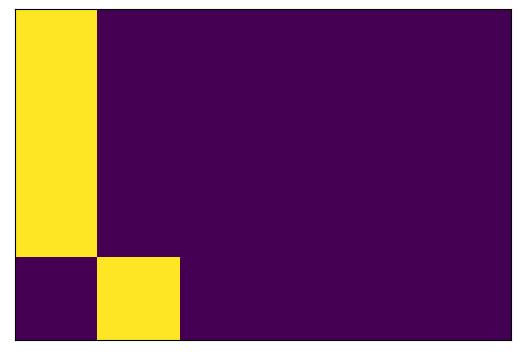

tf.Tensor(
[[0.23107925 0.00435147 0.00435147 0.00435147 0.00435147 0.00435147]
 [0.23107925 0.00435147 0.00435147 0.00435147 0.00435147 0.00435147]
 [0.23107925 0.00435147 0.00435147 0.00435147 0.00435147 0.00435147]
 [0.00435147 0.23107925 0.00435147 0.00435147 0.00435147 0.00435147]], shape=(4, 6), dtype=float32)


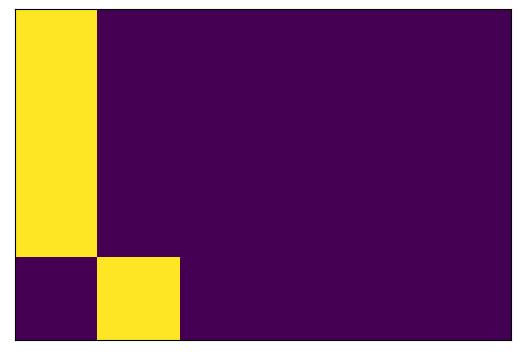

tf.Tensor(
[[0.32830536 0.00913192 0.00913192 0.00913192 0.00913192 0.00913192]
 [0.32830536 0.00913192 0.00913192 0.00913192 0.00913192 0.00913192]
 [0.32830536 0.00913192 0.00913192 0.00913192 0.00913192 0.00913192]
 [0.00913192 0.32830536 0.00913192 0.00913192 0.00913192 0.00913192]], shape=(4, 6), dtype=float32)


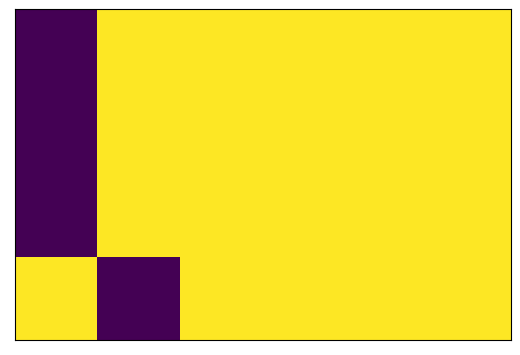

tf.Tensor(
[[-0.35319918  0.00684814  0.00684814  0.00684814  0.00684814  0.00684814]
 [-0.35319918  0.00684814  0.00684814  0.00684814  0.00684814  0.00684814]
 [-0.35319918  0.00684814  0.00684814  0.00684814  0.00684814  0.00684814]
 [ 0.00684814 -0.35319918  0.00684814  0.00684814  0.00684814  0.00684814]], shape=(4, 6), dtype=float32)


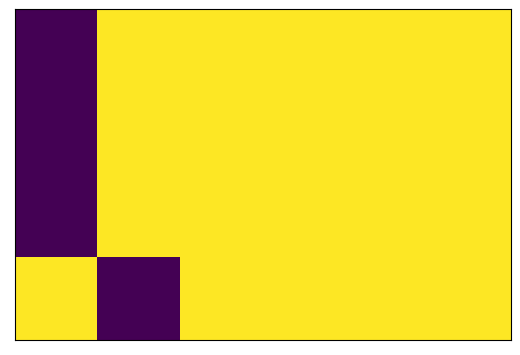

tf.Tensor(
[[-0.1241737   0.00107378  0.00107378  0.00107378  0.00107378  0.00107378]
 [-0.1241737   0.00107378  0.00107378  0.00107378  0.00107378  0.00107378]
 [-0.1241737   0.00107378  0.00107378  0.00107378  0.00107378  0.00107378]
 [ 0.00107378 -0.1241737   0.00107378  0.00107378  0.00107378  0.00107378]], shape=(4, 6), dtype=float32)


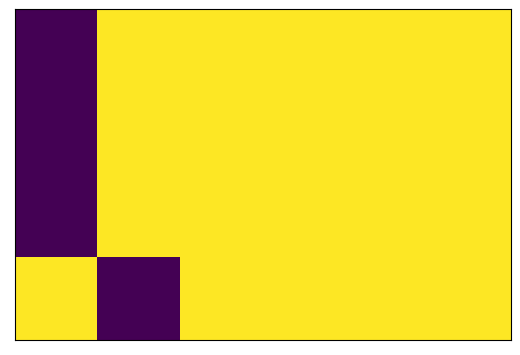

tf.Tensor(
[[-0.20951748  0.00781262  0.00781262  0.00781262  0.00781262  0.00781262]
 [-0.20951748  0.00781262  0.00781262  0.00781262  0.00781262  0.00781262]
 [-0.20951748  0.00781262  0.00781262  0.00781262  0.00781262  0.00781262]
 [ 0.00781262 -0.20951748  0.00781262  0.00781262  0.00781262  0.00781262]], shape=(4, 6), dtype=float32)


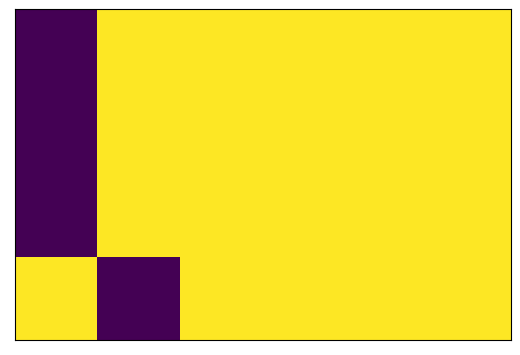

tf.Tensor(
[[-0.29537755 -0.00322688 -0.00322688 -0.00322688 -0.00322688 -0.00322688]
 [-0.29537755 -0.00322688 -0.00322688 -0.00322688 -0.00322688 -0.00322688]
 [-0.29537755 -0.00322688 -0.00322688 -0.00322688 -0.00322688 -0.00322688]
 [-0.00322688 -0.29537755 -0.00322688 -0.00322688 -0.00322688 -0.00322688]], shape=(4, 6), dtype=float32)


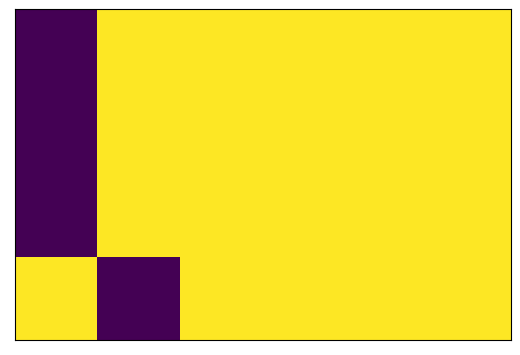

tf.Tensor(
[[-0.15492141 -0.00213909 -0.00213909 -0.00213909 -0.00213909 -0.00213909]
 [-0.15492141 -0.00213909 -0.00213909 -0.00213909 -0.00213909 -0.00213909]
 [-0.15492141 -0.00213909 -0.00213909 -0.00213909 -0.00213909 -0.00213909]
 [-0.00213909 -0.15492141 -0.00213909 -0.00213909 -0.00213909 -0.00213909]], shape=(4, 6), dtype=float32)


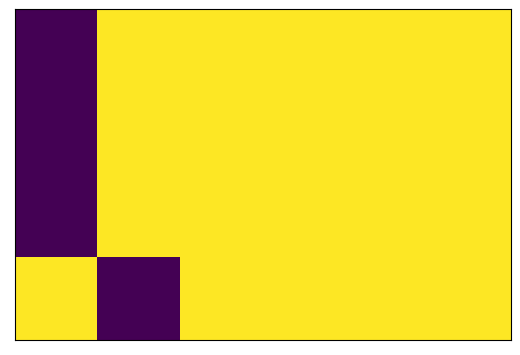

tf.Tensor(
[[-0.27103335  0.00100962  0.00100962  0.00100962  0.00100962  0.00100962]
 [-0.27103335  0.00100962  0.00100962  0.00100962  0.00100962  0.00100962]
 [-0.27103335  0.00100962  0.00100962  0.00100962  0.00100962  0.00100962]
 [ 0.00100962 -0.27103335  0.00100962  0.00100962  0.00100962  0.00100962]], shape=(4, 6), dtype=float32)


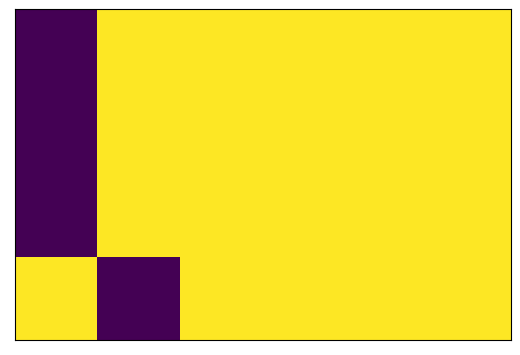

tf.Tensor(
[[-0.3268003  -0.00382441 -0.00382441 -0.00382441 -0.00382441 -0.00382441]
 [-0.3268003  -0.00382441 -0.00382441 -0.00382441 -0.00382441 -0.00382441]
 [-0.3268003  -0.00382441 -0.00382441 -0.00382441 -0.00382441 -0.00382441]
 [-0.00382441 -0.3268003  -0.00382441 -0.00382441 -0.00382441 -0.00382441]], shape=(4, 6), dtype=float32)


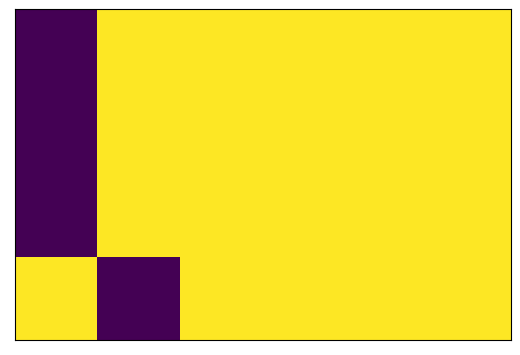

tf.Tensor(
[[-0.30272567  0.00548386  0.00548386  0.00548386  0.00548386  0.00548386]
 [-0.30272567  0.00548386  0.00548386  0.00548386  0.00548386  0.00548386]
 [-0.30272567  0.00548386  0.00548386  0.00548386  0.00548386  0.00548386]
 [ 0.00548386 -0.30272567  0.00548386  0.00548386  0.00548386  0.00548386]], shape=(4, 6), dtype=float32)


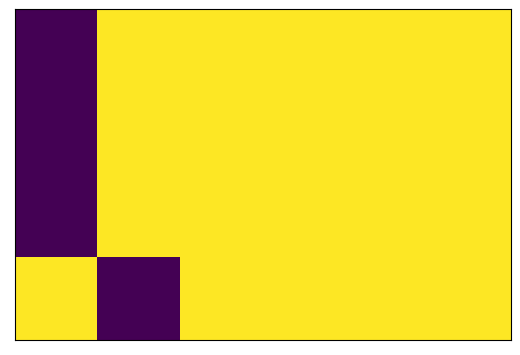

tf.Tensor(
[[-0.19613165  0.00175971  0.00175971  0.00175971  0.00175971  0.00175971]
 [-0.19613165  0.00175971  0.00175971  0.00175971  0.00175971  0.00175971]
 [-0.19613165  0.00175971  0.00175971  0.00175971  0.00175971  0.00175971]
 [ 0.00175971 -0.19613165  0.00175971  0.00175971  0.00175971  0.00175971]], shape=(4, 6), dtype=float32)


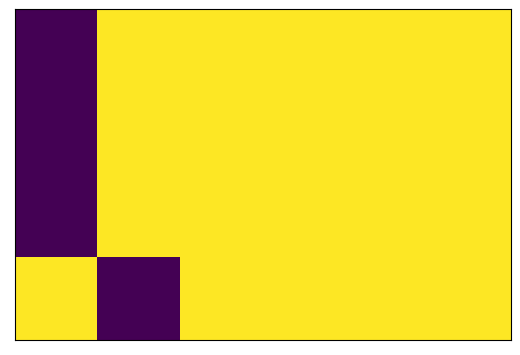

tf.Tensor(
[[-0.32979494 -0.00845224 -0.00845224 -0.00845224 -0.00845224 -0.00845224]
 [-0.32979494 -0.00845224 -0.00845224 -0.00845224 -0.00845224 -0.00845224]
 [-0.32979494 -0.00845224 -0.00845224 -0.00845224 -0.00845224 -0.00845224]
 [-0.00845224 -0.32979494 -0.00845224 -0.00845224 -0.00845224 -0.00845224]], shape=(4, 6), dtype=float32)


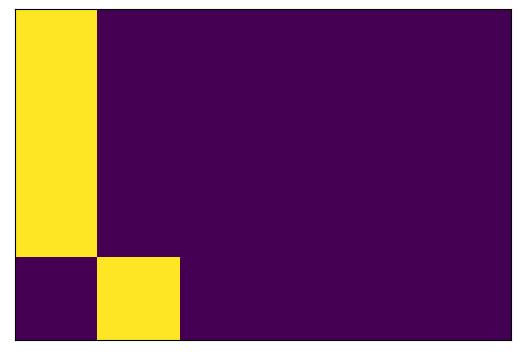

tf.Tensor(
[[0.42409074 0.00462548 0.00462548 0.00462548 0.00462548 0.00462548]
 [0.42409074 0.00462548 0.00462548 0.00462548 0.00462548 0.00462548]
 [0.42409074 0.00462548 0.00462548 0.00462548 0.00462548 0.00462548]
 [0.00462548 0.42409074 0.00462548 0.00462548 0.00462548 0.00462548]], shape=(4, 6), dtype=float32)


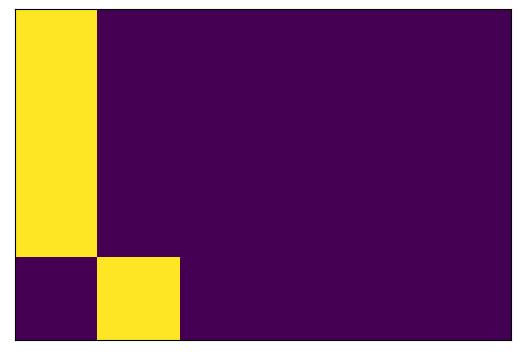

tf.Tensor(
[[0.34660766 0.00752753 0.00752753 0.00752753 0.00752753 0.00752753]
 [0.34660766 0.00752753 0.00752753 0.00752753 0.00752753 0.00752753]
 [0.34660766 0.00752753 0.00752753 0.00752753 0.00752753 0.00752753]
 [0.00752753 0.34660766 0.00752753 0.00752753 0.00752753 0.00752753]], shape=(4, 6), dtype=float32)


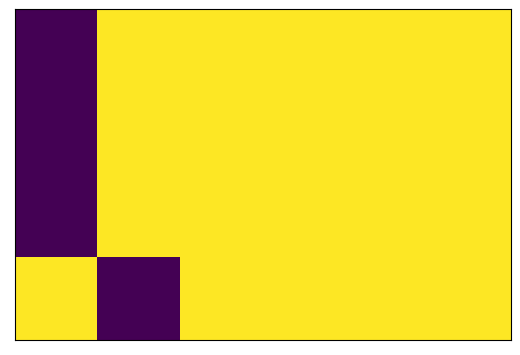

tf.Tensor(
[[-0.14253777  0.00754116  0.00754116  0.00754116  0.00754116  0.00754116]
 [-0.14253777  0.00754116  0.00754116  0.00754116  0.00754116  0.00754116]
 [-0.14253777  0.00754116  0.00754116  0.00754116  0.00754116  0.00754116]
 [ 0.00754116 -0.14253777  0.00754116  0.00754116  0.00754116  0.00754116]], shape=(4, 6), dtype=float32)


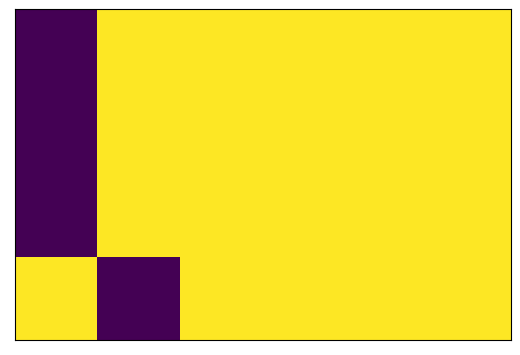

tf.Tensor(
[[-0.3132301  -0.00482583 -0.00482583 -0.00482583 -0.00482583 -0.00482583]
 [-0.3132301  -0.00482583 -0.00482583 -0.00482583 -0.00482583 -0.00482583]
 [-0.3132301  -0.00482583 -0.00482583 -0.00482583 -0.00482583 -0.00482583]
 [-0.00482583 -0.3132301  -0.00482583 -0.00482583 -0.00482583 -0.00482583]], shape=(4, 6), dtype=float32)


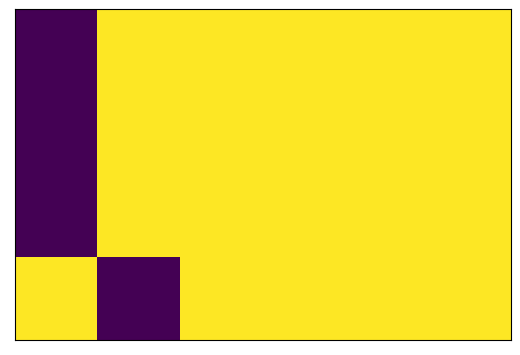

tf.Tensor(
[[-0.26025045  0.008068    0.008068    0.008068    0.008068    0.008068  ]
 [-0.26025045  0.008068    0.008068    0.008068    0.008068    0.008068  ]
 [-0.26025045  0.008068    0.008068    0.008068    0.008068    0.008068  ]
 [ 0.008068   -0.26025045  0.008068    0.008068    0.008068    0.008068  ]], shape=(4, 6), dtype=float32)


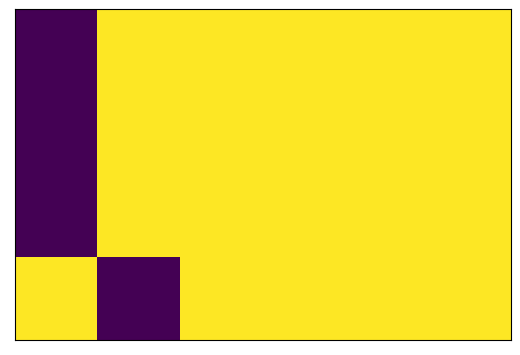

tf.Tensor(
[[-0.300008   -0.00702614 -0.00702614 -0.00702614 -0.00702614 -0.00702614]
 [-0.300008   -0.00702614 -0.00702614 -0.00702614 -0.00702614 -0.00702614]
 [-0.300008   -0.00702614 -0.00702614 -0.00702614 -0.00702614 -0.00702614]
 [-0.00702614 -0.300008   -0.00702614 -0.00702614 -0.00702614 -0.00702614]], shape=(4, 6), dtype=float32)


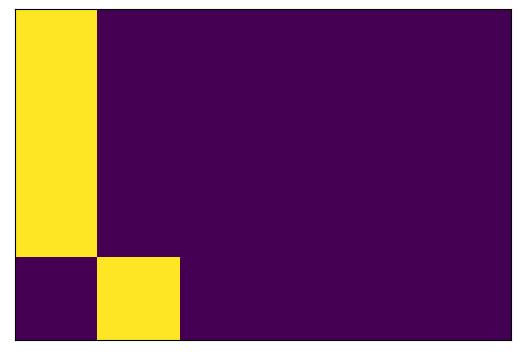

tf.Tensor(
[[0.4528967  0.00365638 0.00365638 0.00365638 0.00365638 0.00365638]
 [0.4528967  0.00365638 0.00365638 0.00365638 0.00365638 0.00365638]
 [0.4528967  0.00365638 0.00365638 0.00365638 0.00365638 0.00365638]
 [0.00365638 0.4528967  0.00365638 0.00365638 0.00365638 0.00365638]], shape=(4, 6), dtype=float32)


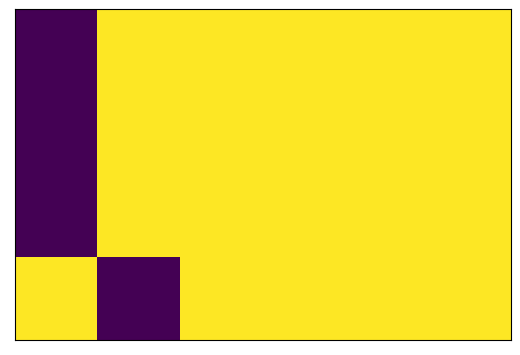

tf.Tensor(
[[-0.16601509  0.01007833  0.01007833  0.01007833  0.01007833  0.01007833]
 [-0.16601509  0.01007833  0.01007833  0.01007833  0.01007833  0.01007833]
 [-0.16601509  0.01007833  0.01007833  0.01007833  0.01007833  0.01007833]
 [ 0.01007833 -0.16601509  0.01007833  0.01007833  0.01007833  0.01007833]], shape=(4, 6), dtype=float32)


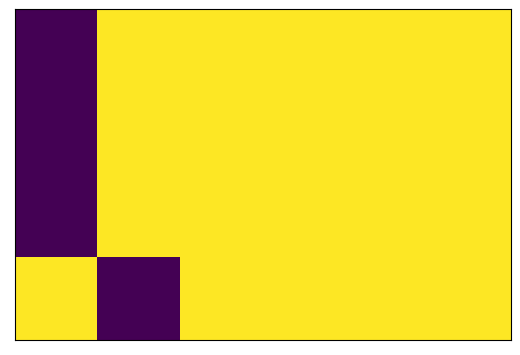

tf.Tensor(
[[-0.22464854  0.00126998  0.00126998  0.00126998  0.00126998  0.00126998]
 [-0.22464854  0.00126998  0.00126998  0.00126998  0.00126998  0.00126998]
 [-0.22464854  0.00126998  0.00126998  0.00126998  0.00126998  0.00126998]
 [ 0.00126998 -0.22464854  0.00126998  0.00126998  0.00126998  0.00126998]], shape=(4, 6), dtype=float32)


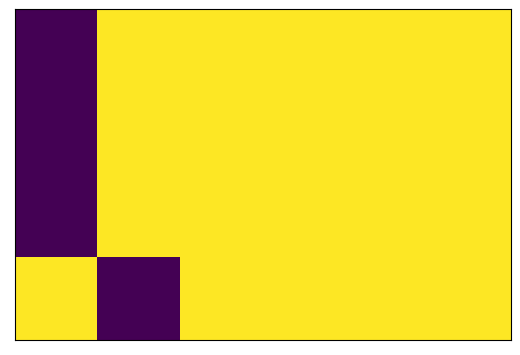

tf.Tensor(
[[-0.2004593 -0.0035547 -0.0035547 -0.0035547 -0.0035547 -0.0035547]
 [-0.2004593 -0.0035547 -0.0035547 -0.0035547 -0.0035547 -0.0035547]
 [-0.2004593 -0.0035547 -0.0035547 -0.0035547 -0.0035547 -0.0035547]
 [-0.0035547 -0.2004593 -0.0035547 -0.0035547 -0.0035547 -0.0035547]], shape=(4, 6), dtype=float32)


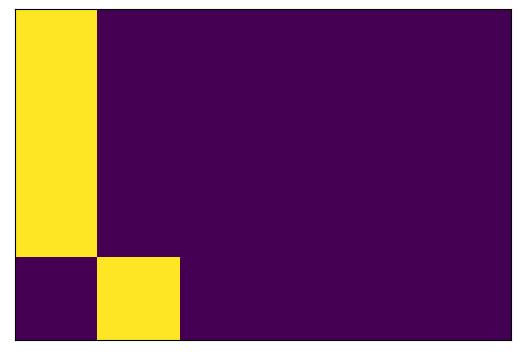

tf.Tensor(
[[ 0.20227441 -0.00718892 -0.00718892 -0.00718892 -0.00718892 -0.00718892]
 [ 0.20227441 -0.00718892 -0.00718892 -0.00718892 -0.00718892 -0.00718892]
 [ 0.20227441 -0.00718892 -0.00718892 -0.00718892 -0.00718892 -0.00718892]
 [-0.00718892  0.20227441 -0.00718892 -0.00718892 -0.00718892 -0.00718892]], shape=(4, 6), dtype=float32)


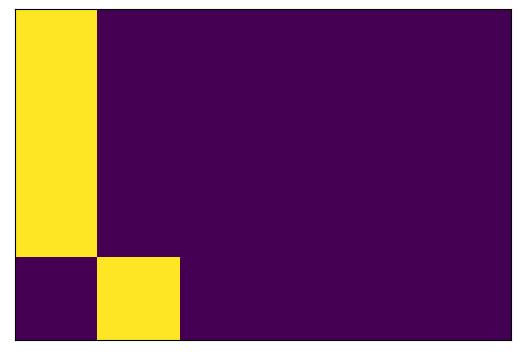

tf.Tensor(
[[ 0.3101293  -0.00121981 -0.00121981 -0.00121981 -0.00121981 -0.00121981]
 [ 0.3101293  -0.00121981 -0.00121981 -0.00121981 -0.00121981 -0.00121981]
 [ 0.3101293  -0.00121981 -0.00121981 -0.00121981 -0.00121981 -0.00121981]
 [-0.00121981  0.3101293  -0.00121981 -0.00121981 -0.00121981 -0.00121981]], shape=(4, 6), dtype=float32)


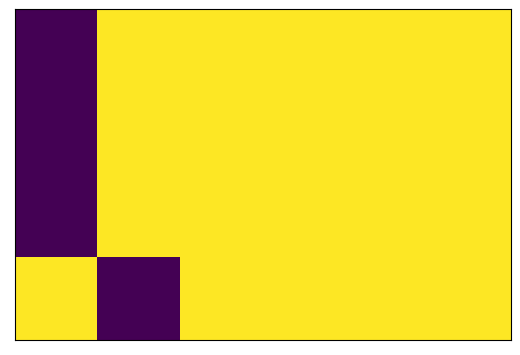

tf.Tensor(
[[-0.30536515  0.00721665  0.00721665  0.00721665  0.00721665  0.00721665]
 [-0.30536515  0.00721665  0.00721665  0.00721665  0.00721665  0.00721665]
 [-0.30536515  0.00721665  0.00721665  0.00721665  0.00721665  0.00721665]
 [ 0.00721665 -0.30536515  0.00721665  0.00721665  0.00721665  0.00721665]], shape=(4, 6), dtype=float32)


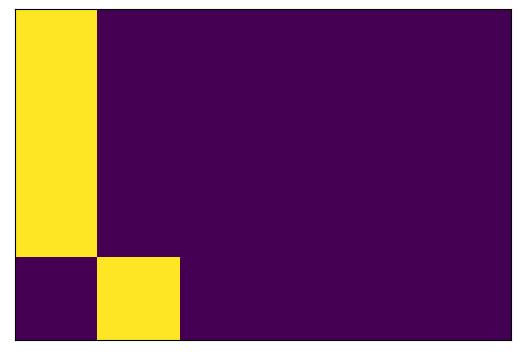

tf.Tensor(
[[ 0.22815649 -0.00398159 -0.00398159 -0.00398159 -0.00398159 -0.00398159]
 [ 0.22815649 -0.00398159 -0.00398159 -0.00398159 -0.00398159 -0.00398159]
 [ 0.22815649 -0.00398159 -0.00398159 -0.00398159 -0.00398159 -0.00398159]
 [-0.00398159  0.22815649 -0.00398159 -0.00398159 -0.00398159 -0.00398159]], shape=(4, 6), dtype=float32)


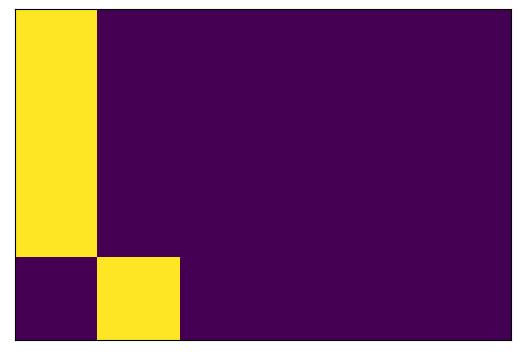

tf.Tensor(
[[ 0.33683473 -0.00182265 -0.00182265 -0.00182265 -0.00182265 -0.00182265]
 [ 0.33683473 -0.00182265 -0.00182265 -0.00182265 -0.00182265 -0.00182265]
 [ 0.33683473 -0.00182265 -0.00182265 -0.00182265 -0.00182265 -0.00182265]
 [-0.00182265  0.33683473 -0.00182265 -0.00182265 -0.00182265 -0.00182265]], shape=(4, 6), dtype=float32)


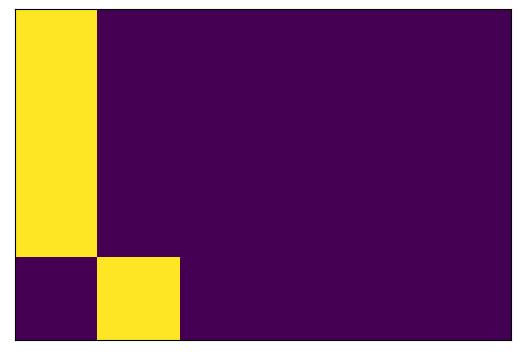

tf.Tensor(
[[0.211007   0.00352799 0.00352799 0.00352799 0.00352799 0.00352799]
 [0.211007   0.00352799 0.00352799 0.00352799 0.00352799 0.00352799]
 [0.211007   0.00352799 0.00352799 0.00352799 0.00352799 0.00352799]
 [0.00352799 0.211007   0.00352799 0.00352799 0.00352799 0.00352799]], shape=(4, 6), dtype=float32)


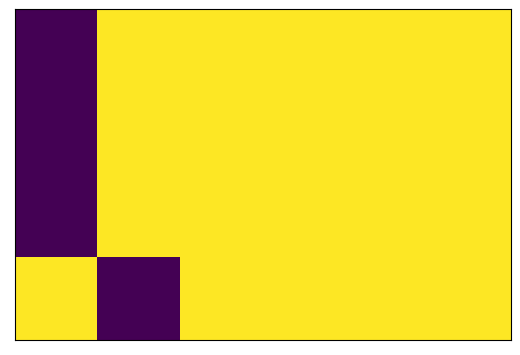

tf.Tensor(
[[-0.33323961 -0.00286424 -0.00286424 -0.00286424 -0.00286424 -0.00286424]
 [-0.33323961 -0.00286424 -0.00286424 -0.00286424 -0.00286424 -0.00286424]
 [-0.33323961 -0.00286424 -0.00286424 -0.00286424 -0.00286424 -0.00286424]
 [-0.00286424 -0.33323961 -0.00286424 -0.00286424 -0.00286424 -0.00286424]], shape=(4, 6), dtype=float32)


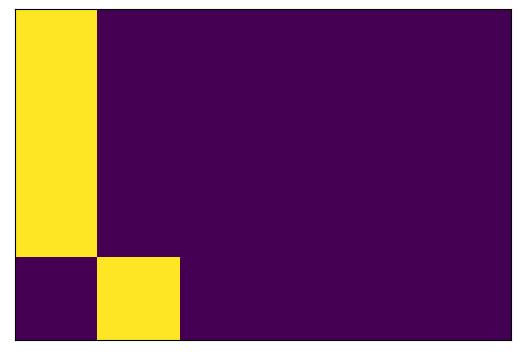

tf.Tensor(
[[ 0.1836344  -0.00676751 -0.00676751 -0.00676751 -0.00676751 -0.00676751]
 [ 0.1836344  -0.00676751 -0.00676751 -0.00676751 -0.00676751 -0.00676751]
 [ 0.1836344  -0.00676751 -0.00676751 -0.00676751 -0.00676751 -0.00676751]
 [-0.00676751  0.1836344  -0.00676751 -0.00676751 -0.00676751 -0.00676751]], shape=(4, 6), dtype=float32)


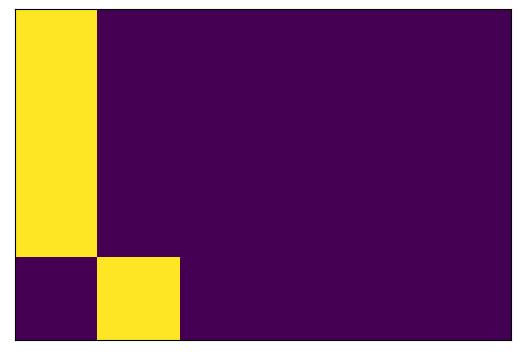

tf.Tensor(
[[0.17339222 0.0048041  0.0048041  0.0048041  0.0048041  0.0048041 ]
 [0.17339222 0.0048041  0.0048041  0.0048041  0.0048041  0.0048041 ]
 [0.17339222 0.0048041  0.0048041  0.0048041  0.0048041  0.0048041 ]
 [0.0048041  0.17339222 0.0048041  0.0048041  0.0048041  0.0048041 ]], shape=(4, 6), dtype=float32)


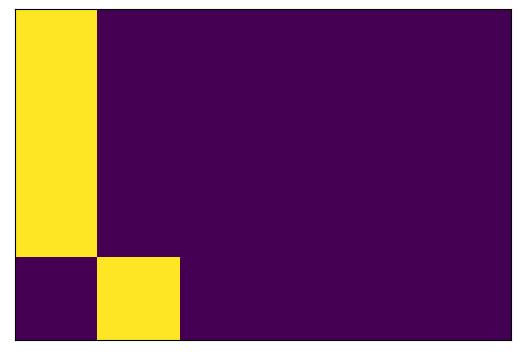

tf.Tensor(
[[0.33782506 0.00597539 0.00597539 0.00597539 0.00597539 0.00597539]
 [0.33782506 0.00597539 0.00597539 0.00597539 0.00597539 0.00597539]
 [0.33782506 0.00597539 0.00597539 0.00597539 0.00597539 0.00597539]
 [0.00597539 0.33782506 0.00597539 0.00597539 0.00597539 0.00597539]], shape=(4, 6), dtype=float32)


In [468]:
show_features2(features,'conv_1')

In [405]:
def ConvNN(filters=51, kernel_size=(7,7), unit1=168, unit2=157, unit3=205, unit4=12, dropout1=0.08161034482758621, dropout2=0.18786206896551724, dropout3=0.42844827586206896): 
    
    model = Sequential()
    #model.add(Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None))
    #model.add(Conv2D(filters=64, kernel_size=7, activation='relu', input_shape=(7, 42, 1) ))
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(4, 6, 1) ))

    model.add(Conv2D(64, 1, padding='same', activation='relu'))
    #model.add(MaxPooling2D(4))
    #model.add(Conv2D(64, 1, activation='relu'))
#    model.add(GlobalAveragePooling2D())
#    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    #model.add(Dense(units=294, activation='relu', input_dim=294))
    #model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=unit1, activation='relu'))
    model.add(Dropout(dropout1)) ##
    model.add(Dense(units=unit2, activation='relu'))
    model.add(Dropout(dropout2)) 
    model.add(Dense(units=unit3, activation='relu'))
    model.add(Dropout(dropout3)) ##
    model.add(Dense(units=unit4, activation='relu'))
    model.add(Dense(units=1, activation='linear'))                         #ingen aktivering til sidste lag, fordi vi Ã¸nsker den fulde vÃ¦rdi i outputtet
    #model.add(Dense(units=1))

    #model.compile(loss='logcosh', optimizer='adam', metrics=['accuracy']) #accuracy er en metric til classification
    model.compile(loss='logcosh', optimizer='Nadam', metrics=['mean_absolute_error'])

    
    return model

In [406]:
## DEFINE SOME EARLY STOPPING CONDITIONS
esNOSTOP = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)   #alternative patience=np.inf
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [407]:
model = ConvNN(filters=64, kernel_size=(2,2), unit1=96, unit2=48, unit3=24, unit4=12, dropout1=0.08161034482758621, dropout2=0.18786206896551724, dropout3=0.42844827586206896)

In [408]:
ITER = 500
BATCH = 32
VERBOSE = 0

#CALLBACKS = [esNOSTOP, reduce_lr]
CALLBACKS = []

start_time = time.time()

history = model.fit(X_train, y_train, epochs=ITER, batch_size=BATCH, validation_split=0.2, callbacks=CALLBACKS, verbose=VERBOSE)

print('Runtime:',(time.time()-start_time)/60,'minutes.')

Runtime: 0.4277946750322978 minutes.


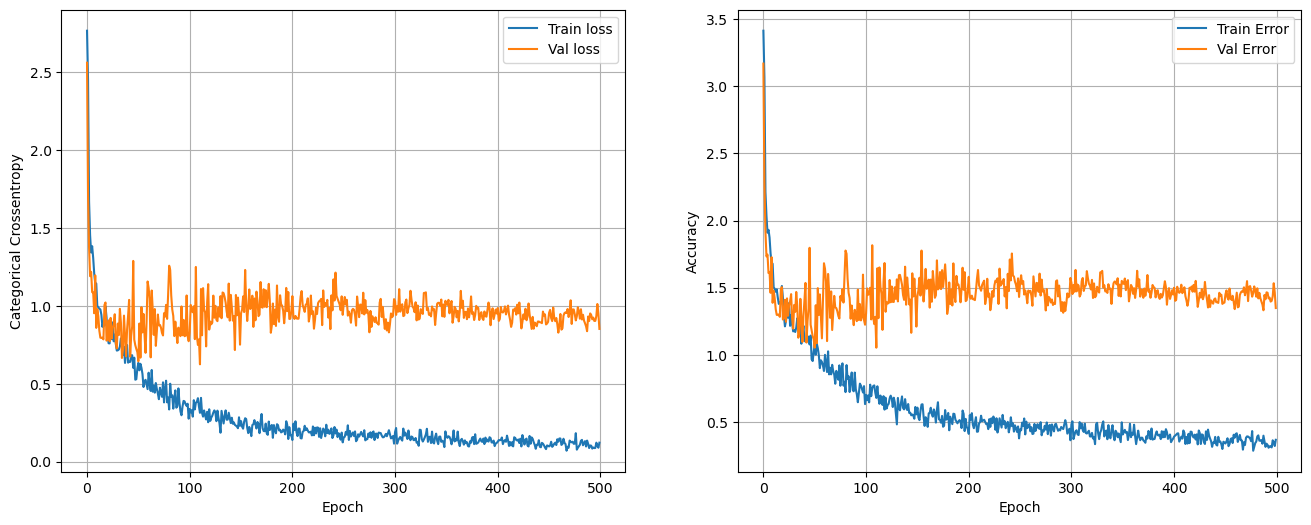

In [409]:
show_loss_accuracy_evolution(history)

Test Loss: 2.50919508934021
Test Accuracy: 3.1063437461853027
36/36 [==============================] - 0s 2ms/step
Coeficiente de correlacion: 0.009286923627426558


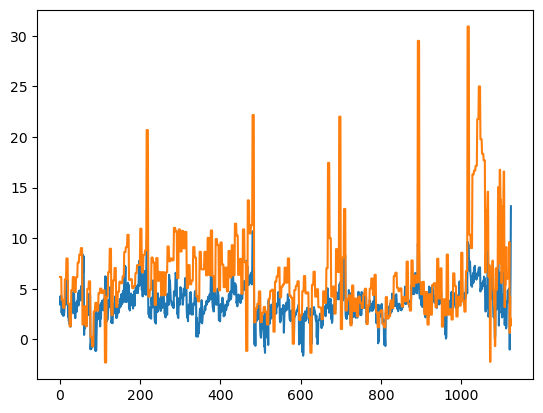

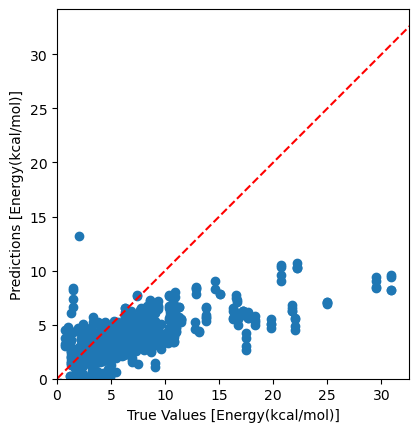

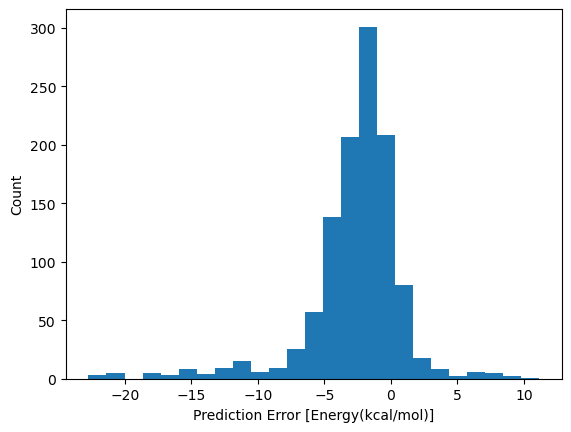

In [410]:
show_results(model,X_test,y_test)

In [411]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

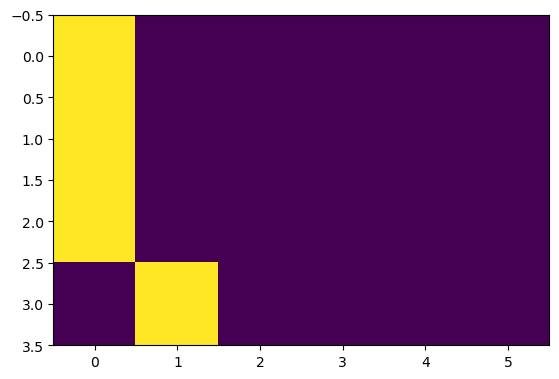

In [412]:
img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

In [413]:
## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

dict_keys(['conv2d_25', 'conv2d_26', 'flatten_14', 'dense_70', 'dropout_44', 'dense_71', 'dropout_45', 'dense_72', 'dropout_46', 'dense_73', 'dense_74'])


feature_maps shape:  (1, 4, 6, 64)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 64 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

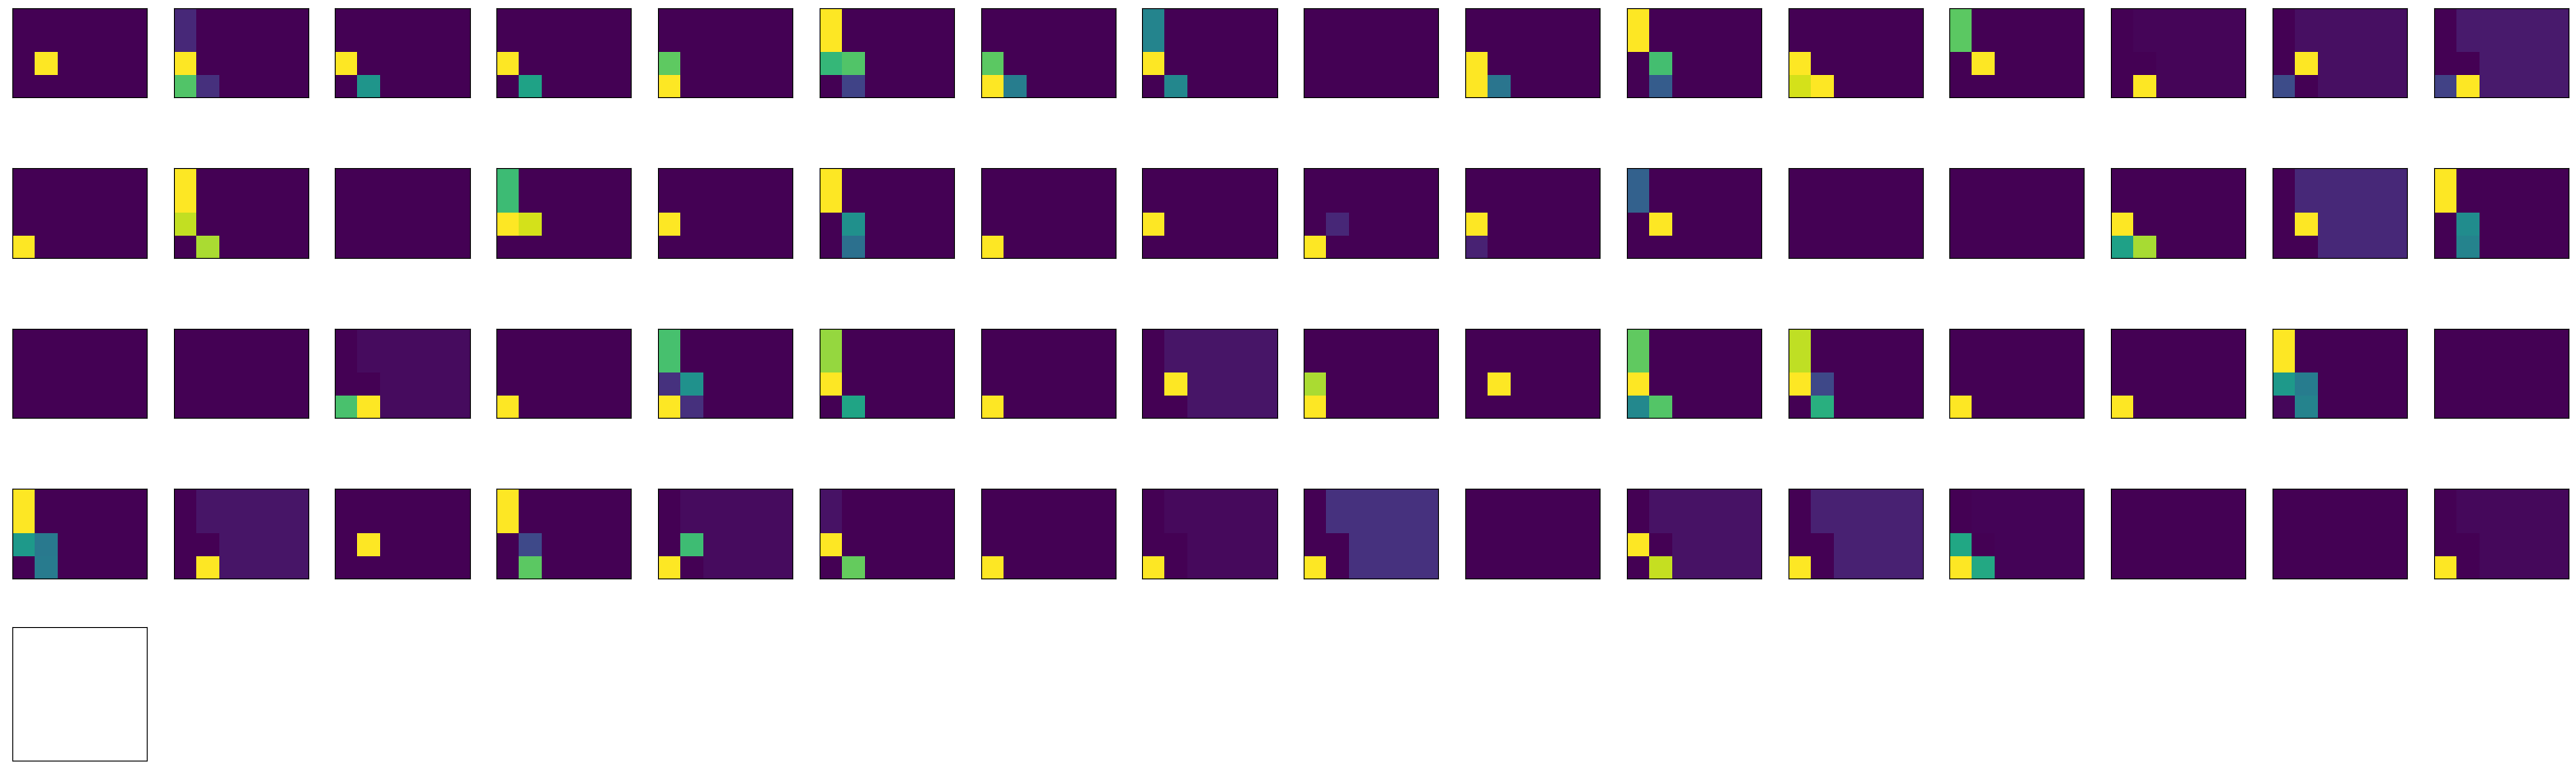

In [415]:
show_features(features,'conv2d_25')

feature_maps shape:  (1, 4, 6, 64)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 64 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

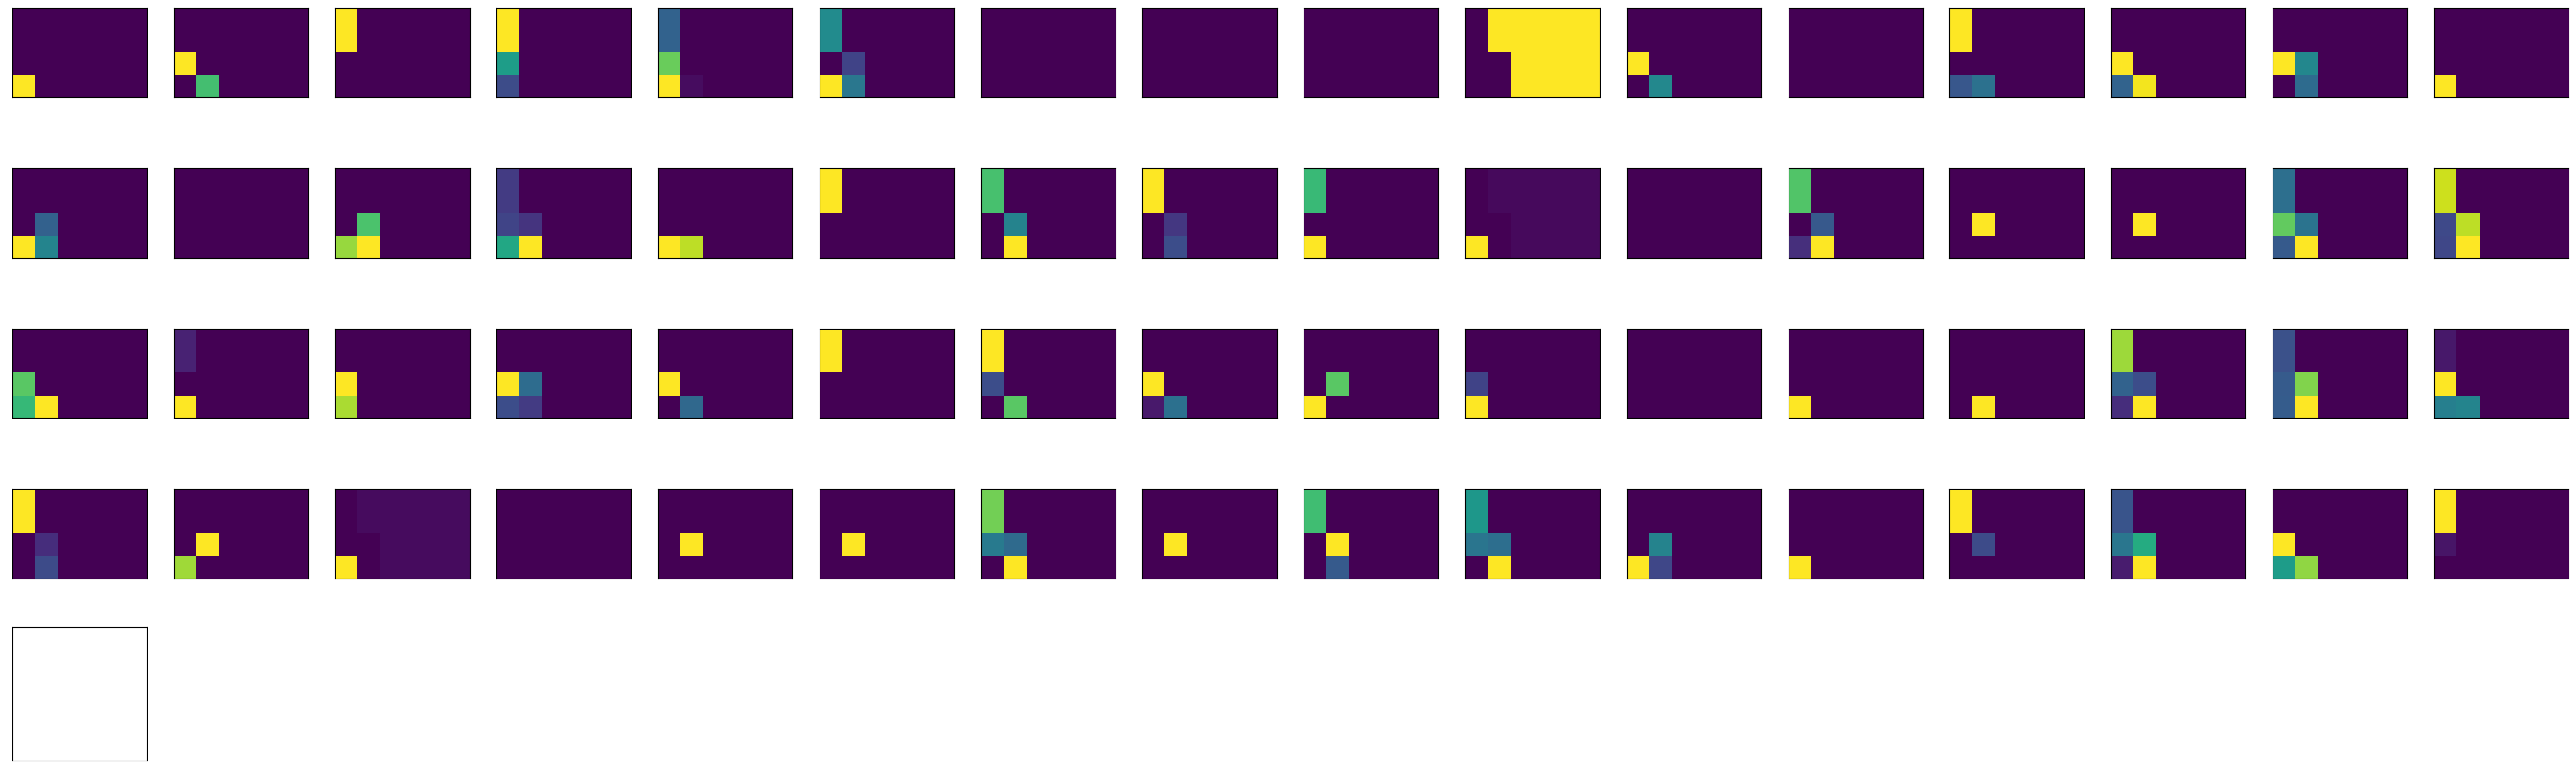

In [417]:
show_features(features,'conv2d_26')

In [456]:
from tensorflow import keras
from tensorflow.keras import layers

# Definir los filtros personalizados
filtros = [np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])]

# Definir la arquitectura de la red
model = keras.Sequential([
    layers.Conv2D(1, (3, 3), strides=1, input_shape=(4, 6, 1), activation='relu', 
                  kernel_initializer=keras.initializers.Constant(filtros), trainable=False),
    layers.Flatten(),
    layers.Dense(24, activation='elu'),
    layers.Dense(1, activation='linear')
])

# Compilar y entrenar la red
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
6/6 [==============================] - 1s 3ms/step - loss: 16.4811 - accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 15.9256 - accuracy: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 15.3831 - accuracy: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 14.8569 - accuracy: 0.0000e+00
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 14.3624 - accuracy: 0.0000e+00
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 13.9057 - accuracy: 0.0000e+00
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 13.4302 - accuracy: 0.0000e+00
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 13.0246 - accuracy: 0.0000e+00
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 12.6029 - accuracy: 0.0000e+00
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 12.2271 - 

6/6 [==============================] - 0s 2ms/step - loss: 5.7015 - accuracy: 0.0000e+00
Epoch 82/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6915 - accuracy: 0.0000e+00
Epoch 83/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6788 - accuracy: 0.0000e+00
Epoch 84/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6687 - accuracy: 0.0000e+00
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6599 - accuracy: 0.0000e+00
Epoch 86/100
6/6 [==============================] - 0s 1ms/step - loss: 5.6453 - accuracy: 0.0000e+00
Epoch 87/100
6/6 [==============================] - 0s 1ms/step - loss: 5.6373 - accuracy: 0.0000e+00
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6251 - accuracy: 0.0000e+00
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6186 - accuracy: 0.0000e+00
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6115 - accuracy: 0.00

Test Loss: 31.135517120361328
Test Accuracy: 0.0
36/36 [==============================] - 0s 1ms/step
Coeficiente de correlacion: -0.5103847505635244


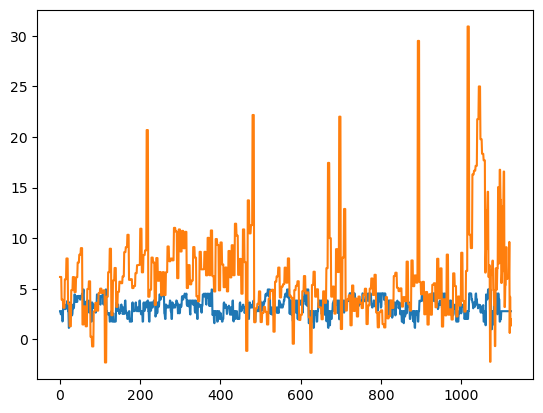

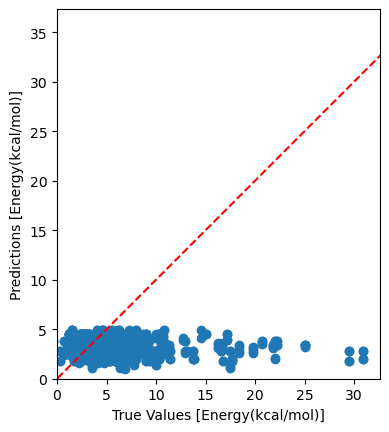

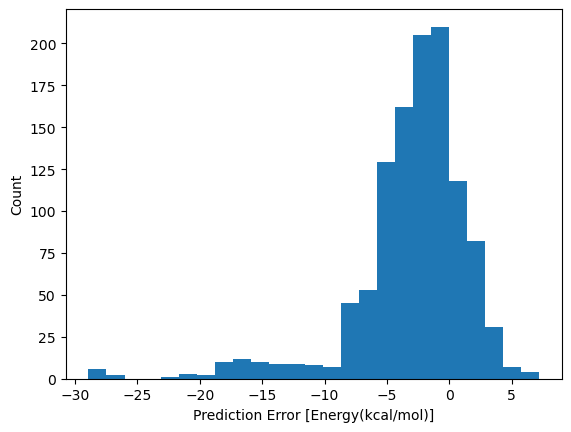

In [457]:
show_results(model,X_test,y_test)

dict_keys(['conv2d_40', 'flatten_28', 'dense_95', 'dense_96'])


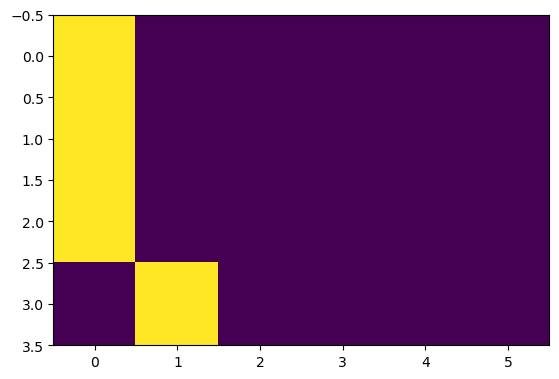

In [458]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

feature_maps shape:  (1, 2, 4, 1)


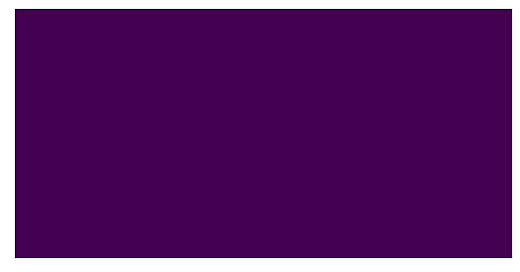

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)


In [460]:
show_features2(features,'conv2d_40')